In [2]:
!pip install numpy pandas matplotlib -q
!pip install -U statsmodels -q
!pip install prophet -q
!pip install pymannkendall -q
!pip install ydata-profiling -q
!pip install prophet arch lightgbm -q

  You can safely remove it manually.


In [3]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import os

import statsmodels.api as sm
import pymannkendall as mk
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats as scipy_stats
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import f_oneway
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from sklearn.linear_model import Ridge

from prophet import Prophet
from arch import arch_model
from statsmodels.tsa.forecasting.theta import ThetaModel
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# Best model by AIC (from grid search)
BEST_AIC_MODEL = {
    'order': (1, 1, 2),
    'seasonal_order': (2, 0, 1, 12),
    'name': 'SARIMA(1,1,2)(2,0,1)[12]'
}

# Best model by RMSE (from multi-horizon evaluation)
BEST_RMSE_MODEL = {
    'order': (3, 1, 2),
    'seasonal_order': (1, 0, 1, 12),
    'name': 'SARIMA(3,1,2)(1,0,1)[12]'
}

# Forecast horizon for final forecast (in months)
FORECAST_HORIZON = 36  # 3 years

# Test set size for evaluation
TEST_SIZE = 12

In [3]:
COLORS = {
    'historical': '#2E86AB',
    'best_aic': '#A23B72',
    'best_rmse': '#6A994E',
    'naive': '#C73E1D',
    'ci': '#A23B72'
}

print("="*70)
print("MODEL CONFIGURATION")
print("="*70)
print(f"Best AIC Model:  {BEST_AIC_MODEL['name']}")
print(f"Best RMSE Model: {BEST_RMSE_MODEL['name']}")
print(f"Forecast Horizon: {FORECAST_HORIZON} months ({FORECAST_HORIZON//12} years)")
print(f"Test Set Size: {TEST_SIZE} months")
print("="*70)

MODEL CONFIGURATION
Best AIC Model:  SARIMA(1,1,2)(2,0,1)[12]
Best RMSE Model: SARIMA(3,1,2)(1,0,1)[12]
Forecast Horizon: 36 months (3 years)
Test Set Size: 12 months


In [4]:
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.6
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True

plt.rcParams['figure.figsize'] = (14, 6)


In [5]:
# Comment this cell if running on Local Jupyter
'''wages_raw = '/content/drive/MyDrive/Colab-Projects/Time-Series/AHETPI.csv'
cpi_raw = '/content/drive/MyDrive/Colab-Projects/Time-Series/CPIAUCSL.csv'''

"wages_raw = '/content/drive/MyDrive/Colab-Projects/Time-Series/AHETPI.csv'\ncpi_raw = '/content/drive/MyDrive/Colab-Projects/Time-Series/CPIAUCSL.csv"

In [6]:
# Comment this cell if running on Google Colab
data_folder = 'data'
wages_raw = os.path.join(data_folder, 'AHETPI.csv')
cpi_raw = os.path.join(data_folder, 'CPIAUCSL.csv')

In [7]:
wages = pd.read_csv(wages_raw)
cpi = pd.read_csv(cpi_raw)

In [8]:
print("Wages Data Shape:", wages.shape)
print("CPI Data Shape:", cpi.shape)

Wages Data Shape: (740, 2)
CPI Data Shape: (741, 2)


In [9]:
print(wages.head())

  observation_date  AHETPI
0       1964-01-01    2.50
1       1964-02-01    2.50
2       1964-03-01    2.51
3       1964-04-01    2.52
4       1964-05-01    2.52


In [10]:
print(cpi.tail())

    observation_date  CPIAUCSL
736       2025-05-01   320.580
737       2025-06-01   321.500
738       2025-07-01   322.132
739       2025-08-01   323.364
740       2025-09-01   324.368


In [11]:
extra_row = cpi[~cpi['observation_date'].isin(wages['observation_date'])]
print(f"\nExtra rows in CPI: {len(extra_row)}")


Extra rows in CPI: 1


In [12]:
if len(extra_row) > 0:
    cpi = cpi.drop(cpi.index[-1])

In [13]:
cpi['observation_date'] = pd.to_datetime(cpi['observation_date'])
wages['observation_date'] = pd.to_datetime(wages['observation_date'])
cpi = cpi.set_index('observation_date')
wages = wages.set_index('observation_date')

In [14]:
true_wages = pd.DataFrame()
true_wages['true_wages'] = (wages['AHETPI'] / cpi['CPIAUCSL']) * 100

In [15]:
true_wages.head()

true_wages
observation_date            
1964-01-01          8.080155
1964-02-01          8.087997
1964-03-01          8.112476
1964-04-01          8.142165
1964-05-01          8.134280

In [16]:
print(f"\nReal Wages Data Range: {true_wages.index[0].strftime('%Y-%m')} to {true_wages.index[-1].strftime('%Y-%m')}")
print(f"Total Observations: {len(true_wages)}")


Real Wages Data Range: 1964-01 to 2025-08
Total Observations: 740


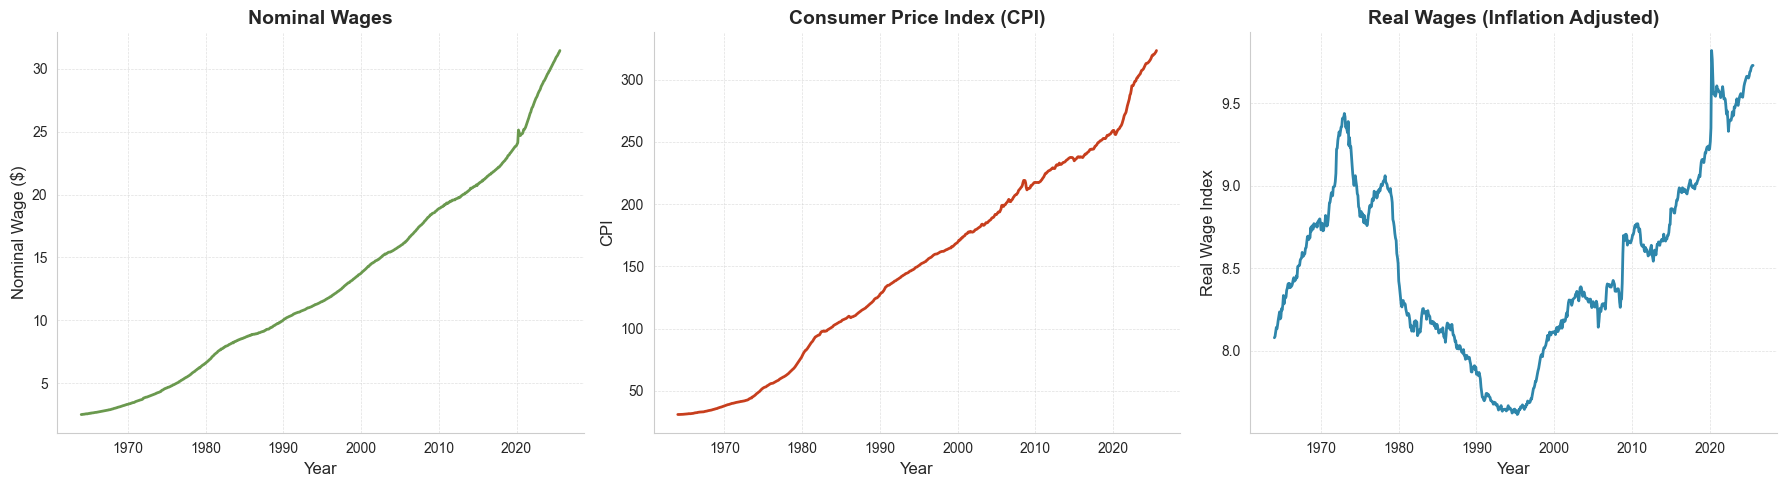

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(wages.index, wages.values, color='#6A994E', linewidth=2)
axes[0].set_title('Nominal Wages', fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Nominal Wage ($)')

axes[1].plot(cpi.index, cpi.values, color='#C73E1D', linewidth=2)
axes[1].set_title('Consumer Price Index (CPI)', fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('CPI')

axes[2].plot(true_wages.index, true_wages.values, color='#2E86AB', linewidth=2)
axes[2].set_title('Real Wages (Inflation Adjusted)', fontweight='bold')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Real Wage Index')

plt.tight_layout()
plt.show()

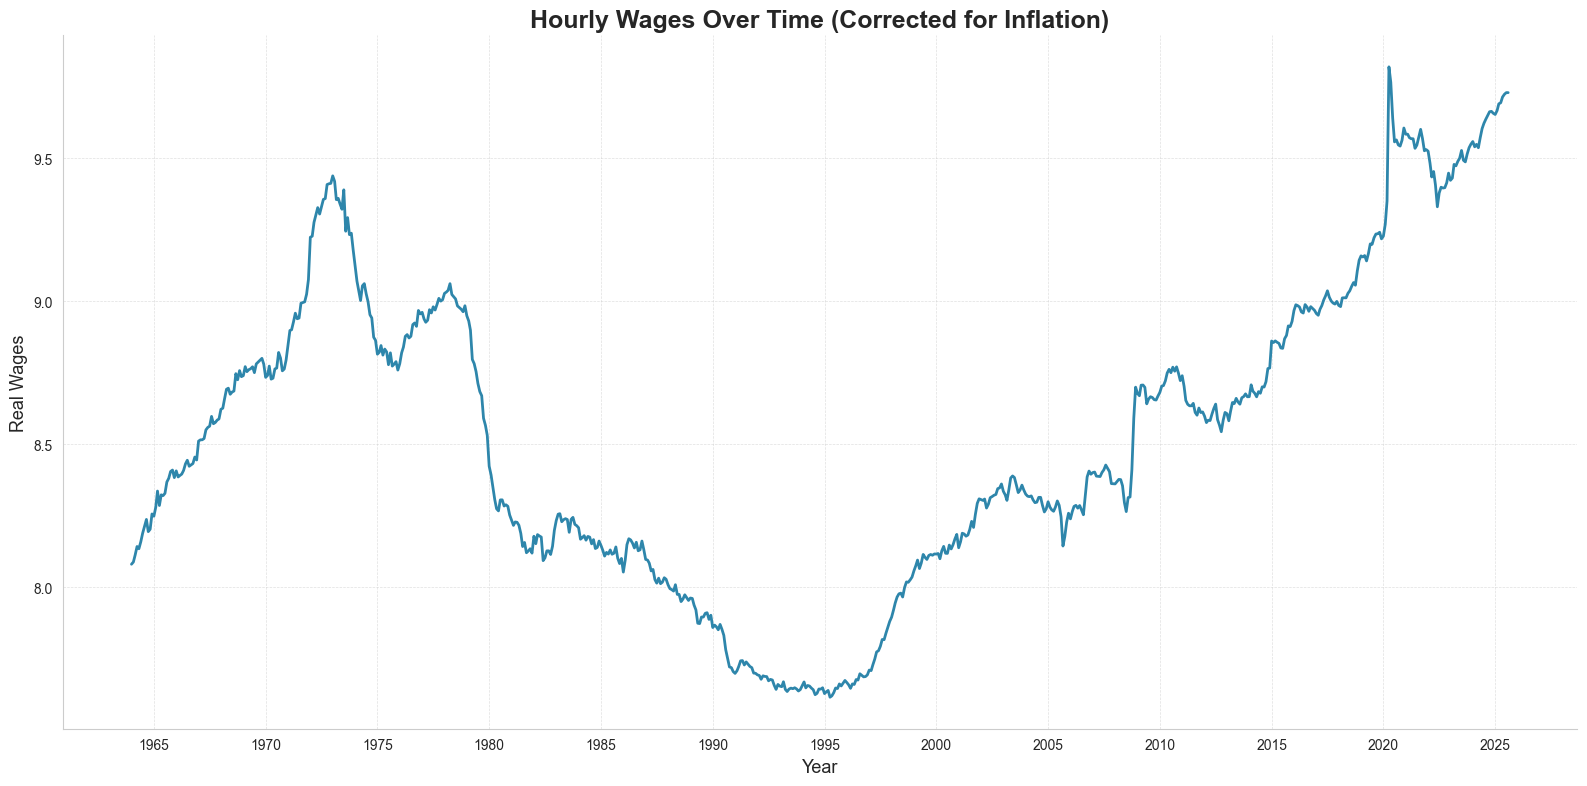

In [18]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(true_wages.index, true_wages.values, color=COLORS['historical'], linewidth=2, zorder=3)
ax.set_title('Hourly Wages Over Time (Corrected for Inflation)', fontsize=18, fontweight='bold')
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlabel('Year', fontsize=13)
ax.set_ylabel('Real Wages', fontsize=13)
plt.tight_layout()
plt.show()

In [19]:
true_wages['YoY_Change'] = true_wages['true_wages'].pct_change(periods=12) * 100
true_wages['Seasonal_Diff'] = true_wages['true_wages'].diff(12)

In [20]:
yoy_change = true_wages['YoY_Change'].dropna()
true_wages_clean = true_wages['true_wages'].dropna()

In [21]:
true_wages['YoY_Change'].describe()

count    728.000000
mean       0.296049
std        1.705798
min       -6.140034
25%       -0.642462
50%        0.350954
75%        1.334415
max        7.421970
Name: YoY_Change, dtype: float64

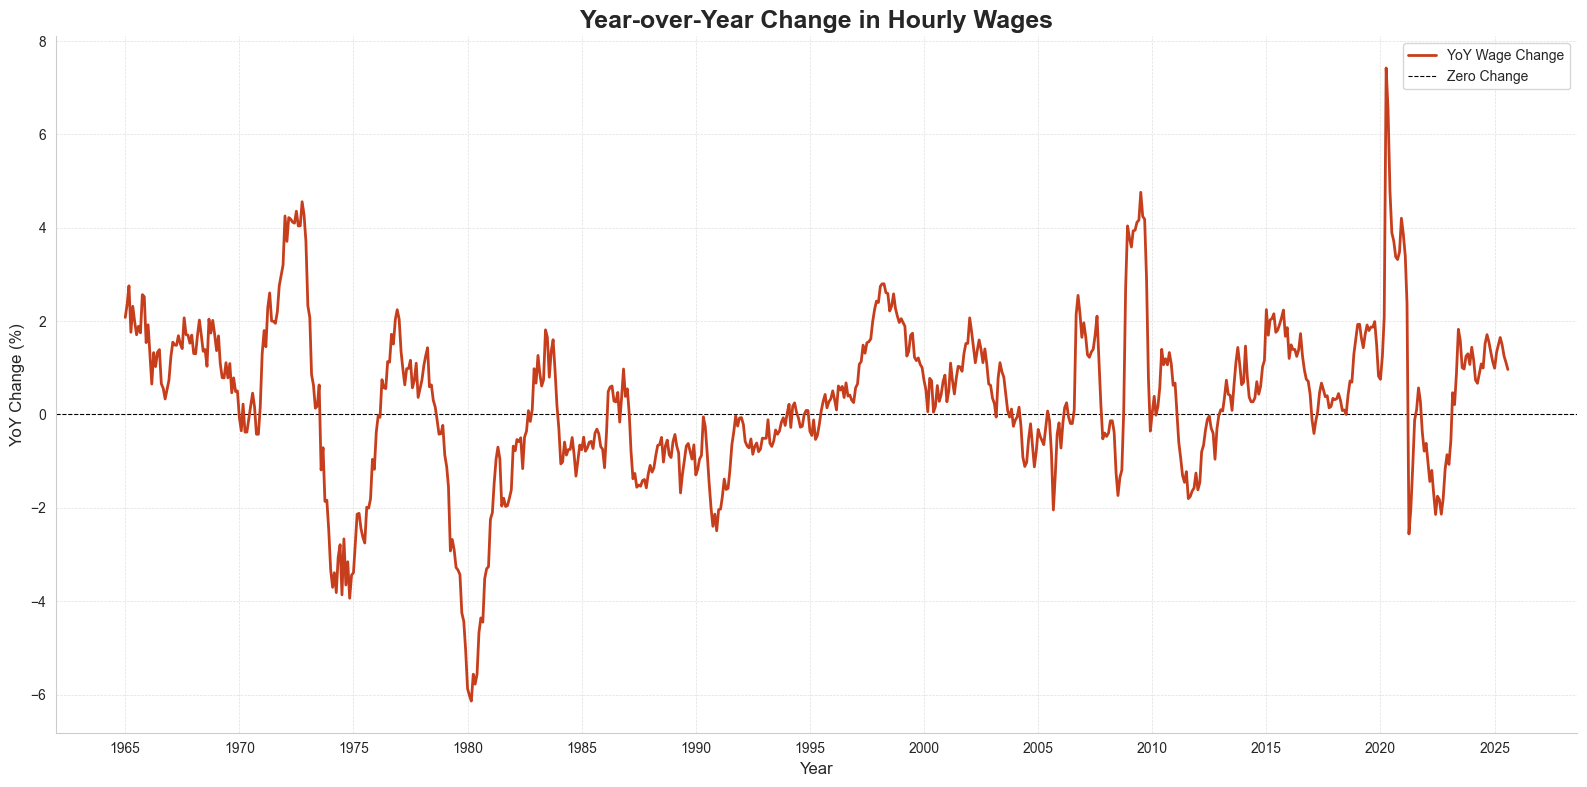

In [22]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(true_wages.index, true_wages['YoY_Change'],
        color='#C73E1D', linewidth=2, label='YoY Wage Change', zorder=3)
ax.set_title('Year-over-Year Change in Hourly Wages', fontsize=18, fontweight='bold')
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('YoY Change (%)', fontsize=12)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, label='Zero Change')
ax.legend()
plt.tight_layout()
plt.show()

In [23]:
result_mk = mk.original_test(true_wages['true_wages'].dropna())
print("="*60)
print("MANN-KENDALL TREND TEST")
print("="*60)
print(f"Trend: {result_mk.trend}")
print(f"p-value: {result_mk.p}")
print(f"Tau statistic: {result_mk.Tau}")
print("="*60)

MANN-KENDALL TREND TEST
Trend: increasing
p-value: 6.661338147750939e-16
Tau statistic: 0.19893574223750138


In [24]:
yoy_change = true_wages['YoY_Change'].dropna()
true_wages_clean = true_wages['true_wages'].dropna()

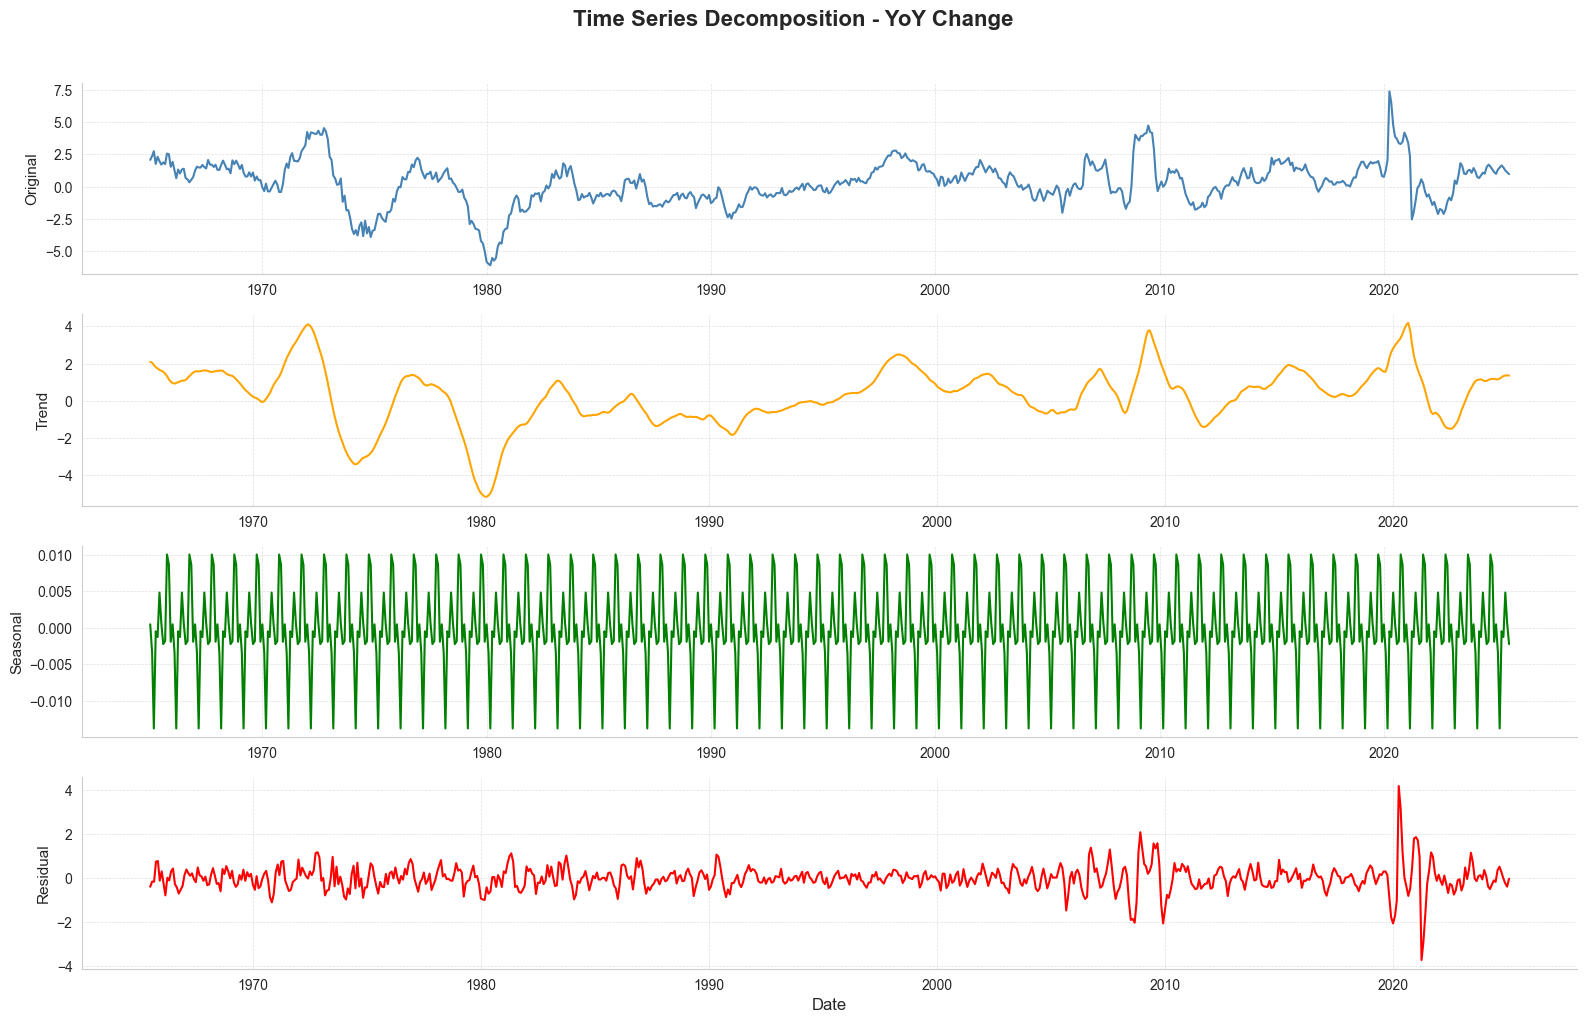

In [25]:
result_decomp = seasonal_decompose(yoy_change, model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(16, 10))
fig.suptitle('Time Series Decomposition - YoY Change', fontsize=16, fontweight='bold', y=1.02)

axes[0].plot(yoy_change.index, yoy_change, color='steelblue')
axes[0].set_ylabel('Original', fontsize=11)

axes[1].plot(yoy_change.index, result_decomp.trend, color='orange')
axes[1].set_ylabel('Trend', fontsize=11)

axes[2].plot(yoy_change.index, result_decomp.seasonal, color='green')
axes[2].set_ylabel('Seasonal', fontsize=11)

axes[3].plot(yoy_change.index, result_decomp.resid, color='red')
axes[3].set_ylabel('Residual', fontsize=11)
axes[3].set_xlabel('Date', fontsize=12)

plt.tight_layout()
plt.show()

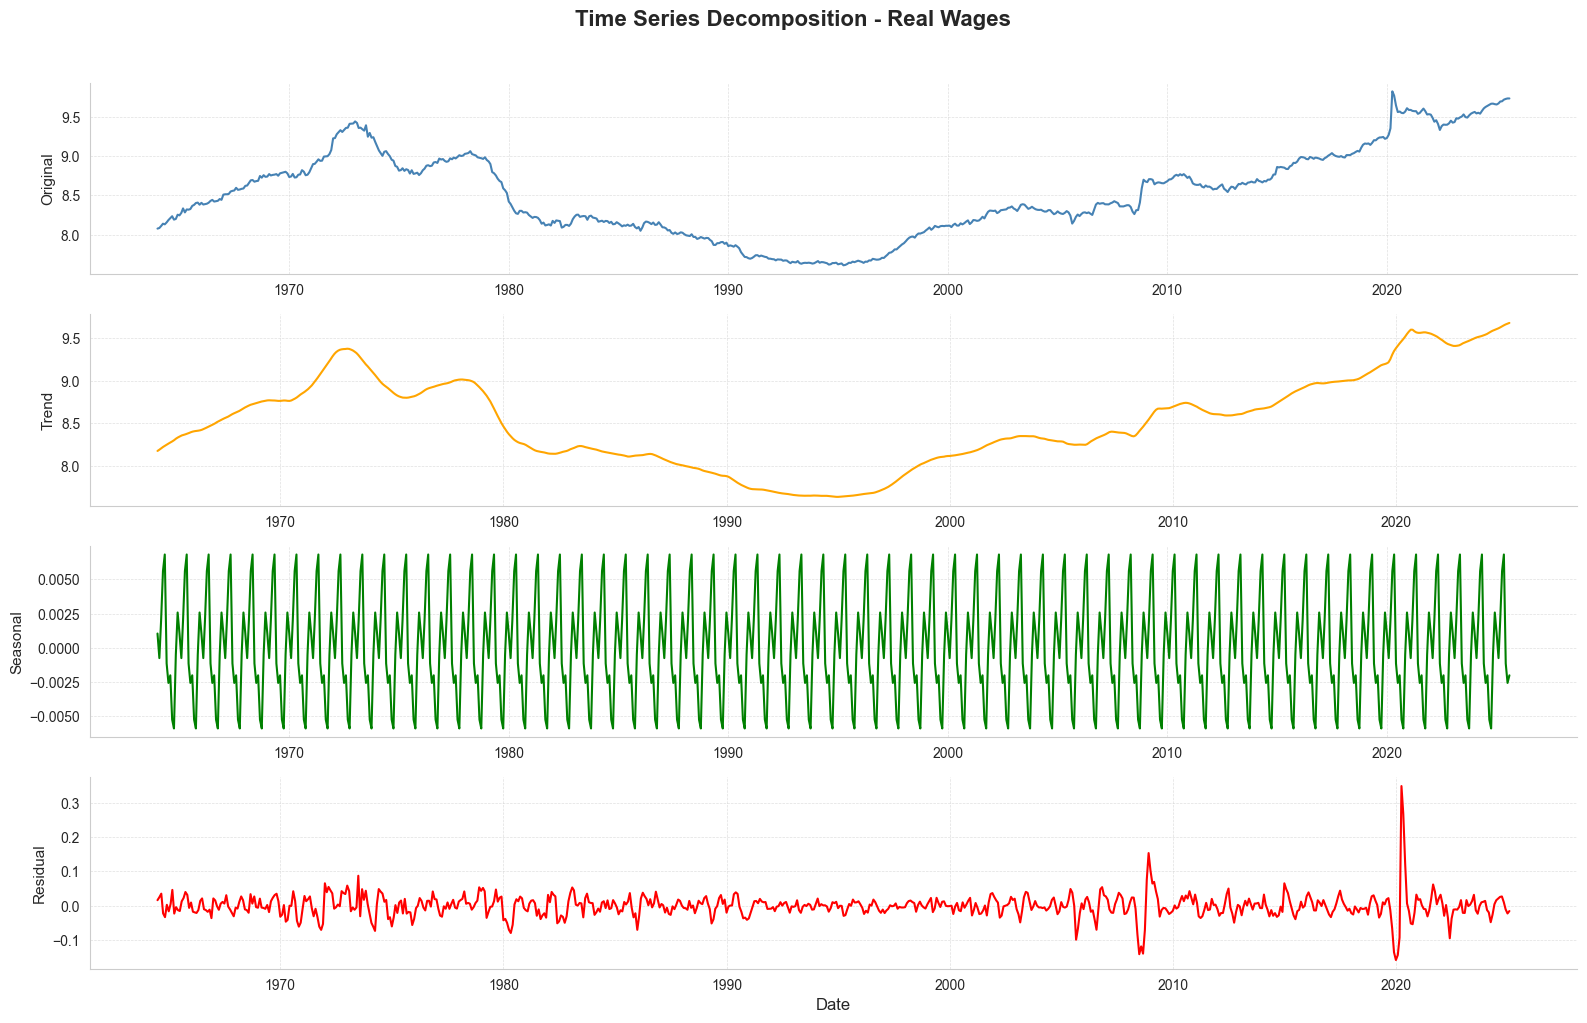

In [26]:
result_decomp_wages = seasonal_decompose(true_wages_clean, model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(16, 10))
fig.suptitle('Time Series Decomposition - Real Wages', fontsize=16, fontweight='bold', y=1.02)

axes[0].plot(true_wages_clean.index, true_wages_clean, color='steelblue')
axes[0].set_ylabel('Original', fontsize=11)

axes[1].plot(true_wages_clean.index, result_decomp_wages.trend, color='orange')
axes[1].set_ylabel('Trend', fontsize=11)

axes[2].plot(true_wages_clean.index, result_decomp_wages.seasonal, color='green')
axes[2].set_ylabel('Seasonal', fontsize=11)

axes[3].plot(true_wages_clean.index, result_decomp_wages.resid, color='red')
axes[3].set_ylabel('Residual', fontsize=11)
axes[3].set_xlabel('Date', fontsize=12)

plt.tight_layout()
plt.show()

In [27]:
var_residual = np.var(result_decomp.resid.dropna())
var_seasonal_plus_residual = np.var(result_decomp.seasonal.dropna() + result_decomp.resid.dropna())
seasonal_strength = 1 - (var_residual / var_seasonal_plus_residual)
print(f"\nSeasonal Strength: {seasonal_strength:.4f}")


Seasonal Strength: 0.0001


In [28]:
monthly_data = true_wages.copy()
monthly_data['month'] = monthly_data.index.month
groups = [group['YoY_Change'].dropna().values for name, group in monthly_data.groupby('month')]
f_stat, p_value = f_oneway(*groups)

print("\n" + "="*60)
print("ANOVA TEST FOR MONTHLY SEASONALITY")
print("="*60)
print(f"F-Statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Result: Significant monthly seasonality detected")
else:
    print("Result: No significant monthly seasonality (deterministic)")
    print("Note: SARIMA captures stochastic seasonality (year-over-year persistence)")
print("="*60)


ANOVA TEST FOR MONTHLY SEASONALITY
F-Statistic: 0.0026
p-value: 1.0000
Result: No significant monthly seasonality (deterministic)
Note: SARIMA captures stochastic seasonality (year-over-year persistence)


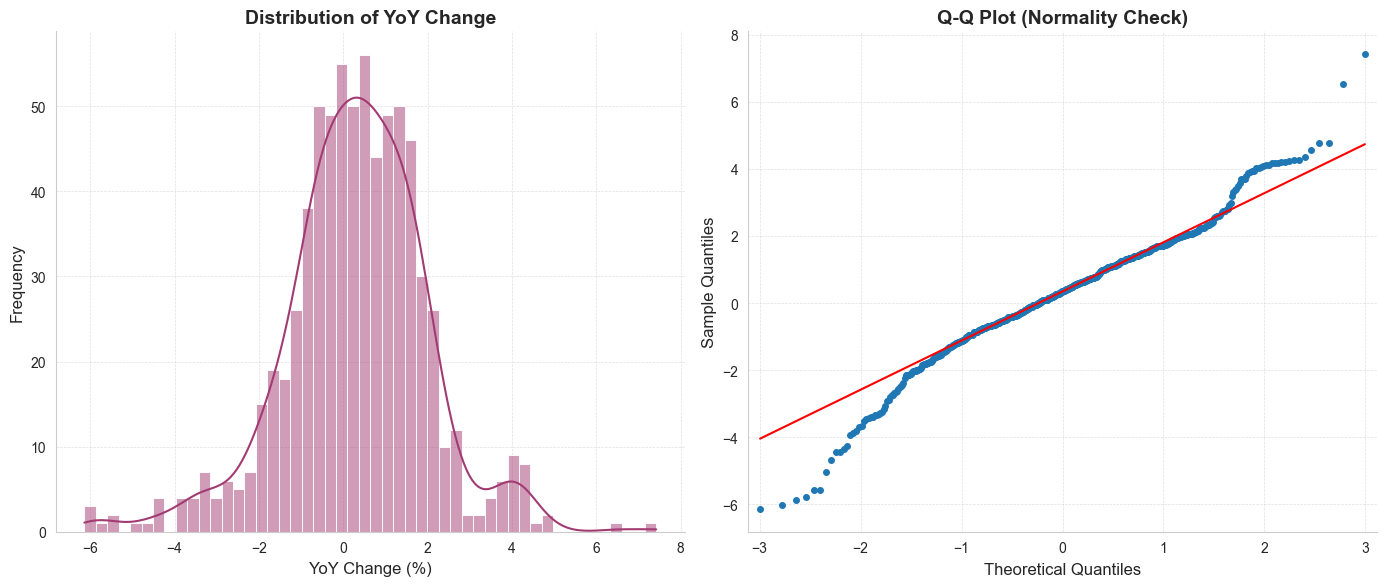

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
sns.histplot(yoy_change, bins=50, kde=True, color='#A23B72', ax=axes[0], edgecolor='white')
axes[0].set_title('Distribution of YoY Change', fontsize=14, fontweight='bold')
axes[0].set_xlabel('YoY Change (%)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Q-Q Plot
sm.qqplot(yoy_change, line='q', ax=axes[1])
axes[1].set_title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].set_ylabel('Sample Quantiles')

plt.tight_layout()
plt.show()

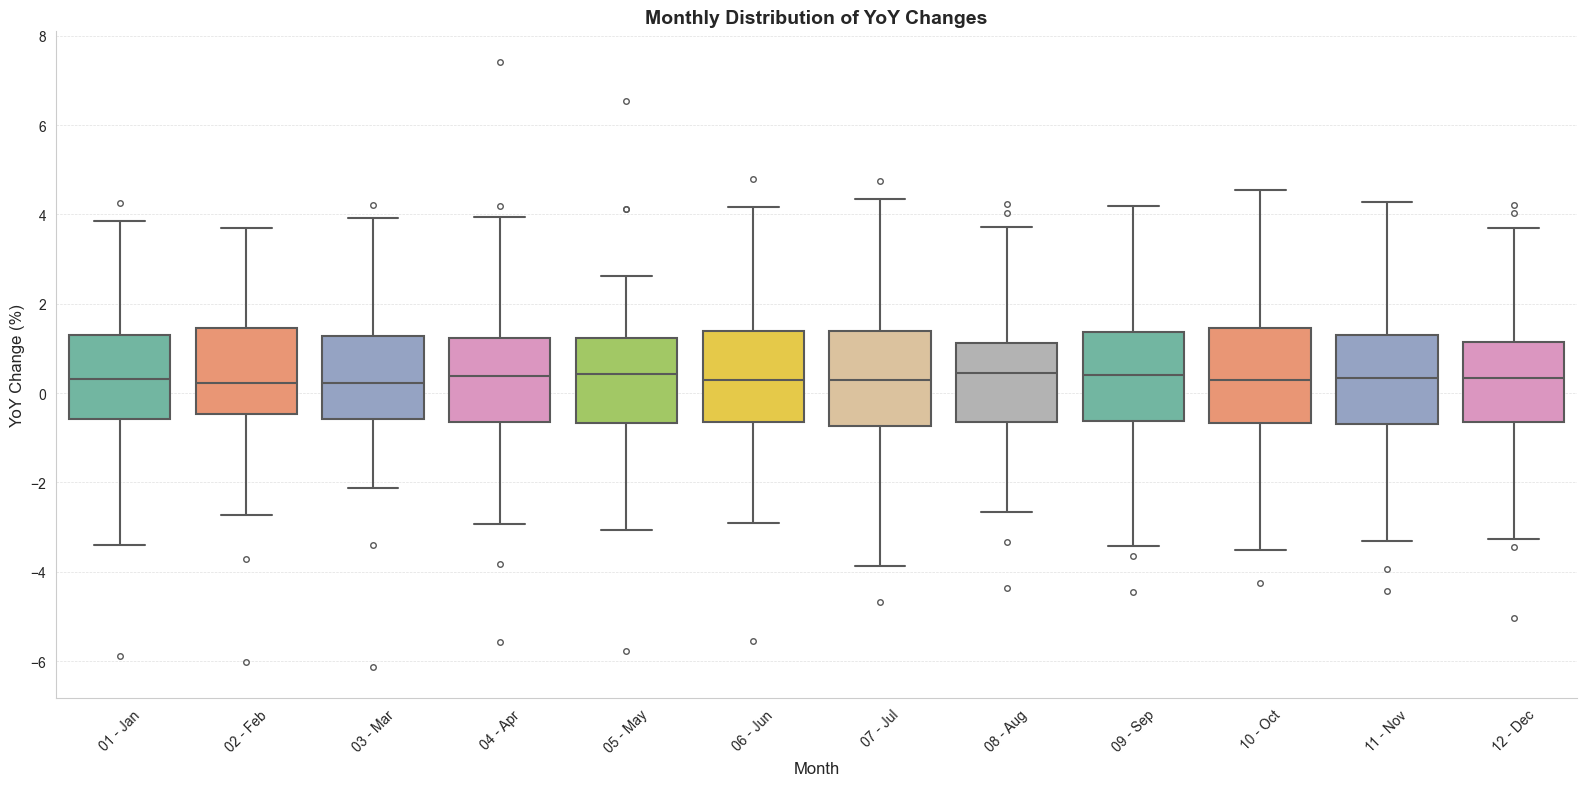

In [30]:
monthly_data = true_wages.copy()
monthly_data['month'] = monthly_data.index.strftime('%m - %b')
monthly_data.dropna(inplace=True)

fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='month', y='YoY_Change', data=monthly_data, palette='Set2', ax=ax, linewidth=1.5)
ax.set_title('Monthly Distribution of YoY Changes', fontsize=14, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('YoY Change (%)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

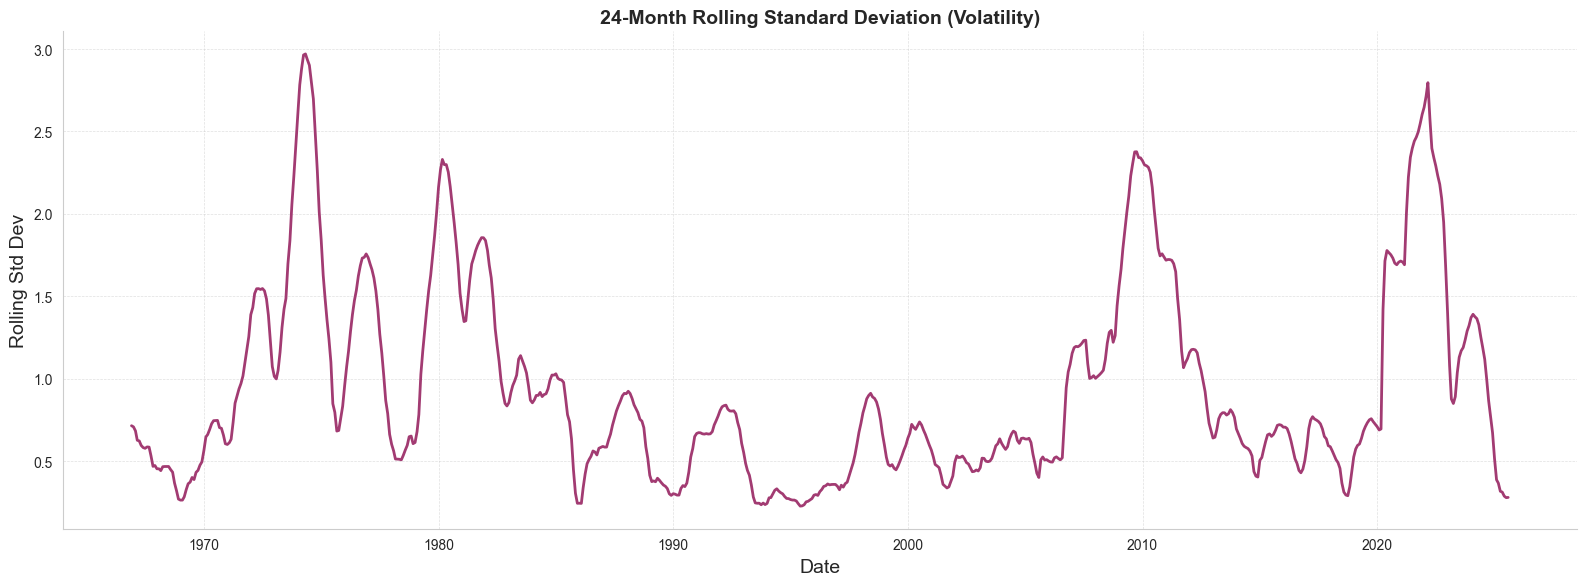

In [31]:
volatile = true_wages['YoY_Change'].rolling(window=24).std()

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(volatile.index, volatile.values, color='#A23B72', linewidth=2, zorder=3)
ax.set_title('24-Month Rolling Standard Deviation (Volatility)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Rolling Std Dev', fontsize=14)
plt.tight_layout()
plt.show()


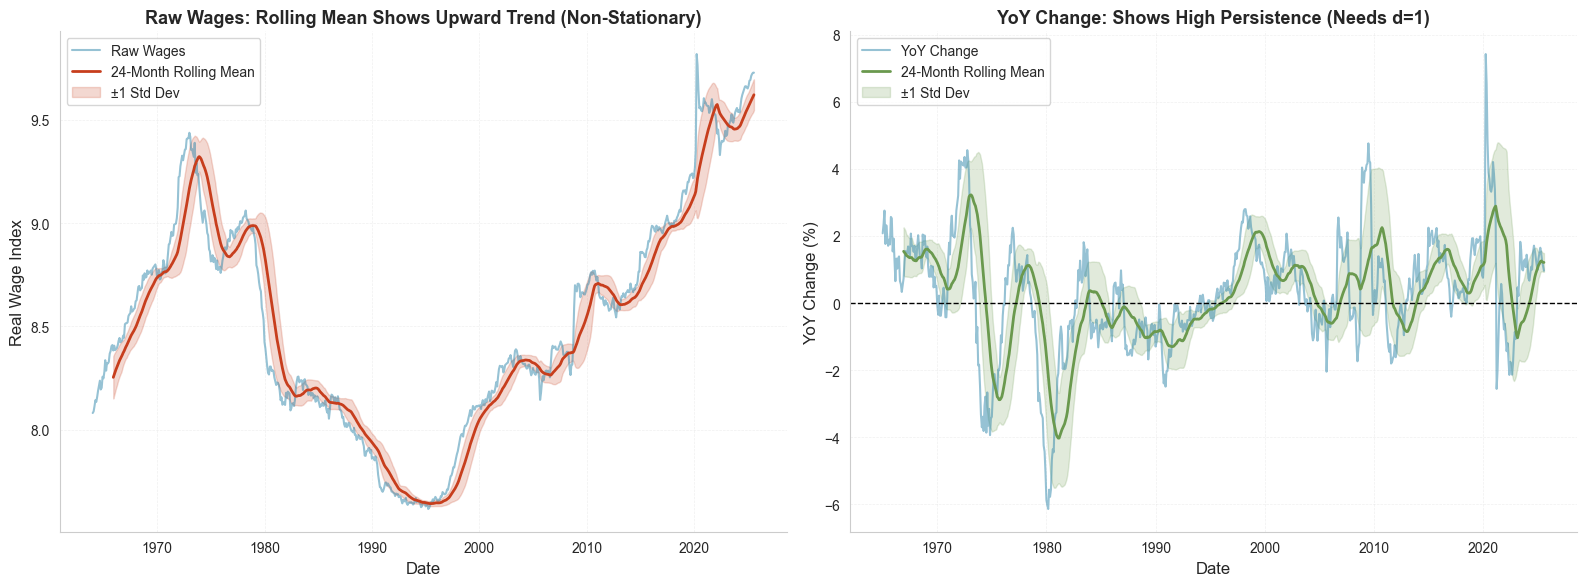

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw wages - non-stationary
rolling_mean_wages = true_wages_clean.rolling(window=24).mean()
rolling_std_wages = true_wages_clean.rolling(window=24).std()

axes[0].plot(true_wages_clean.index, true_wages_clean.values, color='#2E86AB', alpha=0.5, label='Raw Wages')
axes[0].plot(rolling_mean_wages.index, rolling_mean_wages.values, color='#C73E1D', linewidth=2, label='24-Month Rolling Mean')
axes[0].fill_between(rolling_mean_wages.index,
                     rolling_mean_wages - rolling_std_wages,
                     rolling_mean_wages + rolling_std_wages,
                     color='#C73E1D', alpha=0.2, label='±1 Std Dev')
axes[0].set_title('Raw Wages: Rolling Mean Shows Upward Trend (Non-Stationary)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Real Wage Index')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# YoY change - shows persistence
rolling_mean_yoy = yoy_change.rolling(window=24).mean()
rolling_std_yoy = yoy_change.rolling(window=24).std()

axes[1].plot(yoy_change.index, yoy_change.values, color='#2E86AB', alpha=0.5, label='YoY Change')
axes[1].plot(rolling_mean_yoy.index, rolling_mean_yoy.values, color='#6A994E', linewidth=2, label='24-Month Rolling Mean')
axes[1].fill_between(rolling_mean_yoy.index,
                     rolling_mean_yoy - rolling_std_yoy,
                     rolling_mean_yoy + rolling_std_yoy,
                     color='#6A994E', alpha=0.2, label='±1 Std Dev')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('YoY Change: Shows High Persistence (Needs d=1)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('YoY Change (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

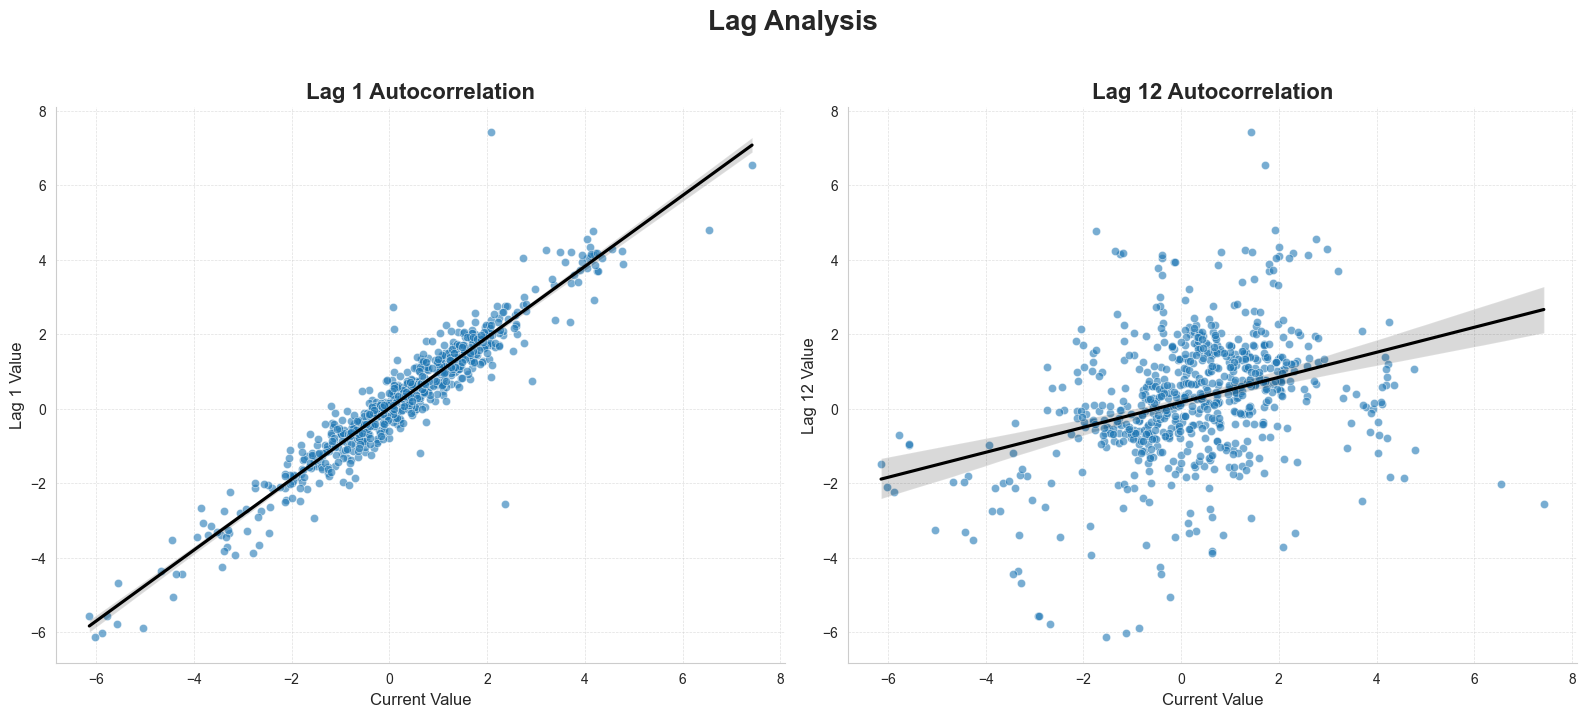

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Lag 1 scatter
x1 = true_wages['YoY_Change'][:-1].values
y1 = true_wages['YoY_Change'][1:].values
mask1 = ~(np.isnan(x1) | np.isnan(y1))

sns.scatterplot(x=x1[mask1], y=y1[mask1], s=35, alpha=0.6, ax=axes[0])
sns.regplot(x=x1[mask1], y=y1[mask1], scatter=False, line_kws={'color': 'black'}, ax=axes[0])
axes[0].set_title("Lag 1 Autocorrelation", fontsize=16, fontweight="bold")
axes[0].set_xlabel("Current Value", fontsize=12)
axes[0].set_ylabel("Lag 1 Value", fontsize=12)

# Lag 12 scatter
x12 = true_wages['YoY_Change'][:-12].values
y12 = true_wages['YoY_Change'][12:].values
mask12 = ~(np.isnan(x12) | np.isnan(y12))

sns.scatterplot(x=x12[mask12], y=y12[mask12], s=35, alpha=0.6, ax=axes[1])
sns.regplot(x=x12[mask12], y=y12[mask12], scatter=False, line_kws={'color': 'black'}, ax=axes[1])
axes[1].set_title("Lag 12 Autocorrelation", fontsize=16, fontweight="bold")
axes[1].set_xlabel("Current Value", fontsize=12)
axes[1].set_ylabel("Lag 12 Value", fontsize=12)

fig.suptitle("Lag Analysis", fontsize=20, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

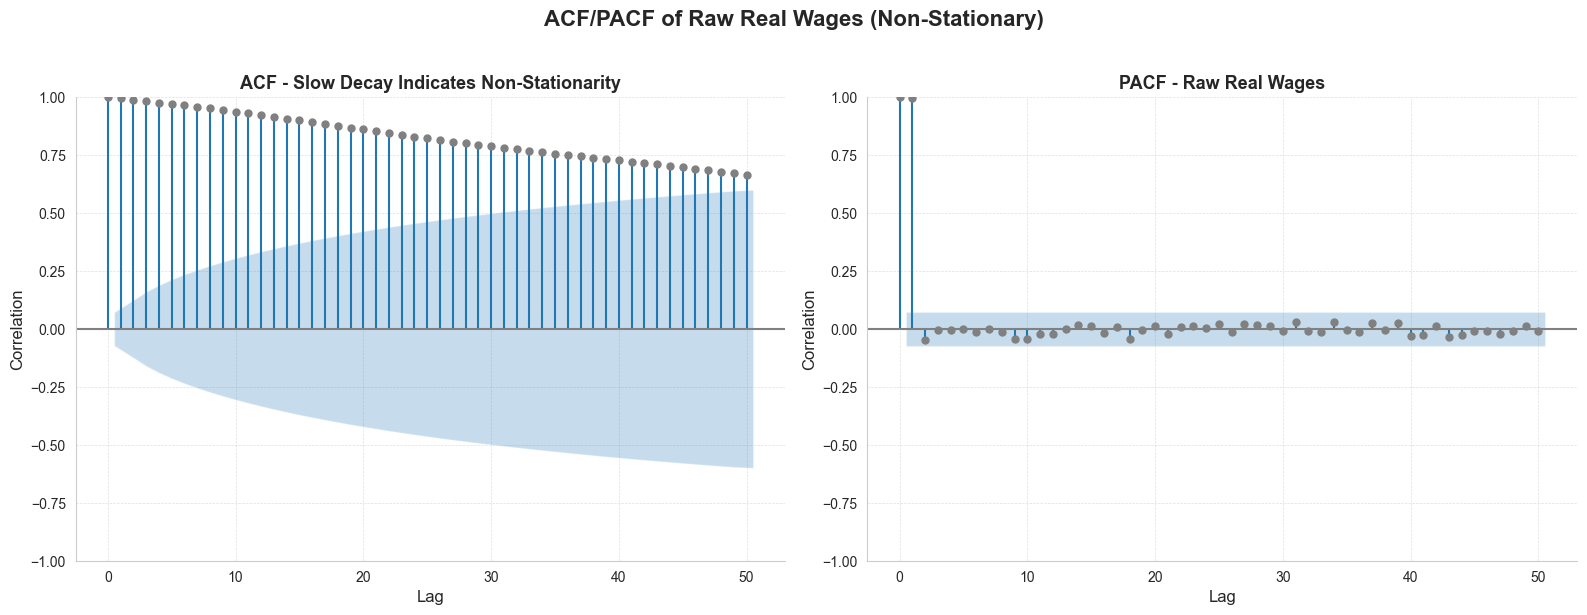

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('ACF/PACF of Raw Real Wages (Non-Stationary)', fontsize=16, fontweight='bold', y=1.02)

plot_acf(true_wages_clean, ax=axes[0], lags=50, alpha=0.05, color='gray')
axes[0].set_title('ACF - Slow Decay Indicates Non-Stationarity', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=12)
axes[0].set_ylabel('Correlation', fontsize=12)

plot_pacf(true_wages_clean, ax=axes[1], lags=50, alpha=0.05, color='gray')
axes[1].set_title('PACF - Raw Real Wages', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=12)
axes[1].set_ylabel('Correlation', fontsize=12)

plt.tight_layout()
plt.show()

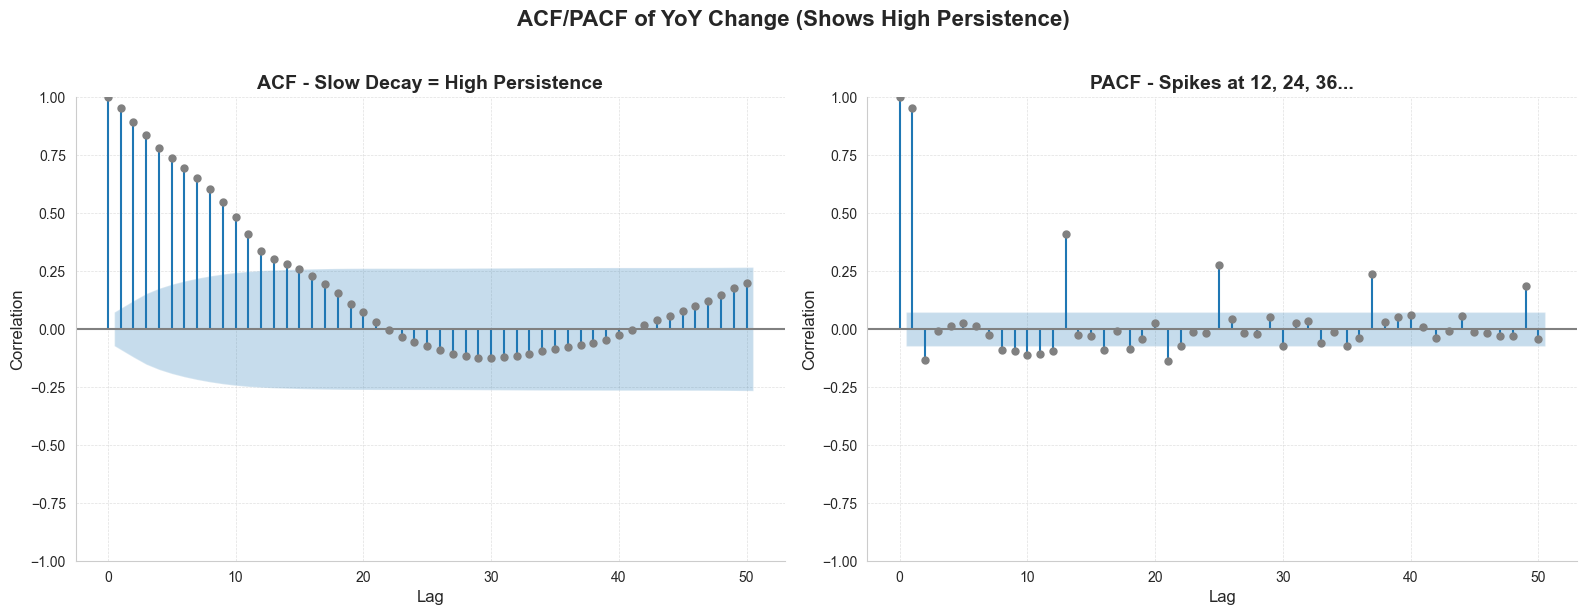

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('ACF/PACF of YoY Change (Shows High Persistence)', fontsize=16, fontweight='bold', y=1.02)

plot_acf(yoy_change, ax=axes[0], lags=50, alpha=0.05, color='gray')
axes[0].set_title('ACF - Slow Decay = High Persistence', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=12)
axes[0].set_ylabel('Correlation', fontsize=12)

plot_pacf(yoy_change, ax=axes[1], lags=50, alpha=0.05, color='gray')
axes[1].set_title('PACF - Spikes at 12, 24, 36...', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=12)
axes[1].set_ylabel('Correlation', fontsize=12)

plt.tight_layout()
plt.show()

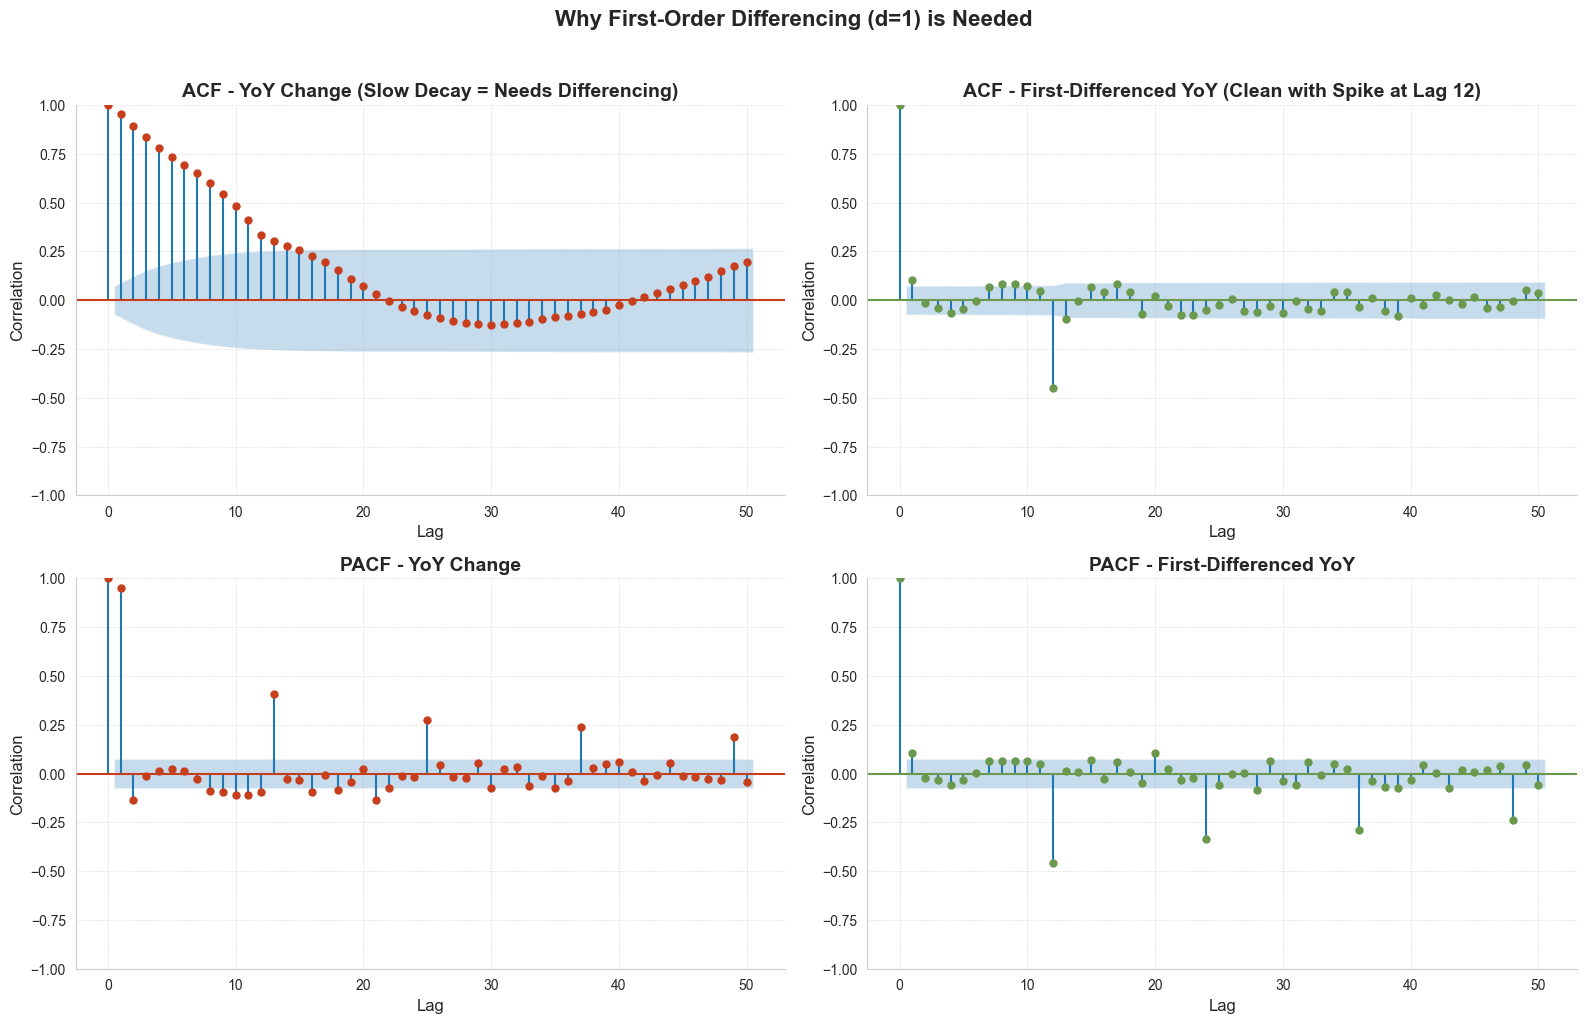

In [36]:
yoy_diff = yoy_change.diff().dropna()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Why First-Order Differencing (d=1) is Needed', fontsize=16, fontweight='bold', y=1.02)

# ACF comparison
plot_acf(yoy_change, ax=axes[0, 0], lags=50, alpha=0.05, color='#C73E1D')
axes[0, 0].set_title('ACF - YoY Change (Slow Decay = Needs Differencing)', fontweight='bold')
axes[0, 0].set_xlabel('Lag')
axes[0, 0].set_ylabel('Correlation')

plot_acf(yoy_diff, ax=axes[0, 1], lags=50, alpha=0.05, color='#6A994E')
axes[0, 1].set_title('ACF - First-Differenced YoY (Clean with Spike at Lag 12)', fontweight='bold')
axes[0, 1].set_xlabel('Lag')
axes[0, 1].set_ylabel('Correlation')

# PACF comparison
plot_pacf(yoy_change, ax=axes[1, 0], lags=50, alpha=0.05, color='#C73E1D')
axes[1, 0].set_title('PACF - YoY Change', fontweight='bold')
axes[1, 0].set_xlabel('Lag')
axes[1, 0].set_ylabel('Correlation')

plot_pacf(yoy_diff, ax=axes[1, 1], lags=50, alpha=0.05, color='#6A994E')
axes[1, 1].set_title('PACF - First-Differenced YoY', fontweight='bold')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('Correlation')

plt.tight_layout()
plt.show()

In [37]:
def test_stationarity(series, name):
    """Perform ADF and KPSS tests for stationarity"""
    print(f"\n{name}:")
    print("-" * 40)
    
    # ADF Test (null: non-stationary)
    adf_result = adfuller(series.dropna())
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"ADF p-value: {adf_result[1]:.4f}")
    
    # KPSS Test (null: stationary)
    kpss_result = kpss(series.dropna(), regression='c')
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"KPSS p-value: {kpss_result[1]:.4f}")
    
    # Interpretation
    if adf_result[1] < 0.05 and kpss_result[1] > 0.05:
        print("Conclusion: Series is STATIONARY")
    elif adf_result[1] > 0.05 and kpss_result[1] < 0.05:
        print("Conclusion: Series is NON-STATIONARY")
    else:
        print("Conclusion: Results are inconclusive")

In [38]:
print("="*60)
print("STATIONARITY TESTS")
print("="*60)
test_stationarity(true_wages['true_wages'].dropna(), "True Wages (Level)")
test_stationarity(true_wages['YoY_Change'].dropna(), "YoY Change")
test_stationarity(yoy_diff, "First-Differenced YoY Change")

STATIONARITY TESTS

True Wages (Level):
----------------------------------------
ADF Statistic: -0.7143
ADF p-value: 0.8430
KPSS Statistic: 1.0672
KPSS p-value: 0.0100
Conclusion: Series is NON-STATIONARY

YoY Change:
----------------------------------------
ADF Statistic: -5.3914
ADF p-value: 0.0000
KPSS Statistic: 0.3893
KPSS p-value: 0.0818
Conclusion: Series is STATIONARY

First-Differenced YoY Change:
----------------------------------------
ADF Statistic: -10.3317
ADF p-value: 0.0000
KPSS Statistic: 0.0227
KPSS p-value: 0.1000
Conclusion: Series is STATIONARY


In [39]:
def compare_models(data, seasonal_period=12, max_ar=3, max_ma=2, max_sar=2, max_sma=1, d=1):
    """
    Compare multiple ARIMA and SARIMA specifications with differencing.
    Returns a DataFrame with all model results sorted by AIC.
    """
    results_list = []
    models_to_test = []

    # Non-seasonal ARIMA models (with d=1)
    for p in range(0, max_ar + 1):
        for q in range(0, max_ma + 1):
            if p == 0 and q == 0:
                continue
            models_to_test.append({
                'order': (p, d, q),
                'seasonal_order': (0, 0, 0, 0),
                'name': f'ARIMA({p},{d},{q})'
            })

    # Seasonal SARIMA models (with d=1)
    for p in range(0, max_ar + 1):
        for q in range(0, max_ma + 1):
            for P in range(1, max_sar + 1):
                for Q in range(0, max_sma + 1):
                    if p == 0 and q == 0:
                        continue
                    models_to_test.append({
                        'order': (p, d, q),
                        'seasonal_order': (P, 0, Q, seasonal_period),
                        'name': f'SARIMA({p},{d},{q})({P},0,{Q})[{seasonal_period}]'
                    })

    print(f"Testing {len(models_to_test)} model specifications with d={d}...")
    print("="*70)

    for i, model_spec in enumerate(models_to_test, 1):
        try:
            model = SARIMAX(data,
                           order=model_spec['order'],
                           seasonal_order=model_spec['seasonal_order'])
            fitted = model.fit(disp=False, maxiter=200)

            aic = fitted.aic
            bic = fitted.bic
            aicc = fitted.aicc
            log_likelihood = fitted.llf
            n_params = len(fitted.params)

            # Ljung-Box test for residual autocorrelation
            lb_test = acorr_ljungbox(fitted.resid, lags=[10], return_df=True)
            lb_pvalue = lb_test['lb_pvalue'].iloc[0]

            # Jarque-Bera test for normality
            jb_stat, jb_pvalue = stats.jarque_bera(fitted.resid.dropna())

            # Count significant parameters
            significant_params = np.sum(fitted.pvalues < 0.05)
            total_params = len(fitted.pvalues)

            resid_std = np.std(fitted.resid.dropna())

            results_list.append({
                'Model': model_spec['name'],
                'Order': model_spec['order'],
                'Seasonal': model_spec['seasonal_order'],
                'AIC': aic,
                'BIC': bic,
                'AICc': aicc,
                'Log-Likelihood': log_likelihood,
                'Params': n_params,
                'Sig. Params': f"{significant_params}/{total_params}",
                'Ljung-Box (p)': lb_pvalue,
                'JB Test (p)': jb_pvalue,
                'Resid. Std': resid_std,
                'Converged': 'Yes'
            })

            if i % 10 == 0 or i == len(models_to_test):
                print(f"{i}/{len(models_to_test)}: {model_spec['name']:<30} AIC={aic:.2f}, LB p={lb_pvalue:.4f}")

        except Exception as e:
            results_list.append({
                'Model': model_spec['name'],
                'Order': model_spec['order'],
                'Seasonal': model_spec['seasonal_order'],
                'AIC': np.nan,
                'BIC': np.nan,
                'AICc': np.nan,
                'Log-Likelihood': np.nan,
                'Params': np.nan,
                'Sig. Params': 'N/A',
                'Ljung-Box (p)': np.nan,
                'JB Test (p)': np.nan,
                'Resid. Std': np.nan,
                'Converged': 'No'
            })

    results_df = pd.DataFrame(results_list)
    results_df = results_df.sort_values('AIC', ascending=True).reset_index(drop=True)

    print("\n" + "="*70)
    print("Model comparison complete!")
    print("="*70)

    return results_df

In [40]:
comparison_table = compare_models(
    data=yoy_change,
    seasonal_period=12,
    max_ar=3,
    max_ma=2,
    max_sar=2,
    max_sma=1,
    d=1  # First-order differencing
)

Testing 55 model specifications with d=1...
10/55: ARIMA(3,1,1)                   AIC=1126.17, LB p=0.4604
20/55: SARIMA(1,1,0)(1,0,0)[12]       AIC=953.26, LB p=0.3106
30/55: SARIMA(1,1,2)(2,0,0)[12]       AIC=877.92, LB p=0.0229
40/55: SARIMA(2,1,2)(1,0,0)[12]       AIC=957.62, LB p=0.2616
50/55: SARIMA(3,1,1)(2,0,0)[12]       AIC=881.29, LB p=0.1255
55/55: SARIMA(3,1,2)(2,0,1)[12]       AIC=668.39, LB p=0.3656

Model comparison complete!


In [41]:
print("\nTOP 10 MODELS BY AIC (with d=1):")
print(comparison_table[['Model', 'AIC', 'BIC', 'Params', 'Sig. Params', 'Ljung-Box (p)', 'Converged']].head(10).to_string(index=False))


TOP 10 MODELS BY AIC (with d=1):
                   Model        AIC        BIC  Params Sig. Params  Ljung-Box (p) Converged
SARIMA(1,1,2)(2,0,1)[12] 665.534033 697.656518       7         6/7       0.409841       Yes
SARIMA(2,1,1)(2,0,1)[12] 666.011756 698.134241       7         6/7       0.380558       Yes
SARIMA(2,1,2)(2,0,1)[12] 666.384692 703.096104       8         6/8       0.366230       Yes
SARIMA(3,1,2)(2,0,1)[12] 668.385558 709.685896       9         3/9       0.365641       Yes
SARIMA(1,1,2)(1,0,1)[12] 670.302472 697.836031       6         5/6       0.428113       Yes
SARIMA(2,1,1)(1,0,1)[12] 670.752551 698.286110       6         5/6       0.401502       Yes
SARIMA(2,1,2)(1,0,1)[12] 671.052110 703.174596       7         5/7       0.386518       Yes
SARIMA(1,1,0)(2,0,1)[12] 672.392703 695.337335       5         4/5       0.038923       Yes
SARIMA(0,1,1)(2,0,1)[12] 672.706674 695.651307       5         4/5       0.022838       Yes
SARIMA(3,1,2)(1,0,1)[12] 673.048443 709.759855

In [42]:
valid_models = comparison_table[
    (comparison_table['Ljung-Box (p)'] > 0.05) &
    (comparison_table['Converged'] == 'Yes')
].head(10)

print("\nTOP 10 MODELS PASSING LJUNG-BOX TEST (with d=1):")
if len(valid_models) > 0:
    print(valid_models[['Model', 'AIC', 'BIC', 'Params', 'Sig. Params', 'Ljung-Box (p)']].to_string(index=False))
else:
    print("No models passed the Ljung-Box test.")


TOP 10 MODELS PASSING LJUNG-BOX TEST (with d=1):
                   Model        AIC        BIC  Params Sig. Params  Ljung-Box (p)
SARIMA(1,1,2)(2,0,1)[12] 665.534033 697.656518       7         6/7       0.409841
SARIMA(2,1,1)(2,0,1)[12] 666.011756 698.134241       7         6/7       0.380558
SARIMA(2,1,2)(2,0,1)[12] 666.384692 703.096104       8         6/8       0.366230
SARIMA(3,1,2)(2,0,1)[12] 668.385558 709.685896       9         3/9       0.365641
SARIMA(1,1,2)(1,0,1)[12] 670.302472 697.836031       6         5/6       0.428113
SARIMA(2,1,1)(1,0,1)[12] 670.752551 698.286110       6         5/6       0.401502
SARIMA(2,1,2)(1,0,1)[12] 671.052110 703.174596       7         5/7       0.386518
SARIMA(3,1,2)(1,0,1)[12] 673.048443 709.759855       8         2/8       0.391099
SARIMA(3,1,0)(2,0,1)[12] 675.247552 707.370038       7         4/7       0.061318
SARIMA(3,1,1)(2,0,1)[12] 677.249433 713.960844       8         3/8       0.060418


In [43]:
best_aic_row = comparison_table[
    (comparison_table['Ljung-Box (p)'] > 0.05) &
    (comparison_table['Converged'] == 'Yes')
].sort_values('AIC').iloc[0]

print(f"\n" + "="*70)
print(f"BEST MODEL BY AIC (passing Ljung-Box): {best_aic_row['Model']}")
print(f"="*70)
print(f"AIC: {best_aic_row['AIC']:.2f}")
print(f"Ljung-Box p: {best_aic_row['Ljung-Box (p)']:.4f}")
print(f"Significant Params: {best_aic_row['Sig. Params']}")


BEST MODEL BY AIC (passing Ljung-Box): SARIMA(1,1,2)(2,0,1)[12]
AIC: 665.53
Ljung-Box p: 0.4098
Significant Params: 6/7


In [44]:
if best_aic_row['Model'] != BEST_AIC_MODEL['name']:
    print(f"\nNote: Grid search found {best_aic_row['Model']} as best AIC model.")
    print(f"      Configuration has {BEST_AIC_MODEL['name']}.")

In [45]:
def plot_model_selection(comparison_table, top_n=15):
    """Visualize model selection criteria"""
    df = comparison_table[comparison_table['Converged'] == 'Yes'].copy()
    df = df.head(top_n)

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Model Selection Criteria - Top {top_n} Models by AIC (d=1)',
                 fontsize=16, fontweight='bold', y=0.995)

    # AIC comparison
    axes[0, 0].barh(df['Model'], df['AIC'], color='#2E86AB', alpha=0.7)
    axes[0, 0].set_xlabel('AIC (lower is better)', fontsize=12)
    axes[0, 0].set_title('Akaike Information Criterion', fontweight='bold', fontsize=14)
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(axis='x', alpha=0.3)

    # BIC comparison
    axes[0, 1].barh(df['Model'], df['BIC'], color='#A23B72', alpha=0.7)
    axes[0, 1].set_xlabel('BIC (lower is better)', fontsize=12)
    axes[0, 1].set_title('Bayesian Information Criterion', fontweight='bold', fontsize=14)
    axes[0, 1].invert_yaxis()
    axes[0, 1].grid(axis='x', alpha=0.3)

    # Ljung-Box p-value
    colors = ['#6A994E' if p > 0.05 else '#C73E1D' for p in df['Ljung-Box (p)']]
    axes[1, 0].barh(df['Model'], df['Ljung-Box (p)'], color=colors, alpha=0.7)
    axes[1, 0].axvline(x=0.05, color='black', linestyle='--', linewidth=2,
                       label='α = 0.05 threshold')
    axes[1, 0].set_xlabel('Ljung-Box p-value (higher is better)', fontsize=12)
    axes[1, 0].set_title('Residual Autocorrelation Test', fontweight='bold', fontsize=14)
    axes[1, 0].invert_yaxis()
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(axis='x', alpha=0.3)

    # Number of parameters
    axes[1, 1].barh(df['Model'], df['Params'], color='#F18F01', alpha=0.7)
    axes[1, 1].set_xlabel('Number of Parameters', fontsize=12)
    axes[1, 1].set_title('Model Complexity', fontweight='bold', fontsize=14)
    axes[1, 1].invert_yaxis()
    axes[1, 1].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

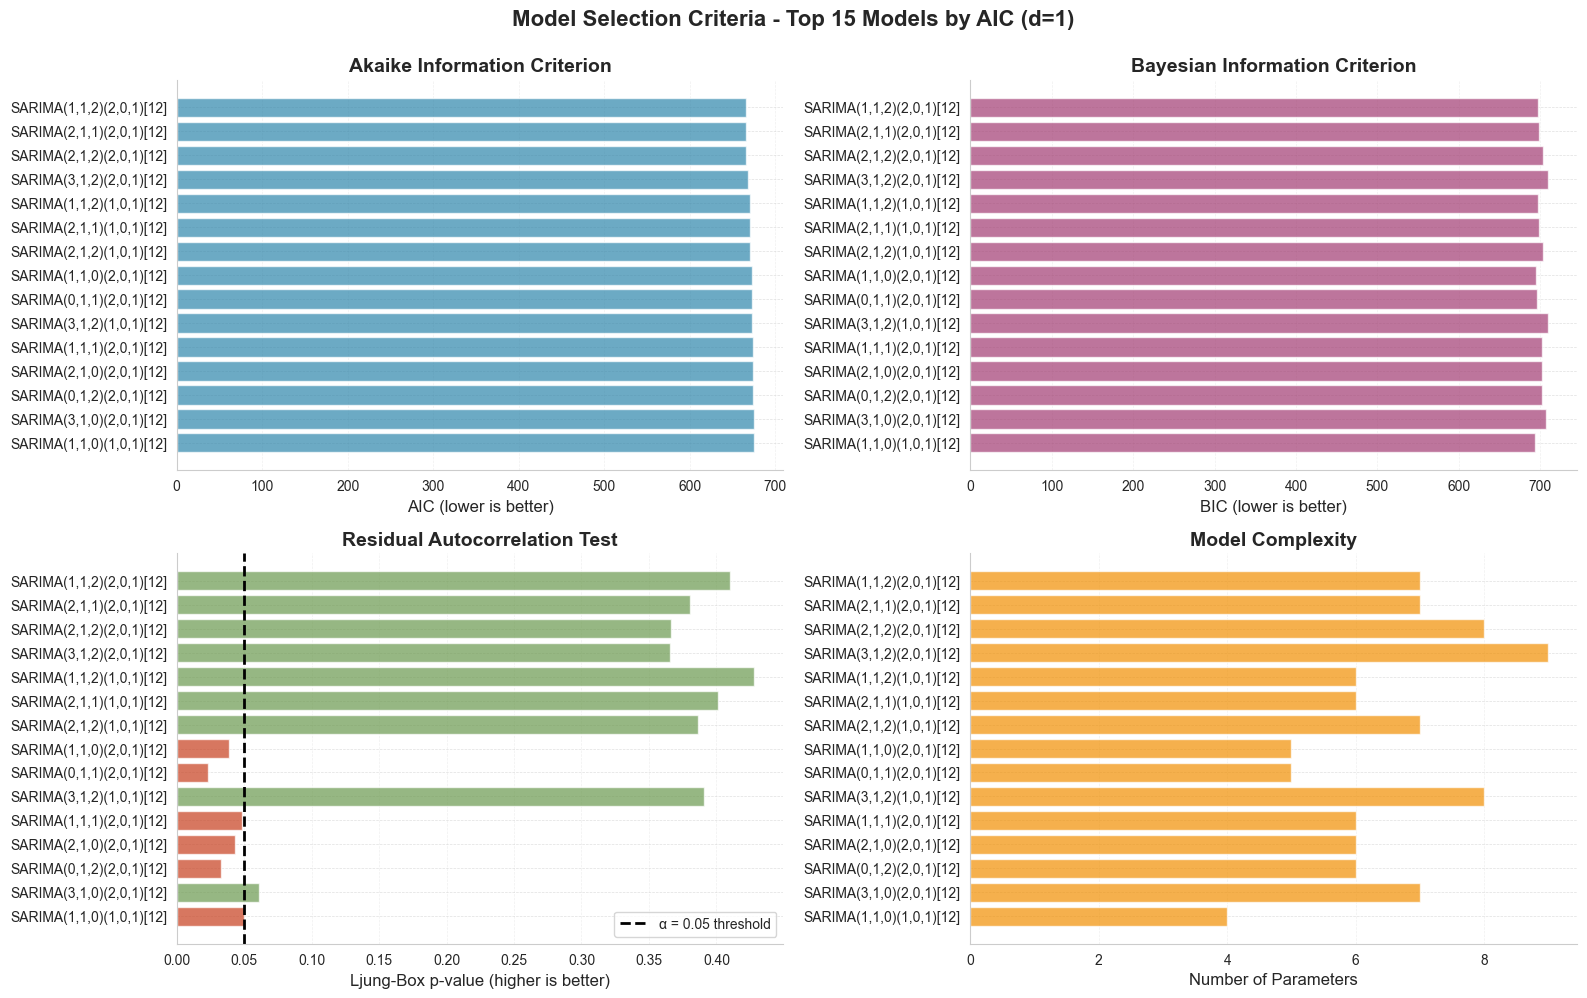

In [46]:
plot_model_selection(comparison_table, top_n=15)

In [47]:
horizons = [3, 6, 12, 18, 24]

In [48]:
top_models_for_testing = comparison_table[
    (comparison_table['Converged'] == 'Yes') &
    (comparison_table['Ljung-Box (p)'] > 0.05)
].head(8)

models_to_compare_horizon = []
for _, row in top_models_for_testing.iterrows():
    models_to_compare_horizon.append({
        'order': row['Order'],
        'seasonal': row['Seasonal'],
        'name': row['Model']
    })

print(f"Testing {len(models_to_compare_horizon)} models across {len(horizons)} horizons...")
print("Models:", [m['name'] for m in models_to_compare_horizon])

# %%
horizon_results = []

Testing 8 models across 5 horizons...
Models: ['SARIMA(1,1,2)(2,0,1)[12]', 'SARIMA(2,1,1)(2,0,1)[12]', 'SARIMA(2,1,2)(2,0,1)[12]', 'SARIMA(3,1,2)(2,0,1)[12]', 'SARIMA(1,1,2)(1,0,1)[12]', 'SARIMA(2,1,1)(1,0,1)[12]', 'SARIMA(2,1,2)(1,0,1)[12]', 'SARIMA(3,1,2)(1,0,1)[12]']


In [49]:
for h in horizons:
    train_data_h = yoy_change[:-h]
    test_data_h = yoy_change[-h:]
    
    # Naive baseline (last year's value)
    naive_pred_h = yoy_change.shift(12)[-h:].values
    naive_rmse_h = np.sqrt(mean_squared_error(test_data_h.values, naive_pred_h))
    naive_r2_h = r2_score(test_data_h.values, naive_pred_h)
    
    horizon_results.append({
        'Horizon': h,
        'Model': 'Naive',
        'RMSE': naive_rmse_h,
        'R2': naive_r2_h,
        'MAE': mean_absolute_error(test_data_h.values, naive_pred_h)
    })
    
    # Test each SARIMA model
    for model_spec in models_to_compare_horizon:
        try:
            model = SARIMAX(train_data_h, 
                           order=model_spec['order'], 
                           seasonal_order=model_spec['seasonal'])
            result = model.fit(disp=False)
            forecast = result.forecast(steps=h)
            
            rmse = np.sqrt(mean_squared_error(test_data_h.values, forecast.values))
            r2 = r2_score(test_data_h.values, forecast.values)
            mae = mean_absolute_error(test_data_h.values, forecast.values)
            
            horizon_results.append({
                'Horizon': h,
                'Model': model_spec['name'],
                'RMSE': rmse,
                'R2': r2,
                'MAE': mae
            })
        except Exception as e:
            print(f"Failed: {model_spec['name']} at horizon {h}")

horizon_df = pd.DataFrame(horizon_results)

In [50]:
rmse_pivot = horizon_df.pivot(index='Model', columns='Horizon', values='RMSE')
r2_pivot = horizon_df.pivot(index='Model', columns='Horizon', values='R2')

print("="*80)
print("RMSE BY FORECAST HORIZON (d=1 Models)")
print("="*80)
print(rmse_pivot.round(4).to_string())

print("\n" + "="*80)
print("R² BY FORECAST HORIZON (d=1 Models)")
print("="*80)
print(r2_pivot.round(4).to_string())


RMSE BY FORECAST HORIZON (d=1 Models)
Horizon                       3       6       12      18      24
Model                                                           
Naive                     0.3392  0.6132  0.5107  0.5040  1.3322
SARIMA(1,1,2)(1,0,1)[12]  0.0571  0.3210  0.1697  0.7825  0.7807
SARIMA(1,1,2)(2,0,1)[12]  0.0950  0.3457  0.1944  0.7252  0.6339
SARIMA(2,1,1)(1,0,1)[12]  0.0573  0.3218  0.1696  0.7822  0.7799
SARIMA(2,1,1)(2,0,1)[12]  0.0957  0.3464  0.1936  0.7256  0.6330
SARIMA(2,1,2)(1,0,1)[12]  0.0586  0.3217  0.1623  0.7714  0.7673
SARIMA(2,1,2)(2,0,1)[12]  0.0952  0.3450  0.1861  0.7188  0.6274
SARIMA(3,1,2)(1,0,1)[12]  0.0588  0.3217  0.1607  0.7724  0.7756
SARIMA(3,1,2)(2,0,1)[12]  0.0947  0.3452  0.1842  0.7170  0.6264

R² BY FORECAST HORIZON (d=1 Models)
Horizon                       3       6       12      18       24
Model                                                            
Naive                    -7.3407 -5.6833 -3.5486 -1.7515 -22.6306
SARIMA(1,1,2

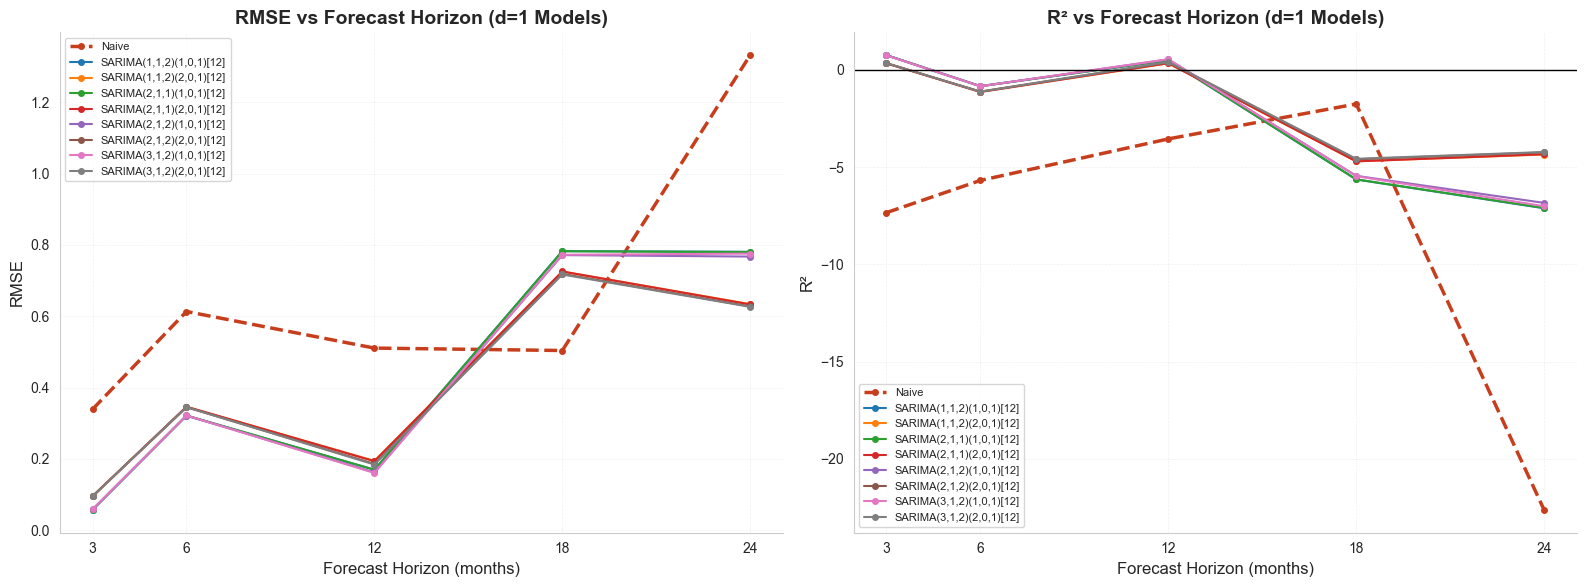

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE across horizons
for model in rmse_pivot.index:
    style = '--' if model == 'Naive' else '-'
    linewidth = 2.5 if model == 'Naive' else 1.5
    color = COLORS['naive'] if model == 'Naive' else None
    axes[0].plot(horizons, rmse_pivot.loc[model], marker='o', label=model, 
                 linestyle=style, linewidth=linewidth, color=color)

axes[0].set_xlabel('Forecast Horizon (months)', fontsize=12)
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].set_title('RMSE vs Forecast Horizon (d=1 Models)', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=8)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(horizons)

# R² across horizons
for model in r2_pivot.index:
    style = '--' if model == 'Naive' else '-'
    linewidth = 2.5 if model == 'Naive' else 1.5
    color = COLORS['naive'] if model == 'Naive' else None
    axes[1].plot(horizons, r2_pivot.loc[model], marker='o', label=model,
                 linestyle=style, linewidth=linewidth, color=color)

axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('Forecast Horizon (months)', fontsize=12)
axes[1].set_ylabel('R²', fontsize=12)
axes[1].set_title('R² vs Forecast Horizon (d=1 Models)', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=8)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(horizons)

plt.tight_layout()
plt.show()

In [52]:
# horizon_df

In [53]:
print("\n" + "="*80)
print("BEST MODEL AT EACH HORIZON (d=1)")
print("="*80)

best_at_horizon = {}
for h in horizons:
    subset = horizon_df[(horizon_df['Horizon'] == h) & (horizon_df['Model'] != 'Naive')]
    if len(subset) > 0:
        best = subset.loc[subset['RMSE'].idxmin()]
        naive_rmse_h = horizon_df[(horizon_df['Horizon'] == h) & (horizon_df['Model'] == 'Naive')]['RMSE'].values[0]
        improvement = ((naive_rmse_h - best['RMSE']) / naive_rmse_h) * 100
        best_at_horizon[h] = best['Model']
        print(f"{h:2d} months: {best['Model']:<35} RMSE: {best['RMSE']:.4f} | {improvement:.1f}% better than Naive")



BEST MODEL AT EACH HORIZON (d=1)
 3 months: SARIMA(1,1,2)(1,0,1)[12]            RMSE: 0.0571 | 83.2% better than Naive
 6 months: SARIMA(1,1,2)(1,0,1)[12]            RMSE: 0.3210 | 47.6% better than Naive
12 months: SARIMA(3,1,2)(1,0,1)[12]            RMSE: 0.1607 | 68.5% better than Naive
18 months: SARIMA(3,1,2)(2,0,1)[12]            RMSE: 0.7170 | -42.3% better than Naive
24 months: SARIMA(3,1,2)(2,0,1)[12]            RMSE: 0.6264 | 53.0% better than Naive


In [54]:
key_horizons = [6, 12]
avg_rmse_by_model = horizon_df[
    (horizon_df['Horizon'].isin(key_horizons)) & 
    (horizon_df['Model'] != 'Naive')
].groupby('Model')['RMSE'].mean().sort_values()

best_rmse_model_name = avg_rmse_by_model.index[0]
print(f"\n" + "="*70)
print(f"BEST MODEL BY AVERAGE RMSE (6-12 month horizons): {best_rmse_model_name}")
print(f"="*70)
print(f"Average RMSE: {avg_rmse_by_model.iloc[0]:.4f}")


BEST MODEL BY AVERAGE RMSE (6-12 month horizons): SARIMA(3,1,2)(1,0,1)[12]
Average RMSE: 0.2412


In [55]:
best_rmse_row = comparison_table[comparison_table['Model'] == best_rmse_model_name].iloc[0]

# Update configuration if different
if best_rmse_model_name != BEST_RMSE_MODEL['name']:
    print(f"\nNote: Multi-horizon evaluation found {best_rmse_model_name} as best RMSE model.")
    print(f"      Configuration has {BEST_RMSE_MODEL['name']}.")

In [56]:
print("="*70)
print(f"BEST AIC MODEL: {BEST_AIC_MODEL['name']}")
print("="*70)

model_best_aic = SARIMAX(yoy_change, 
                         order=BEST_AIC_MODEL['order'], 
                         seasonal_order=BEST_AIC_MODEL['seasonal_order'])
result_best_aic = model_best_aic.fit(disp=False)
print(result_best_aic.summary())

BEST AIC MODEL: SARIMA(1,1,2)(2,0,1)[12]
                                      SARIMAX Results                                       
Dep. Variable:                           YoY_Change   No. Observations:                  728
Model:             SARIMAX(1, 1, 2)x(2, 0, [1], 12)   Log Likelihood                -325.767
Date:                              Sun, 07 Dec 2025   AIC                            665.534
Time:                                      15:29:16   BIC                            697.657
Sample:                                  01-01-1965   HQIC                           677.929
                                       - 08-01-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9624      0.037     25.731      0.000   

In [57]:
print("\n" + "="*70)
print(f"BEST RMSE MODEL: {BEST_RMSE_MODEL['name']}")
print("="*70)

model_best_rmse = SARIMAX(yoy_change, 
                          order=BEST_RMSE_MODEL['order'], 
                          seasonal_order=BEST_RMSE_MODEL['seasonal_order'])
result_best_rmse = model_best_rmse.fit(disp=False)
print(result_best_rmse.summary())



BEST RMSE MODEL: SARIMA(3,1,2)(1,0,1)[12]
                                      SARIMAX Results                                       
Dep. Variable:                           YoY_Change   No. Observations:                  728
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -328.525
Date:                              Sun, 07 Dec 2025   AIC                            673.049
Time:                                      15:29:19   BIC                            709.761
Sample:                                  01-01-1965   HQIC                           687.216
                                       - 08-01-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4430      0.563      0.786      0.432 

In [58]:
def plot_residual_diagnostics(result, model_name):
    """Plot comprehensive residual diagnostics for a fitted model"""
    residuals = result.resid
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Residual Diagnostics - {model_name}',
                 fontsize=16, fontweight='bold', y=1.00)

    # Residuals over time
    axes[0, 0].plot(residuals.index, residuals.values,
                    color='#2E86AB', linewidth=1, alpha=0.7)
    axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    axes[0, 0].set_title('Residuals Over Time', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Date', fontsize=12)
    axes[0, 0].set_ylabel('Residuals', fontsize=12)
    axes[0, 0].grid(True, alpha=0.3)

    # Histogram
    axes[0, 1].hist(residuals.dropna(), bins=30, color='#A23B72',
                    edgecolor='white', alpha=0.7, density=True)
    # Overlay normal distribution
    x = np.linspace(residuals.min(), residuals.max(), 100)
    axes[0, 1].plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()),
                    'k-', linewidth=2, label='Normal')
    axes[0, 1].set_title('Residual Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Residuals', fontsize=12)
    axes[0, 1].set_ylabel('Density', fontsize=12)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # ACF of residuals
    plot_acf(residuals.dropna(), ax=axes[1, 0], lags=40, alpha=0.05)
    axes[1, 0].set_title('ACF of Residuals', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Lag', fontsize=12)
    axes[1, 0].set_ylabel('Autocorrelation', fontsize=12)

    # PACF of residuals
    plot_pacf(residuals.dropna(), ax=axes[1, 1], lags=40, alpha=0.05)
    axes[1, 1].set_title('PACF of Residuals', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Lag', fontsize=12)
    axes[1, 1].set_ylabel('Partial Autocorrelation', fontsize=12)

    plt.tight_layout()
    plt.show()
    
    # Ljung-Box test
    lb_test = acorr_ljungbox(residuals.dropna(), lags=[10, 20, 30], return_df=True)
    print(f"\nLjung-Box Test Results for {model_name}:")
    print(lb_test)
    print("\nInterpretation: p-values > 0.05 indicate no significant autocorrelation (good)")

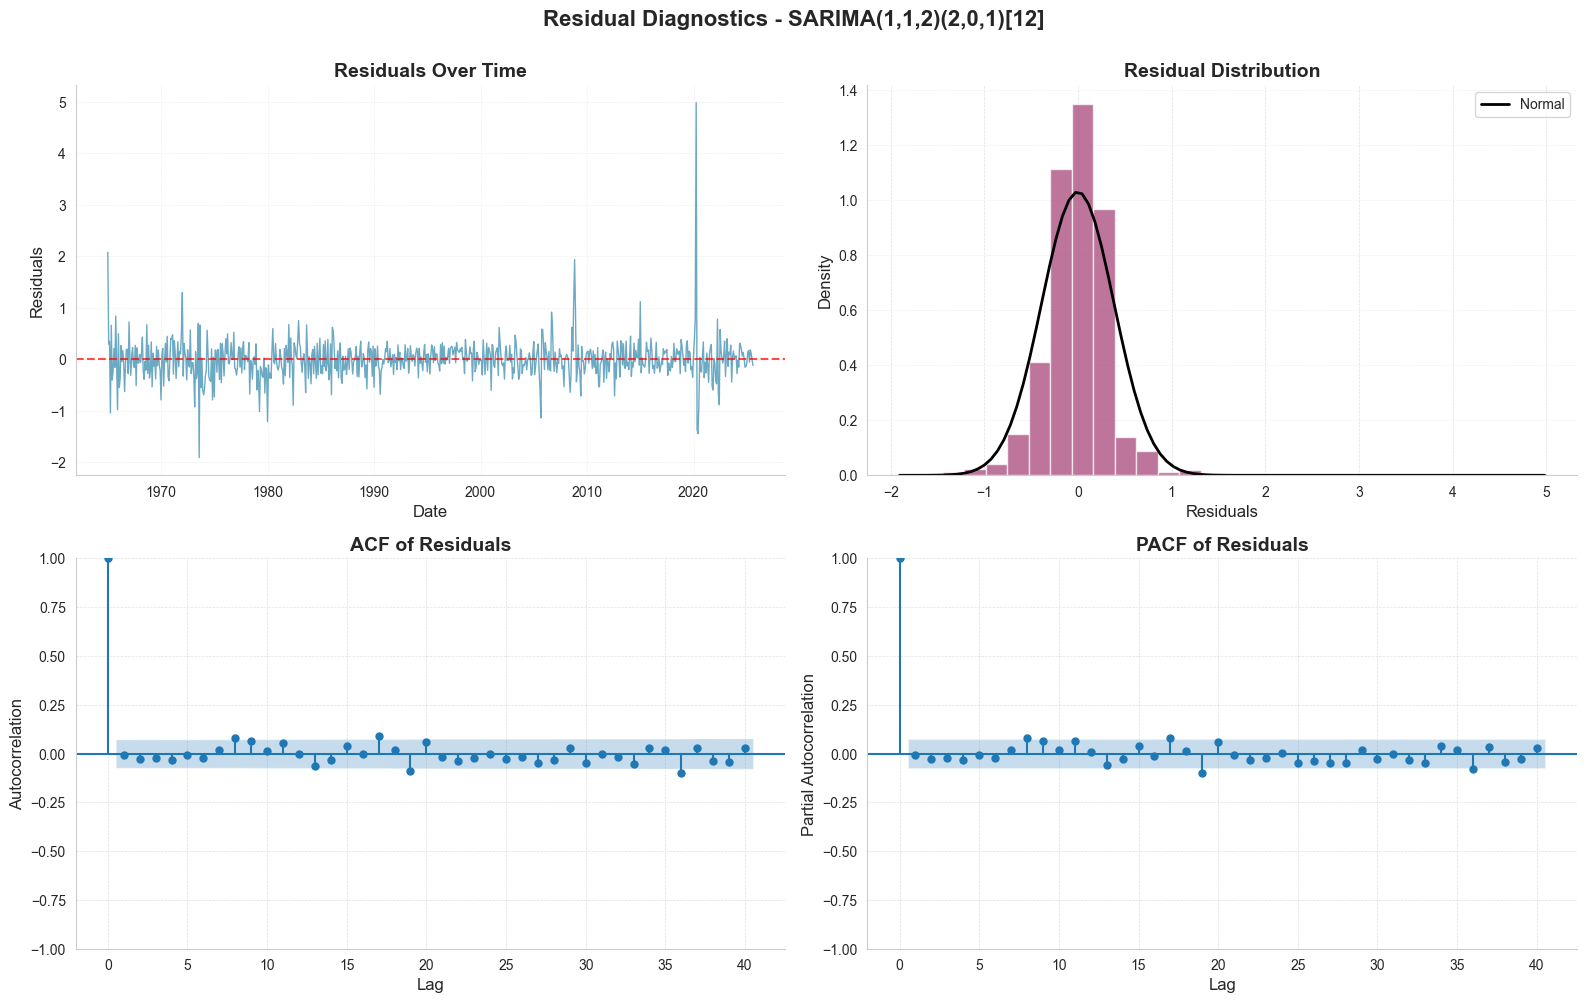


Ljung-Box Test Results for SARIMA(1,1,2)(2,0,1)[12]:
      lb_stat  lb_pvalue
10  10.355921   0.409841
20  32.633418   0.036999
30  39.902337   0.106770

Interpretation: p-values > 0.05 indicate no significant autocorrelation (good)


In [59]:
plot_residual_diagnostics(result_best_aic, BEST_AIC_MODEL['name'])

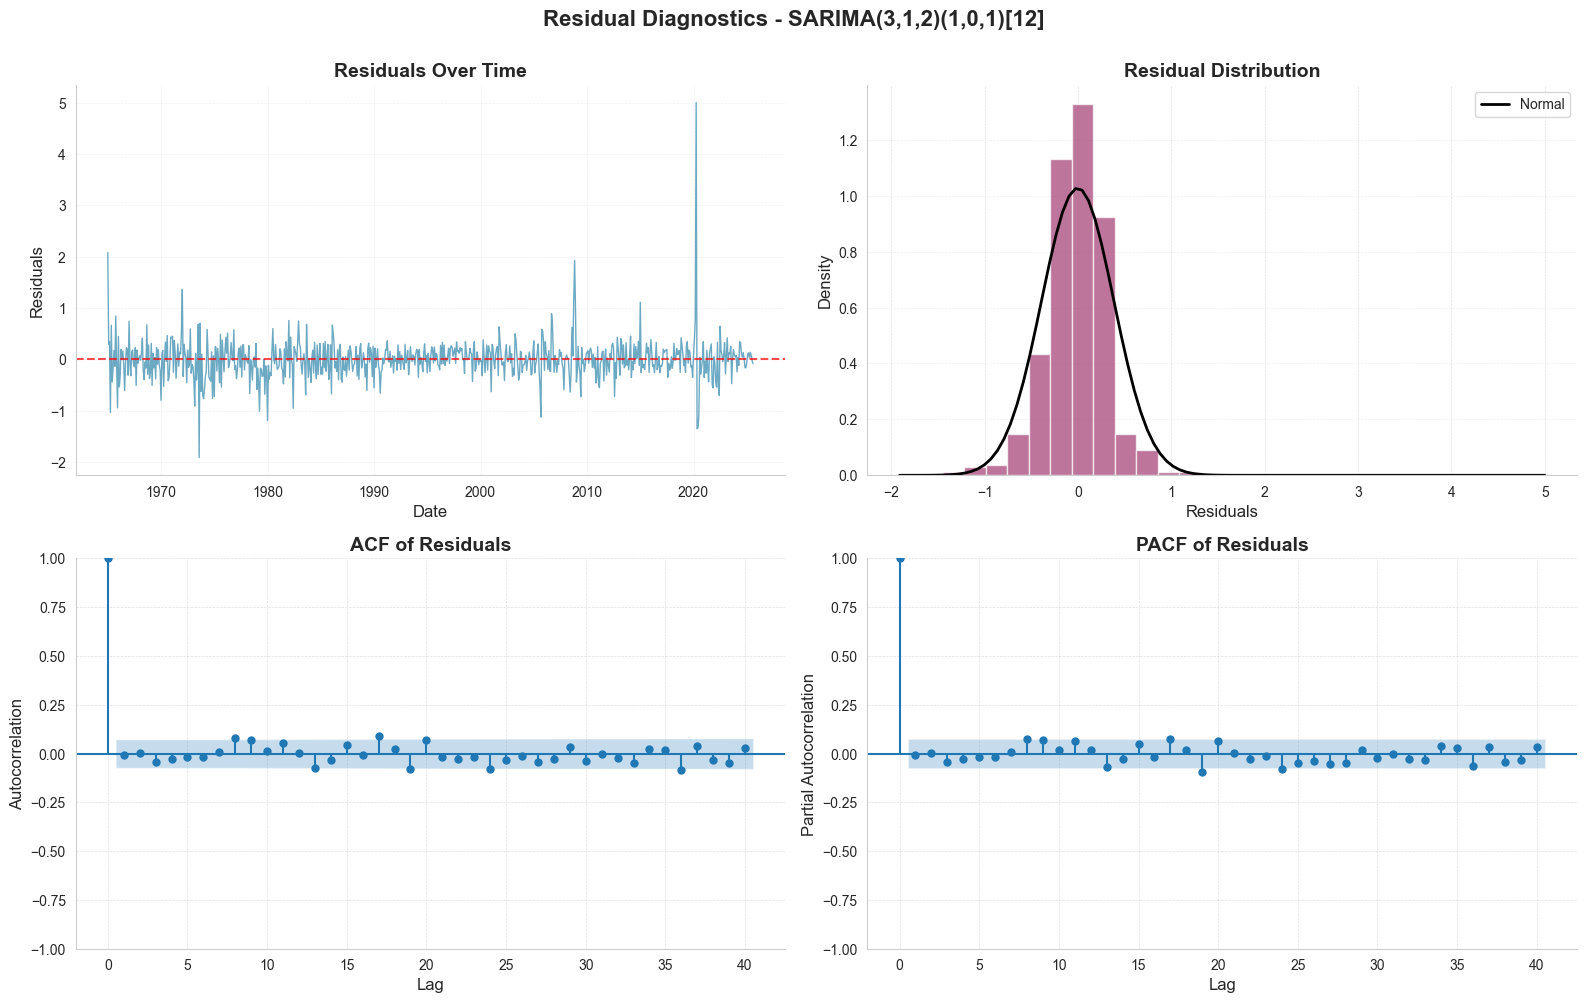


Ljung-Box Test Results for SARIMA(3,1,2)(1,0,1)[12]:
      lb_stat  lb_pvalue
10  10.595903   0.389854
20  33.749463   0.027870
30  44.216983   0.045575

Interpretation: p-values > 0.05 indicate no significant autocorrelation (good)


In [60]:
plot_residual_diagnostics(result_best_rmse, BEST_RMSE_MODEL['name'])

In [61]:
lb_test_full = acorr_ljungbox(result_best_aic.resid.dropna(), lags=range(1, 31), return_df=True)

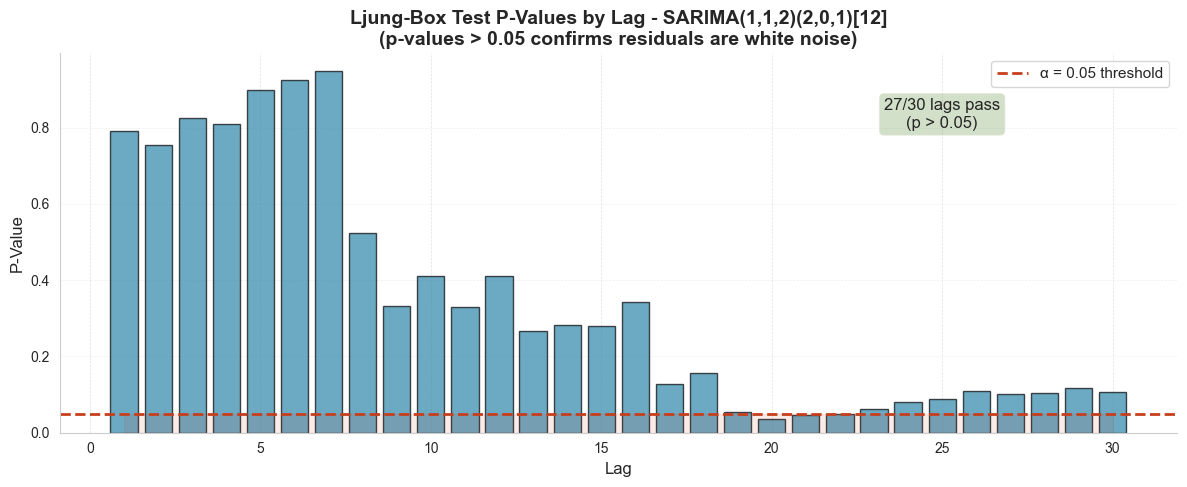

In [62]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.bar(lb_test_full.index, lb_test_full['lb_pvalue'], color='#2E86AB', alpha=0.7, edgecolor='black')
ax.axhline(y=0.05, color='#C73E1D', linestyle='--', linewidth=2, label='α = 0.05 threshold')
ax.fill_between(lb_test_full.index, 0, 0.05, color='#C73E1D', alpha=0.1)

ax.set_xlabel('Lag', fontsize=12)
ax.set_ylabel('P-Value', fontsize=12)
ax.set_title(f'Ljung-Box Test P-Values by Lag - {BEST_AIC_MODEL["name"]}\n(p-values > 0.05 confirms residuals are white noise)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(range(0, 31, 5))

passing_lags = (lb_test_full['lb_pvalue'] > 0.05).sum()
total_lags = len(lb_test_full)
ax.annotate(f'{passing_lags}/{total_lags} lags pass\n(p > 0.05)',
            xy=(25, 0.8), fontsize=12, ha='center',
            bbox=dict(boxstyle='round', facecolor='#6A994E', alpha=0.3))

plt.tight_layout()
plt.show()

In [63]:
models_to_compare_test = [
    {'order': BEST_AIC_MODEL['order'], 'seasonal': BEST_AIC_MODEL['seasonal_order'], 
     'name': BEST_AIC_MODEL['name'], 'label': 'Best AIC'},
    {'order': BEST_RMSE_MODEL['order'], 'seasonal': BEST_RMSE_MODEL['seasonal_order'], 
     'name': BEST_RMSE_MODEL['name'], 'label': 'Best RMSE'},
]

In [64]:
for _, row in comparison_table[comparison_table['Converged'] == 'Yes'].head(10).iterrows():
    if row['Model'] not in [BEST_AIC_MODEL['name'], BEST_RMSE_MODEL['name']]:
        models_to_compare_test.append({
            'order': row['Order'],
            'seasonal': row['Seasonal'],
            'name': row['Model'],
            'label': 'Other'
        })
        if len(models_to_compare_test) >= 8:
            break

In [65]:
model_comparison_results = []

train_data = yoy_change[:-TEST_SIZE]
test_data = yoy_change[-TEST_SIZE:]

print("="*80)
print(f"MODEL COMPARISON: OUT-OF-SAMPLE TEST ({TEST_SIZE}-MONTH HORIZON)")
print("="*80)
print(f"Training: {train_data.index[0].strftime('%Y-%m')} to {train_data.index[-1].strftime('%Y-%m')}")
print(f"Test: {test_data.index[0].strftime('%Y-%m')} to {test_data.index[-1].strftime('%Y-%m')}")
print("="*80)

MODEL COMPARISON: OUT-OF-SAMPLE TEST (12-MONTH HORIZON)
Training: 1965-01 to 2024-08
Test: 2024-09 to 2025-08


In [66]:
naive_predictions = yoy_change.shift(12)[-TEST_SIZE:].values
naive_mae = mean_absolute_error(test_data.values, naive_predictions)
naive_rmse = np.sqrt(mean_squared_error(test_data.values, naive_predictions))
naive_r2 = r2_score(test_data.values, naive_predictions)

model_comparison_results.append({
    'Model': 'Naive (Last Year)',
    'Label': 'Baseline',
    'AIC': np.nan,
    'Params': 0,
    'MAE': naive_mae,
    'RMSE': naive_rmse,
    'R2': naive_r2
})

print(f"{'Naive (Last Year)':<40} RMSE: {naive_rmse:.4f} | MAE: {naive_mae:.4f} | R²: {naive_r2:.4f}")


Naive (Last Year)                        RMSE: 0.5107 | MAE: 0.4126 | R²: -3.5486


In [67]:
for model_spec in models_to_compare_test:
    try:
        model = SARIMAX(train_data, 
                        order=model_spec['order'], 
                        seasonal_order=model_spec['seasonal'])
        result = model.fit(disp=False)
        forecast = result.forecast(steps=TEST_SIZE)
        
        mae = mean_absolute_error(test_data.values, forecast.values)
        rmse = np.sqrt(mean_squared_error(test_data.values, forecast.values))
        r2 = r2_score(test_data.values, forecast.values)
        aic = result.aic
        n_params = len(result.params)
        
        model_comparison_results.append({
            'Model': model_spec['name'],
            'Label': model_spec['label'],
            'AIC': aic,
            'Params': n_params,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        })
        
        marker = "★" if model_spec['label'] in ['Best AIC', 'Best RMSE'] else " "
        print(f"{marker} {model_spec['name']:<38} RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")
        
    except Exception as e:
        print(f"  {model_spec['name']:<38} FAILED: {str(e)[:40]}")



★ SARIMA(1,1,2)(2,0,1)[12]               RMSE: 0.1944 | MAE: 0.1635 | R²: 0.3408
★ SARIMA(3,1,2)(1,0,1)[12]               RMSE: 0.1607 | MAE: 0.1398 | R²: 0.5498
  SARIMA(2,1,1)(2,0,1)[12]               RMSE: 0.1936 | MAE: 0.1627 | R²: 0.3460
  SARIMA(2,1,2)(2,0,1)[12]               RMSE: 0.1861 | MAE: 0.1581 | R²: 0.3961
  SARIMA(3,1,2)(2,0,1)[12]               RMSE: 0.1842 | MAE: 0.1568 | R²: 0.4082
  SARIMA(1,1,2)(1,0,1)[12]               RMSE: 0.1697 | MAE: 0.1463 | R²: 0.4976
  SARIMA(2,1,1)(1,0,1)[12]               RMSE: 0.1696 | MAE: 0.1462 | R²: 0.4981
  SARIMA(2,1,2)(1,0,1)[12]               RMSE: 0.1623 | MAE: 0.1403 | R²: 0.5408


In [68]:
comparison_results_df = pd.DataFrame(model_comparison_results)
comparison_results_df = comparison_results_df.sort_values('RMSE').reset_index(drop=True)
comparison_results_df['Rank'] = range(1, len(comparison_results_df) + 1)
comparison_results_df = comparison_results_df[['Rank', 'Model', 'Label', 'AIC', 'Params', 'MAE', 'RMSE', 'R2']]

In [69]:
print("\n" + "="*80)
print(f"RESULTS RANKED BY TEST RMSE ({TEST_SIZE}-MONTH HORIZON)")
print("="*80)
print(comparison_results_df.to_string(index=False))

# %%
# Calculate improvement over Naive
print("\n" + "="*80)
print("IMPROVEMENT OVER NAIVE BASELINE")
print("="*80)
for _, row in comparison_results_df.iterrows():
    if row['Model'] != 'Naive (Last Year)':
        improvement = ((naive_rmse - row['RMSE']) / naive_rmse) * 100
        status = "✓ Better" if improvement > 0 else "✗ Worse"
        marker = "★" if row['Label'] in ['Best AIC', 'Best RMSE'] else " "
        print(f"{marker} {row['Model']:<38} {status} by {abs(improvement):.1f}%")
    


RESULTS RANKED BY TEST RMSE (12-MONTH HORIZON)
 Rank                    Model     Label        AIC  Params      MAE     RMSE        R2
    1 SARIMA(3,1,2)(1,0,1)[12] Best RMSE 673.769262       8 0.139776 0.160676  0.549774
    2 SARIMA(2,1,2)(1,0,1)[12]     Other 671.649970       7 0.140308 0.162267  0.540815
    3 SARIMA(2,1,1)(1,0,1)[12]     Other 671.334447       6 0.146159 0.169645  0.498112
    4 SARIMA(1,1,2)(1,0,1)[12]     Other 670.898763       6 0.146271 0.169740  0.497550
    5 SARIMA(3,1,2)(2,0,1)[12]     Other 668.738650       9 0.156802 0.184220  0.408165
    6 SARIMA(2,1,2)(2,0,1)[12]     Other 666.735349       8 0.158149 0.186095  0.396058
    7 SARIMA(2,1,1)(2,0,1)[12]     Other 666.348449       7 0.162680 0.193648  0.346036
    8 SARIMA(1,1,2)(2,0,1)[12]  Best AIC 665.883568       7 0.163523 0.194420  0.340811
    9        Naive (Last Year)  Baseline        NaN       0 0.412627 0.510711 -3.548588

IMPROVEMENT OVER NAIVE BASELINE
★ SARIMA(3,1,2)(1,0,1)[12]             

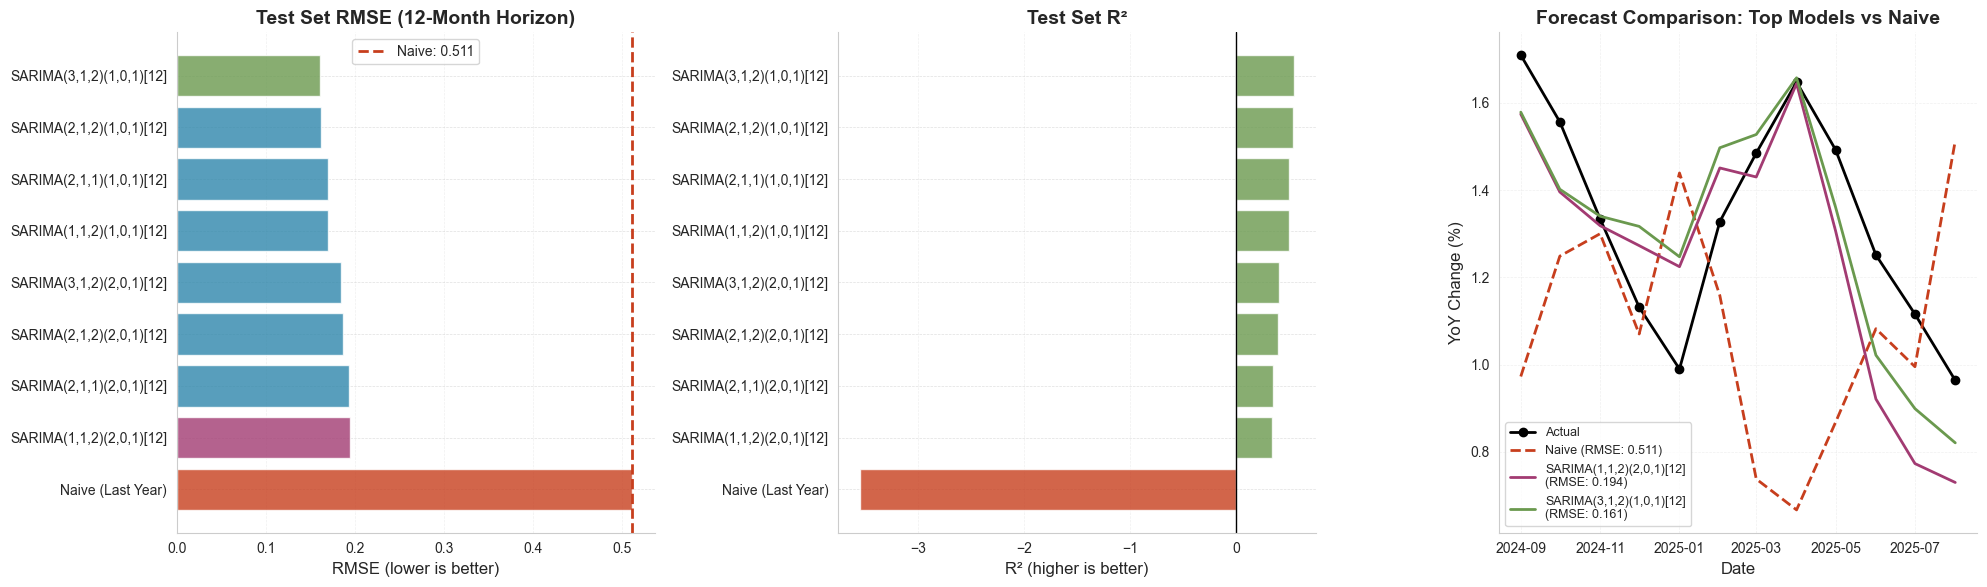

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

models_sorted = comparison_results_df['Model'].tolist()

# Color based on model type
def get_color(model_name, label):
    if 'Naive' in model_name:
        return COLORS['naive']
    elif label == 'Best AIC':
        return COLORS['best_aic']
    elif label == 'Best RMSE':
        return COLORS['best_rmse']
    else:
        return '#2E86AB'

colors = [get_color(m, comparison_results_df[comparison_results_df['Model']==m]['Label'].values[0]) 
          for m in models_sorted]

# RMSE comparison
axes[0].barh(models_sorted, comparison_results_df['RMSE'], color=colors, alpha=0.8)
axes[0].axvline(x=naive_rmse, color=COLORS['naive'], linestyle='--', linewidth=2, 
                label=f'Naive: {naive_rmse:.3f}')
axes[0].set_xlabel('RMSE (lower is better)', fontsize=12)
axes[0].set_title(f'Test Set RMSE ({TEST_SIZE}-Month Horizon)', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='x')

# R² comparison
colors_r2 = ['#6A994E' if r > 0 else '#C73E1D' for r in comparison_results_df['R2']]
axes[1].barh(models_sorted, comparison_results_df['R2'], color=colors_r2, alpha=0.8)
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('R² (higher is better)', fontsize=12)
axes[1].set_title('Test Set R²', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

# Forecast visualization for top 2 models
axes[2].plot(test_data.index, test_data.values, 'ko-', label='Actual', linewidth=2, markersize=6)
axes[2].plot(test_data.index, naive_predictions, color=COLORS['naive'], linestyle='--', 
             label=f'Naive (RMSE: {naive_rmse:.3f})', linewidth=2)

# Plot Best AIC model forecast
model_aic = SARIMAX(train_data, order=BEST_AIC_MODEL['order'], seasonal_order=BEST_AIC_MODEL['seasonal_order'])
result_aic = model_aic.fit(disp=False)
forecast_aic = result_aic.forecast(steps=TEST_SIZE)
rmse_aic = np.sqrt(mean_squared_error(test_data.values, forecast_aic.values))
axes[2].plot(test_data.index, forecast_aic.values, color=COLORS['best_aic'], 
             label=f'{BEST_AIC_MODEL["name"]}\n(RMSE: {rmse_aic:.3f})', linewidth=2)

# Plot Best RMSE model forecast
model_rmse = SARIMAX(train_data, order=BEST_RMSE_MODEL['order'], seasonal_order=BEST_RMSE_MODEL['seasonal_order'])
result_rmse = model_rmse.fit(disp=False)
forecast_rmse = result_rmse.forecast(steps=TEST_SIZE)
rmse_rmse_val = np.sqrt(mean_squared_error(test_data.values, forecast_rmse.values))
axes[2].plot(test_data.index, forecast_rmse.values, color=COLORS['best_rmse'], 
             label=f'{BEST_RMSE_MODEL["name"]}\n(RMSE: {rmse_rmse_val:.3f})', linewidth=2)

axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('YoY Change (%)', fontsize=12)
axes[2].set_title('Forecast Comparison: Top Models vs Naive', fontsize=14, fontweight='bold')
axes[2].legend(loc='best', fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [71]:
test_size_viz = TEST_SIZE
train_data_viz = yoy_change[:-test_size_viz]
test_data_viz = yoy_change[-test_size_viz:]


In [72]:
models_to_plot = [
    {'order': BEST_AIC_MODEL['order'], 'seasonal': BEST_AIC_MODEL['seasonal_order'], 
     'name': BEST_AIC_MODEL['name'], 'color': COLORS['best_aic']},
    {'order': BEST_RMSE_MODEL['order'], 'seasonal': BEST_RMSE_MODEL['seasonal_order'], 
     'name': BEST_RMSE_MODEL['name'], 'color': COLORS['best_rmse']},
]

# Add a few more from grid search
other_colors = ['#F18F01', '#7B2D8E', '#00CED1']
color_idx = 0
for _, row in comparison_table[comparison_table['Converged'] == 'Yes'].head(10).iterrows():
    if row['Model'] not in [BEST_AIC_MODEL['name'], BEST_RMSE_MODEL['name']]:
        models_to_plot.append({
            'order': row['Order'],
            'seasonal': row['Seasonal'],
            'name': row['Model'],
            'color': other_colors[color_idx % len(other_colors)]
        })
        color_idx += 1
        if len(models_to_plot) >= 5:
            break



In [73]:
naive_pred = yoy_change.shift(12)[-test_size_viz:].values
naive_rmse_viz = np.sqrt(mean_squared_error(test_data_viz.values, naive_pred))


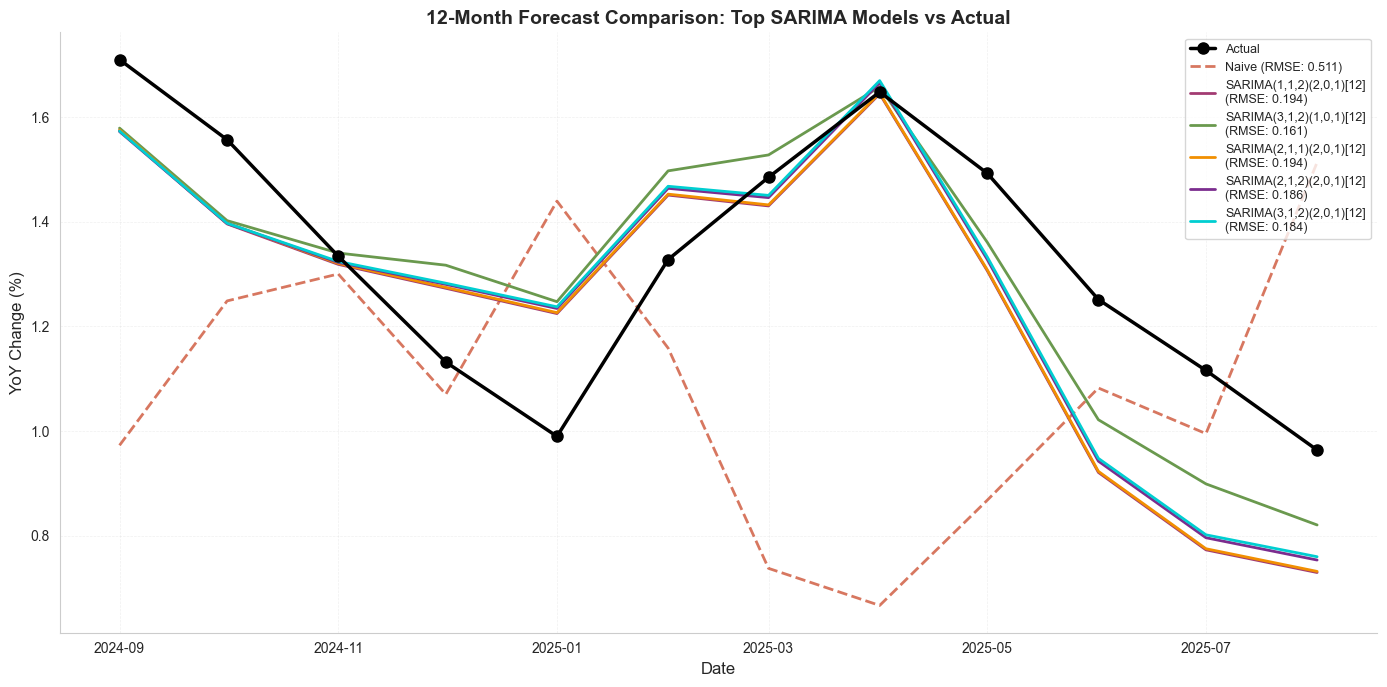

In [74]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(test_data_viz.index, test_data_viz.values, 'ko-', label='Actual', 
        linewidth=2.5, markersize=8, zorder=10)
ax.plot(test_data_viz.index, naive_pred, color=COLORS['naive'], linestyle='--', 
        label=f'Naive (RMSE: {naive_rmse_viz:.3f})', linewidth=2, alpha=0.7)

for model_spec in models_to_plot:
    try:
        model = SARIMAX(train_data_viz, order=model_spec['order'], seasonal_order=model_spec['seasonal'])
        result = model.fit(disp=False)
        forecast = result.forecast(steps=test_size_viz)
        
        rmse = np.sqrt(mean_squared_error(test_data_viz.values, forecast.values))
        
        ax.plot(test_data_viz.index, forecast.values, 
                color=model_spec['color'], 
                linewidth=2, 
                label=f"{model_spec['name']}\n(RMSE: {rmse:.3f})")
    except Exception as e:
        print(f"{model_spec['name']} failed: {e}")

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('YoY Change (%)', fontsize=12)
ax.set_title(f'{TEST_SIZE}-Month Forecast Comparison: Top SARIMA Models vs Actual', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [75]:
test_size_6 = 6
train_data_6 = yoy_change[:-test_size_6]
test_data_6 = yoy_change[-test_size_6:]

naive_pred_6 = yoy_change.shift(12)[-test_size_6:].values
naive_rmse_6 = np.sqrt(mean_squared_error(test_data_6.values, naive_pred_6))


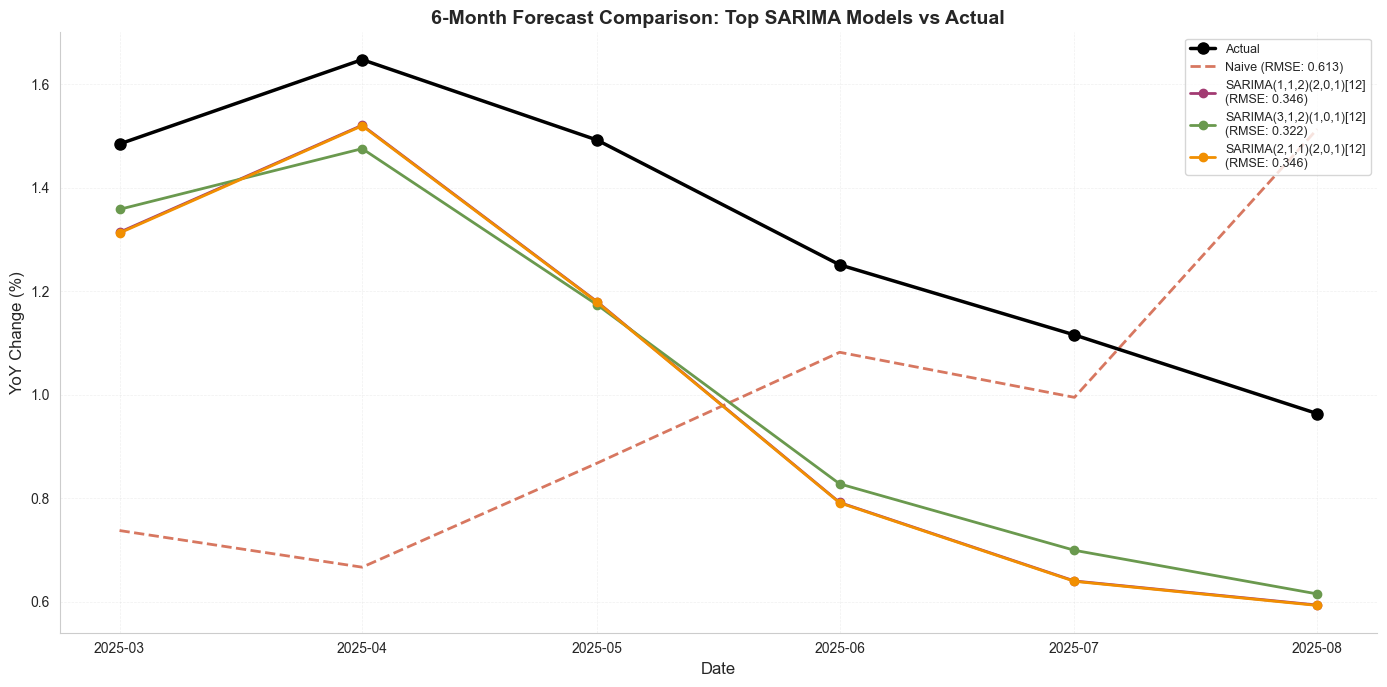

In [76]:

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(test_data_6.index, test_data_6.values, 'ko-', label='Actual', 
        linewidth=2.5, markersize=8, zorder=10)
ax.plot(test_data_6.index, naive_pred_6, color=COLORS['naive'], linestyle='--', 
        label=f'Naive (RMSE: {naive_rmse_6:.3f})', linewidth=2, alpha=0.7)

for model_spec in models_to_plot[:3]:  # Top 3 only for cleaner viz
    try:
        model = SARIMAX(train_data_6, order=model_spec['order'], seasonal_order=model_spec['seasonal'])
        result = model.fit(disp=False)
        forecast = result.forecast(steps=test_size_6)
        
        rmse = np.sqrt(mean_squared_error(test_data_6.values, forecast.values))
        
        ax.plot(test_data_6.index, forecast.values, 
                color=model_spec['color'], 
                linewidth=2, 
                marker='o',
                markersize=6,
                label=f"{model_spec['name']}\n(RMSE: {rmse:.3f})")
    except Exception as e:
        print(f"{model_spec['name']} failed: {e}")

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('YoY Change (%)', fontsize=12)
ax.set_title('6-Month Forecast Comparison: Top SARIMA Models vs Actual', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [77]:
FINAL_MODEL = BEST_AIC_MODEL  # Change to BEST_RMSE_MODEL if preferred

print("="*70)
print(f"FINAL FORECAST MODEL: {FINAL_MODEL['name']}")
print(f"Forecast Horizon: {FORECAST_HORIZON} months ({FORECAST_HORIZON//12} years)")
print("="*70)



FINAL FORECAST MODEL: SARIMA(1,1,2)(2,0,1)[12]
Forecast Horizon: 36 months (3 years)


In [78]:
model_final = SARIMAX(yoy_change, 
                      order=FINAL_MODEL['order'], 
                      seasonal_order=FINAL_MODEL['seasonal_order'])
result_final = model_final.fit(disp=False)



In [79]:
forecast_obj = result_final.get_forecast(steps=FORECAST_HORIZON)
yoy_forecast = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int()

print(f"\nForecast Summary (YoY Change %):")
print(f"  First month: {yoy_forecast.iloc[0]:.2f}%")
print(f"  Last month:  {yoy_forecast.iloc[-1]:.2f}%")
print(f"  Average:     {yoy_forecast.mean():.2f}%")




Forecast Summary (YoY Change %):
  First month: 0.81%
  Last month:  0.71%
  Average:     0.76%


In [80]:
forecast_wages = true_wages_clean.copy()

for i in range(FORECAST_HORIZON):
    forecast_date = true_wages_clean.index[-1] + pd.DateOffset(months=i+1)
    wages_12_month_early = forecast_wages.iloc[-12]
    forecast_wages.loc[forecast_date] = wages_12_month_early * (1 + yoy_forecast.iloc[i] / 100)



In [81]:
forecast_wages_lower = true_wages_clean.copy()
forecast_wages_upper = true_wages_clean.copy()


In [82]:
for i in range(FORECAST_HORIZON):
    forecast_date = true_wages_clean.index[-1] + pd.DateOffset(months=i+1)
    wages_12_month_early_lower = forecast_wages_lower.iloc[-12]
    wages_12_month_early_upper = forecast_wages_upper.iloc[-12]
    forecast_wages_lower.loc[forecast_date] = wages_12_month_early_lower * (1 + conf_int.iloc[i, 0] / 100)
    forecast_wages_upper.loc[forecast_date] = wages_12_month_early_upper * (1 + conf_int.iloc[i, 1] / 100)



In [83]:
connected_forecast = pd.concat([true_wages_clean.iloc[[-1]], forecast_wages[-FORECAST_HORIZON:]])

# CI starts from last historical point for smooth connection
last_hist_date = true_wages_clean.index[-1]
last_hist_value = true_wages_clean.iloc[-1]

ci_dates = [last_hist_date] + list(forecast_wages_lower[-FORECAST_HORIZON:].index)
ci_lower_values = [last_hist_value] + list(forecast_wages_lower[-FORECAST_HORIZON:].values)
ci_upper_values = [last_hist_value] + list(forecast_wages_upper[-FORECAST_HORIZON:].values)


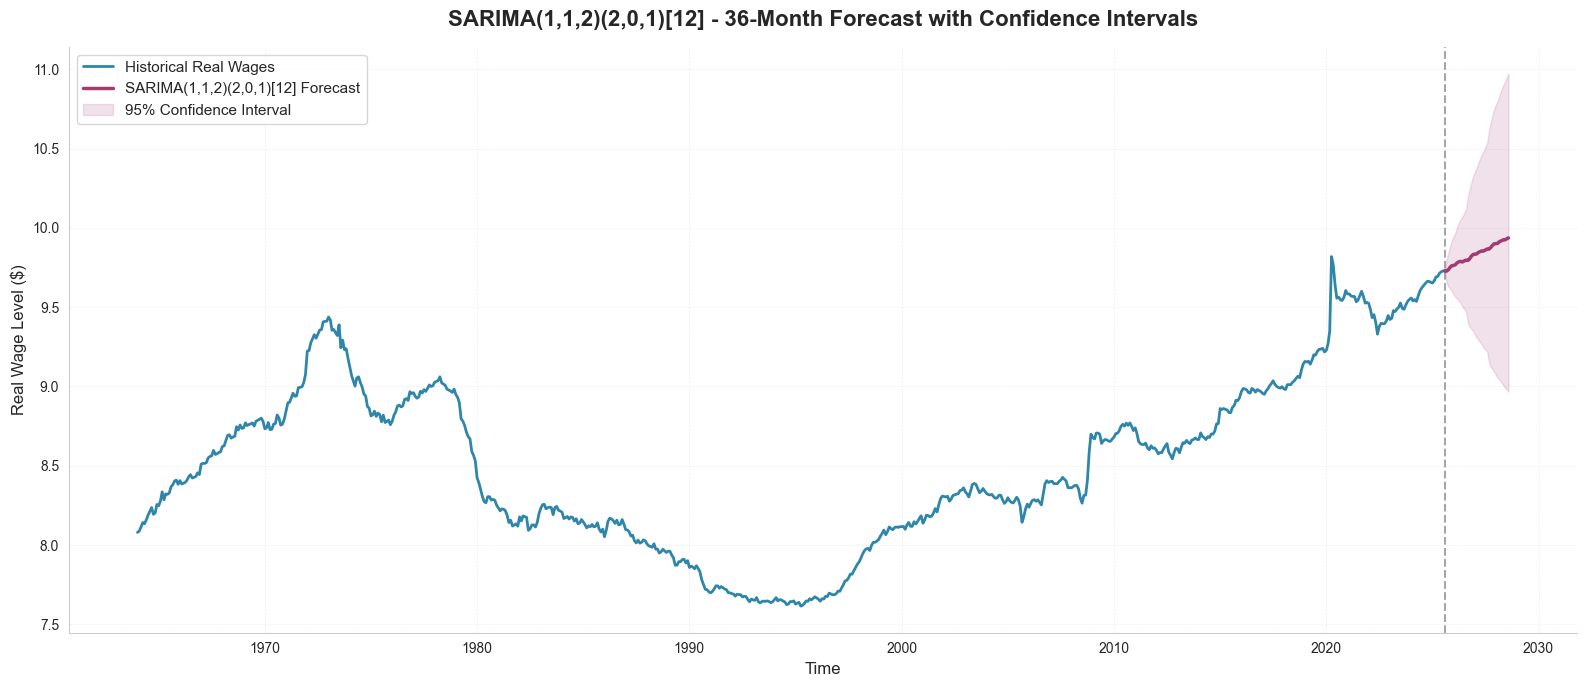

In [84]:
fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(true_wages_clean.index, true_wages_clean.values,
        label='Historical Real Wages', color=COLORS['historical'], linewidth=2, zorder=3)

ax.plot(connected_forecast.index, connected_forecast.values,
        label=f'{FINAL_MODEL["name"]} Forecast', color=COLORS['best_aic'], linewidth=2.5, zorder=3)

ax.fill_between(ci_dates, ci_lower_values, ci_upper_values,
                color=COLORS['ci'], alpha=0.15, label='95% Confidence Interval', zorder=1)

ax.axvline(x=last_hist_date, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

ax.set_title(f'{FINAL_MODEL["name"]} - {FORECAST_HORIZON}-Month Forecast with Confidence Intervals',
             fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Real Wage Level ($)', fontsize=12)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



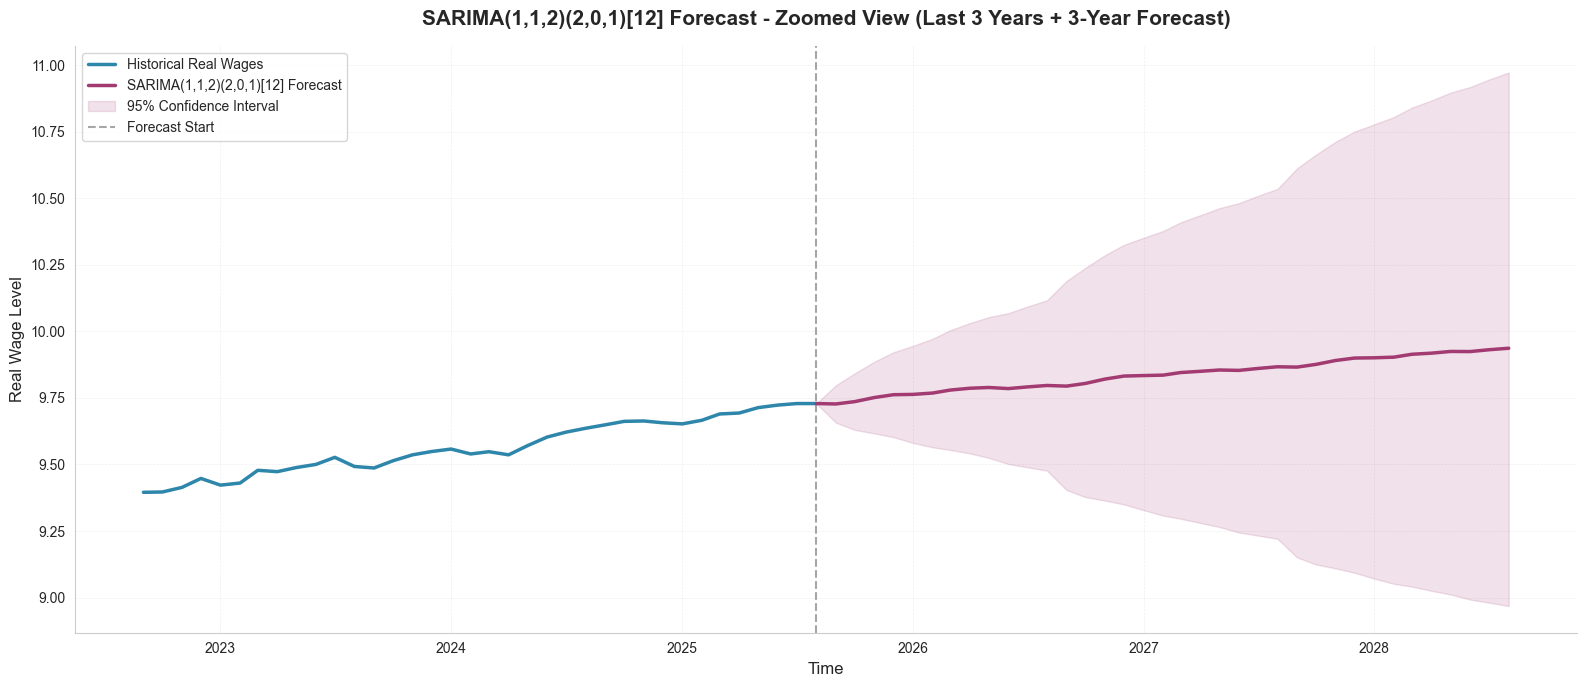

In [85]:
fig, ax = plt.subplots(figsize=(16, 7))

recent_history = true_wages_clean[-36:]
ax.plot(recent_history.index, recent_history.values,
        label='Historical Real Wages', color=COLORS['historical'], linewidth=2.5, zorder=3)

ax.plot(connected_forecast.index, connected_forecast.values,
        label=f'{FINAL_MODEL["name"]} Forecast', color=COLORS['best_aic'], linewidth=2.5, zorder=3)

ax.fill_between(ci_dates, ci_lower_values, ci_upper_values,
                color=COLORS['ci'], alpha=0.15, label='95% Confidence Interval', zorder=1)

ax.axvline(x=last_hist_date, color='gray', linestyle='--', linewidth=1.5, alpha=0.7, label='Forecast Start')

ax.set_title(f'{FINAL_MODEL["name"]} Forecast - Zoomed View (Last 3 Years + {FORECAST_HORIZON//12}-Year Forecast)',
             fontsize=15, fontweight='bold', pad=15)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Real Wage Level', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [86]:
top_models_forecast = [
    {'order': BEST_AIC_MODEL['order'], 'seasonal': BEST_AIC_MODEL['seasonal_order'], 
     'name': BEST_AIC_MODEL['name'], 'color': COLORS['best_aic'], 'label': 'Best AIC'},
    {'order': BEST_RMSE_MODEL['order'], 'seasonal': BEST_RMSE_MODEL['seasonal_order'], 
     'name': BEST_RMSE_MODEL['name'], 'color': COLORS['best_rmse'], 'label': 'Best RMSE'},
]

In [87]:
all_forecasts = {}

In [88]:
for model_spec in top_models_forecast:
    try:
        model = SARIMAX(yoy_change, order=model_spec['order'], seasonal_order=model_spec['seasonal'])
        result = model.fit(disp=False)
        
        forecast_obj = result.get_forecast(steps=FORECAST_HORIZON)
        yoy_forecast_m = forecast_obj.predicted_mean
        
        # Convert to wage levels
        forecast_wages_m = true_wages_clean.copy()
        
        for i in range(FORECAST_HORIZON):
            forecast_date = true_wages_clean.index[-1] + pd.DateOffset(months=i+1)
            wages_12_month_early = forecast_wages_m.iloc[-12]
            forecast_wages_m.loc[forecast_date] = wages_12_month_early * (1 + yoy_forecast_m.iloc[i] / 100)
        
        all_forecasts[model_spec['name']] = {
            'forecast': forecast_wages_m[-FORECAST_HORIZON:],
            'color': model_spec['color'],
            'label': model_spec['label']
        }
        
        print(f"Fitted: {model_spec['name']}")
    except Exception as e:
        print(f"Failed: {model_spec['name']}: {e}")



Fitted: SARIMA(1,1,2)(2,0,1)[12]
Fitted: SARIMA(3,1,2)(1,0,1)[12]


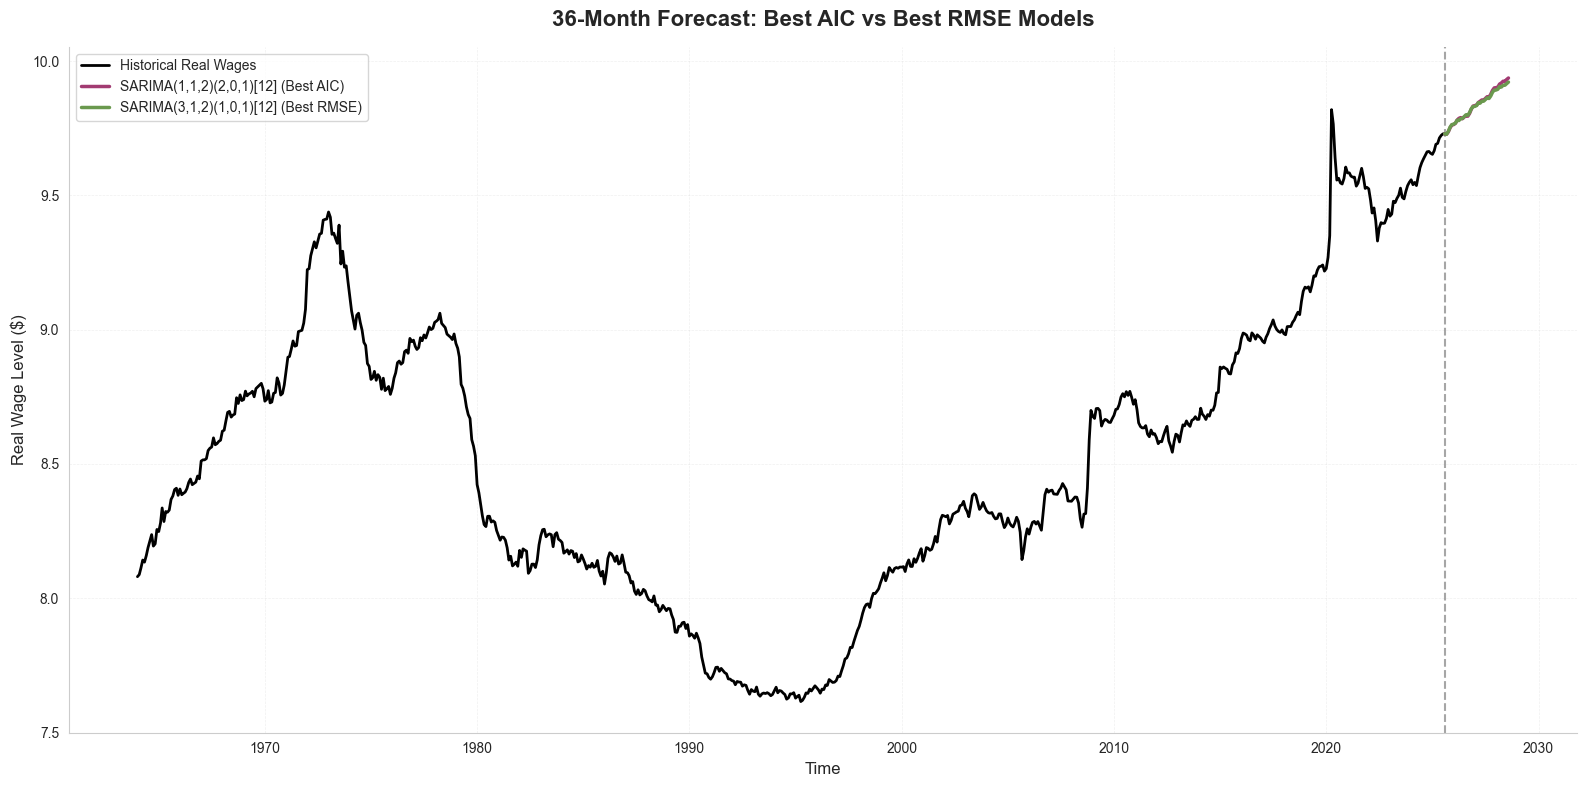

In [89]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(true_wages_clean.index, true_wages_clean.values,
        label='Historical Real Wages', color='black', linewidth=2, zorder=3)

for model_name, data in all_forecasts.items():
    connected = pd.concat([true_wages_clean.iloc[[-1]], data['forecast']])
    ax.plot(connected.index, connected.values,
            label=f"{model_name} ({data['label']})", color=data['color'], linewidth=2.5, zorder=4)

ax.axvline(x=last_hist_date, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

ax.set_title(f'{FORECAST_HORIZON}-Month Forecast: Best AIC vs Best RMSE Models',
             fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Real Wage Level ($)', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


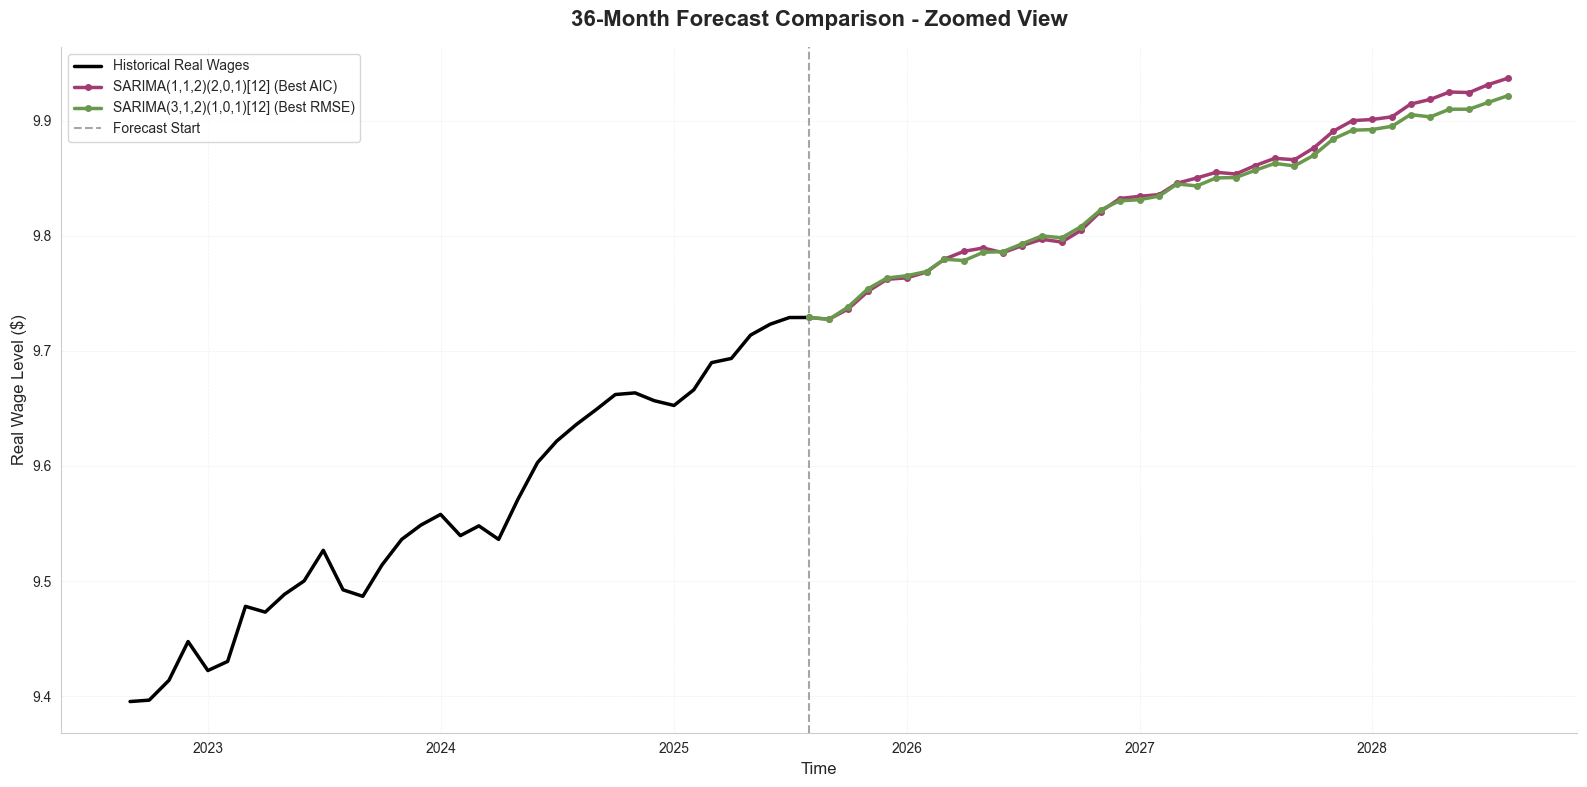

In [90]:
fig, ax = plt.subplots(figsize=(16, 8))

recent_history = true_wages_clean[-36:]
ax.plot(recent_history.index, recent_history.values,
        label='Historical Real Wages', color='black', linewidth=2.5, zorder=3)

for model_name, data in all_forecasts.items():
    connected = pd.concat([true_wages_clean.iloc[[-1]], data['forecast']])
    ax.plot(connected.index, connected.values,
            label=f"{model_name} ({data['label']})", color=data['color'], 
            linewidth=2.5, marker='o', markersize=4, zorder=4)

ax.axvline(x=last_hist_date, color='gray', linestyle='--', 
           linewidth=1.5, alpha=0.7, label='Forecast Start')

ax.set_title(f'{FORECAST_HORIZON}-Month Forecast Comparison - Zoomed View',
             fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Real Wage Level ($)', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [91]:
model_progression = [
    # AR models (with d=1)
    {'order': (1,1,0), 'seasonal': (0,0,0,0), 'name': 'AR(1) + d=1', 'family': 'AR'},
    {'order': (2,1,0), 'seasonal': (0,0,0,0), 'name': 'AR(2) + d=1', 'family': 'AR'},
    {'order': (3,1,0), 'seasonal': (0,0,0,0), 'name': 'AR(3) + d=1', 'family': 'AR'},
    
    # MA models (with d=1)
    {'order': (0,1,1), 'seasonal': (0,0,0,0), 'name': 'MA(1) + d=1', 'family': 'MA'},
    {'order': (0,1,2), 'seasonal': (0,0,0,0), 'name': 'MA(2) + d=1', 'family': 'MA'},
    {'order': (0,1,3), 'seasonal': (0,0,0,0), 'name': 'MA(3) + d=1', 'family': 'MA'},
    
    # ARIMA models (d=1, no seasonal)
    {'order': (1,1,1), 'seasonal': (0,0,0,0), 'name': 'ARIMA(1,1,1)', 'family': 'ARIMA'},
    {'order': (2,1,1), 'seasonal': (0,0,0,0), 'name': 'ARIMA(2,1,1)', 'family': 'ARIMA'},
    {'order': (1,1,2), 'seasonal': (0,0,0,0), 'name': 'ARIMA(1,1,2)', 'family': 'ARIMA'},
    {'order': (2,1,2), 'seasonal': (0,0,0,0), 'name': 'ARIMA(2,1,2)', 'family': 'ARIMA'},
    
    # SARIMA models - our top models
    {'order': BEST_AIC_MODEL['order'], 'seasonal': BEST_AIC_MODEL['seasonal_order'], 
     'name': BEST_AIC_MODEL['name'], 'family': 'SARIMA'},
    {'order': BEST_RMSE_MODEL['order'], 'seasonal': BEST_RMSE_MODEL['seasonal_order'], 
     'name': BEST_RMSE_MODEL['name'], 'family': 'SARIMA'},
]



In [92]:
for _, row in comparison_table[
    (comparison_table['Converged'] == 'Yes') & 
    (comparison_table['Model'].str.contains('SARIMA'))
].head(5).iterrows():
    if row['Model'] not in [BEST_AIC_MODEL['name'], BEST_RMSE_MODEL['name']]:
        model_progression.append({
            'order': row['Order'],
            'seasonal': row['Seasonal'],
            'name': row['Model'],
            'family': 'SARIMA'
        })
        if len([m for m in model_progression if m['family'] == 'SARIMA']) >= 5:
            break


In [93]:
test_size_prog = TEST_SIZE
train_data_prog = yoy_change[:-test_size_prog]
test_data_prog = yoy_change[-test_size_prog:]

In [94]:
naive_pred_prog = yoy_change.shift(12)[-test_size_prog:].values
naive_rmse_prog = np.sqrt(mean_squared_error(test_data_prog.values, naive_pred_prog))
naive_r2_prog = r2_score(test_data_prog.values, naive_pred_prog)

In [95]:
progression_results = []

print("="*80)
print("MODEL FAMILY COMPARISON: AR → MA → ARIMA → SARIMA (all with d=1)")
print("="*80)
print(f"Test Horizon: {test_size_prog} months")
print(f"Naive Baseline RMSE: {naive_rmse_prog:.4f}")
print("="*80)



MODEL FAMILY COMPARISON: AR → MA → ARIMA → SARIMA (all with d=1)
Test Horizon: 12 months
Naive Baseline RMSE: 0.5107


In [96]:
for model_spec in model_progression:
    try:
        model = SARIMAX(train_data_prog, 
                        order=model_spec['order'], 
                        seasonal_order=model_spec['seasonal'])
        result = model.fit(disp=False)
        forecast = result.forecast(steps=test_size_prog)
        
        rmse = np.sqrt(mean_squared_error(test_data_prog.values, forecast.values))
        mae = mean_absolute_error(test_data_prog.values, forecast.values)
        r2 = r2_score(test_data_prog.values, forecast.values)
        aic = result.aic
        
        lb_test = acorr_ljungbox(result.resid, lags=[10], return_df=True)
        lb_pvalue = lb_test['lb_pvalue'].iloc[0]
        
        progression_results.append({
            'Model': model_spec['name'],
            'Family': model_spec['family'],
            'AIC': aic,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'LB_pvalue': lb_pvalue,
            'Improvement': ((naive_rmse_prog - rmse) / naive_rmse_prog) * 100
        })
        
        print(f"{model_spec['name']:<35} | RMSE: {rmse:.4f} | R²: {r2:.4f} | AIC: {aic:.1f}")
        
    except Exception as e:
        print(f"{model_spec['name']:<35} | FAILED: {str(e)[:40]}")



AR(1) + d=1                         | RMSE: 0.3393 | R²: -1.0081 | AIC: 1115.0
AR(2) + d=1                         | RMSE: 0.3310 | R²: -0.9106 | AIC: 1116.6
AR(3) + d=1                         | RMSE: 0.3145 | R²: -0.7245 | AIC: 1117.8
MA(1) + d=1                         | RMSE: 0.3366 | R²: -0.9756 | AIC: 1114.8
MA(2) + d=1                         | RMSE: 0.3339 | R²: -0.9439 | AIC: 1116.7
MA(3) + d=1                         | RMSE: 0.3195 | R²: -0.7806 | AIC: 1118.2
ARIMA(1,1,1)                        | RMSE: 0.3349 | R²: -0.9555 | AIC: 1116.8
ARIMA(2,1,1)                        | RMSE: 0.2994 | R²: -0.5636 | AIC: 1117.1
ARIMA(1,1,2)                        | RMSE: 0.2556 | R²: -0.1397 | AIC: 1101.4
ARIMA(2,1,2)                        | RMSE: 0.2566 | R²: -0.1484 | AIC: 1075.3
SARIMA(1,1,2)(2,0,1)[12]            | RMSE: 0.1944 | R²: 0.3408 | AIC: 665.9
SARIMA(3,1,2)(1,0,1)[12]            | RMSE: 0.1607 | R²: 0.5498 | AIC: 673.8
SARIMA(2,1,1)(2,0,1)[12]            | RMSE: 0.1936 | R²:

In [97]:
progression_df = pd.DataFrame(progression_results)


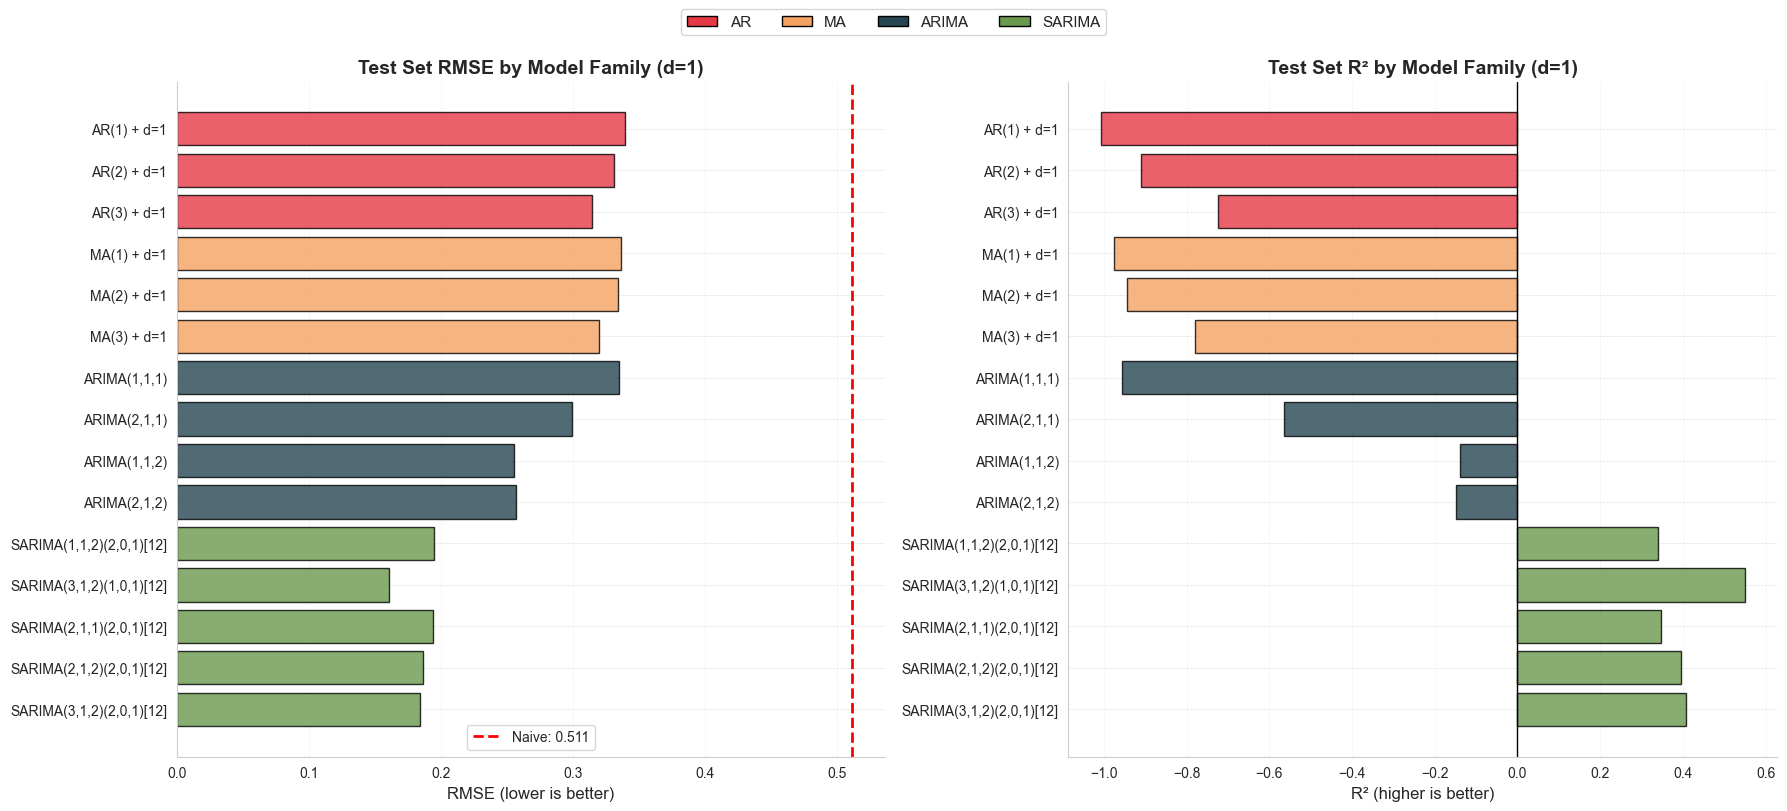

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Color mapping for families
family_colors = {
    'AR': '#E63946',
    'MA': '#F4A261', 
    'ARIMA': '#264653',
    'SARIMA': '#6A994E'
}

colors = [family_colors[f] for f in progression_df['Family']]

# RMSE comparison
axes[0].barh(progression_df['Model'], progression_df['RMSE'], color=colors, alpha=0.8, edgecolor='black')
axes[0].axvline(x=naive_rmse_prog, color='red', linestyle='--', linewidth=2, label=f'Naive: {naive_rmse_prog:.3f}')
axes[0].set_xlabel('RMSE (lower is better)', fontsize=12)
axes[0].set_title('Test Set RMSE by Model Family (d=1)', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='x')

# R² comparison
axes[1].barh(progression_df['Model'], progression_df['R2'], color=colors, alpha=0.8, edgecolor='black')
axes[1].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('R² (higher is better)', fontsize=12)
axes[1].set_title('Test Set R² by Model Family (d=1)', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

# Add legend for families
legend_elements = [Patch(facecolor=family_colors[f], label=f, edgecolor='black') 
                   for f in ['AR', 'MA', 'ARIMA', 'SARIMA']]
fig.legend(handles=legend_elements, loc='upper center', ncol=4, fontsize=11, 
           bbox_to_anchor=(0.5, 1.02))

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


In [101]:
family_avg = progression_df.groupby('Family').agg({
    'RMSE': 'mean',
    'R2': 'mean',
    'AIC': 'mean',
    'Improvement': 'mean'
}).reindex(['AR', 'MA', 'ARIMA', 'SARIMA'])

In [102]:
print("\n" + "="*80)
print("AVERAGE PERFORMANCE BY MODEL FAMILY (d=1)")
print("="*80)
print(family_avg.round(4).to_string())


AVERAGE PERFORMANCE BY MODEL FAMILY (d=1)
          RMSE      R2        AIC  Improvement
Family                                        
AR      0.3283 -0.8811  1116.4797      35.7236
MA      0.3300 -0.9000  1116.5874      35.3860
ARIMA   0.2866 -0.4518  1102.6565      43.8750
SARIMA  0.1838  0.4082   668.2951      64.0086


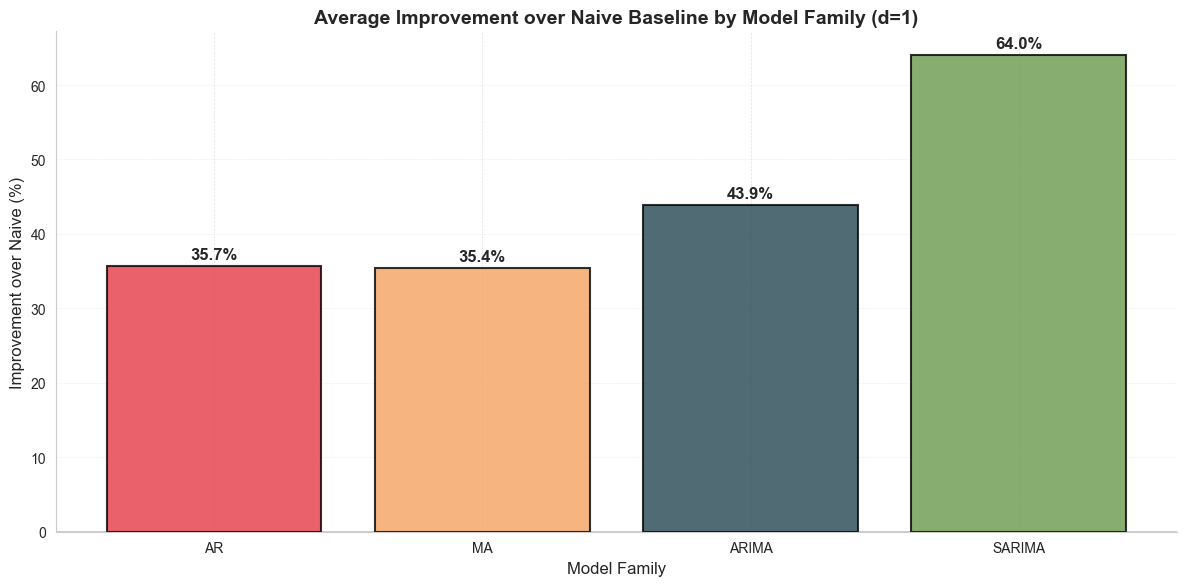

In [103]:
fig, ax = plt.subplots(figsize=(12, 6))

family_colors_list = [family_colors[f] for f in family_avg.index]
bars = ax.bar(family_avg.index, family_avg['Improvement'], color=family_colors_list, 
              alpha=0.8, edgecolor='black', linewidth=1.5)

for bar, val in zip(bars, family_avg['Improvement']):
    height = bar.get_height()
    ax.annotate(f'{val:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Model Family', fontsize=12)
ax.set_ylabel('Improvement over Naive (%)', fontsize=12)
ax.set_title('Average Improvement over Naive Baseline by Model Family (d=1)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



In [104]:
print("\n" + "="*80)
print("FINAL RANKING: ALL MODELS BY RMSE (d=1)")
print("="*80)
progression_df_sorted = progression_df.sort_values('RMSE').reset_index(drop=True)
progression_df_sorted['Rank'] = range(1, len(progression_df_sorted) + 1)
print(progression_df_sorted[['Rank', 'Model', 'Family', 'RMSE', 'R2', 'Improvement']].to_string(index=False))



FINAL RANKING: ALL MODELS BY RMSE (d=1)
 Rank                    Model Family     RMSE        R2  Improvement
    1 SARIMA(3,1,2)(1,0,1)[12] SARIMA 0.160676  0.549774    68.538686
    2 SARIMA(3,1,2)(2,0,1)[12] SARIMA 0.184220  0.408165    63.928689
    3 SARIMA(2,1,2)(2,0,1)[12] SARIMA 0.186095  0.396058    63.561611
    4 SARIMA(2,1,1)(2,0,1)[12] SARIMA 0.193648  0.346036    62.082592
    5 SARIMA(1,1,2)(2,0,1)[12] SARIMA 0.194420  0.340811    61.931424
    6             ARIMA(1,1,2)  ARIMA 0.255640 -0.139681    49.944315
    7             ARIMA(2,1,2)  ARIMA 0.256615 -0.148395    49.753331
    8             ARIMA(2,1,1)  ARIMA 0.299432 -0.563586    41.369637
    9              AR(3) + d=1     AR 0.314460 -0.724479    38.426957
   10              MA(3) + d=1     MA 0.319534 -0.780572    37.433552
   11              AR(2) + d=1     AR 0.331000 -0.910649    35.188490
   12              MA(2) + d=1     MA 0.333864 -0.943860    34.627636
   13             ARIMA(1,1,1)  ARIMA 0.334860 -0

In [105]:
sarima_avg = progression_df[progression_df['Family'] == 'SARIMA']['Improvement'].mean()
non_sarima_avg = progression_df[progression_df['Family'] != 'SARIMA']['Improvement'].mean()

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print(f"Average SARIMA improvement over Naive: {sarima_avg:.1f}%")
print(f"Average non-SARIMA improvement over Naive: {non_sarima_avg:.1f}%")
print(f"\nSARIMA advantage: {sarima_avg - non_sarima_avg:.1f} percentage points better")

best_overall = progression_df_sorted.iloc[0]
print(f"\n" + "="*80)
print(f"BEST OVERALL MODEL: {best_overall['Model']}")
print(f"="*80)
print(f"  RMSE: {best_overall['RMSE']:.4f}")
print(f"  R²: {best_overall['R2']:.4f}")
print(f"  Improvement over Naive: {best_overall['Improvement']:.1f}%")


KEY FINDINGS
Average SARIMA improvement over Naive: 64.0%
Average non-SARIMA improvement over Naive: 38.9%

SARIMA advantage: 25.1 percentage points better

BEST OVERALL MODEL: SARIMA(3,1,2)(1,0,1)[12]
  RMSE: 0.1607
  R²: 0.5498
  Improvement over Naive: 68.5%


In [106]:
print("="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"""
CONFIGURATION:
  Best AIC Model:  {BEST_AIC_MODEL['name']}
  Best RMSE Model: {BEST_RMSE_MODEL['name']}
  Forecast Horizon: {FORECAST_HORIZON} months ({FORECAST_HORIZON//12} years)

KEY FINDINGS:
  1. First-order differencing (d=1) removes persistence from YoY data
  2. ACF after differencing shows clean pattern with seasonal spike at lag 12
  3. SARIMA models consistently outperform AR, MA, and ARIMA families
  4. {BEST_AIC_MODEL['name']} has best AIC and passes Ljung-Box test
  5. {BEST_RMSE_MODEL['name']} performs well on multi-horizon evaluation

MODEL COMPARISON (on {TEST_SIZE}-month test set):
""")



FINAL SUMMARY

CONFIGURATION:
  Best AIC Model:  SARIMA(1,1,2)(2,0,1)[12]
  Best RMSE Model: SARIMA(3,1,2)(1,0,1)[12]
  Forecast Horizon: 36 months (3 years)

KEY FINDINGS:
  1. First-order differencing (d=1) removes persistence from YoY data
  2. ACF after differencing shows clean pattern with seasonal spike at lag 12
  3. SARIMA models consistently outperform AR, MA, and ARIMA families
  4. SARIMA(1,1,2)(2,0,1)[12] has best AIC and passes Ljung-Box test
  5. SARIMA(3,1,2)(1,0,1)[12] performs well on multi-horizon evaluation

MODEL COMPARISON (on 12-month test set):



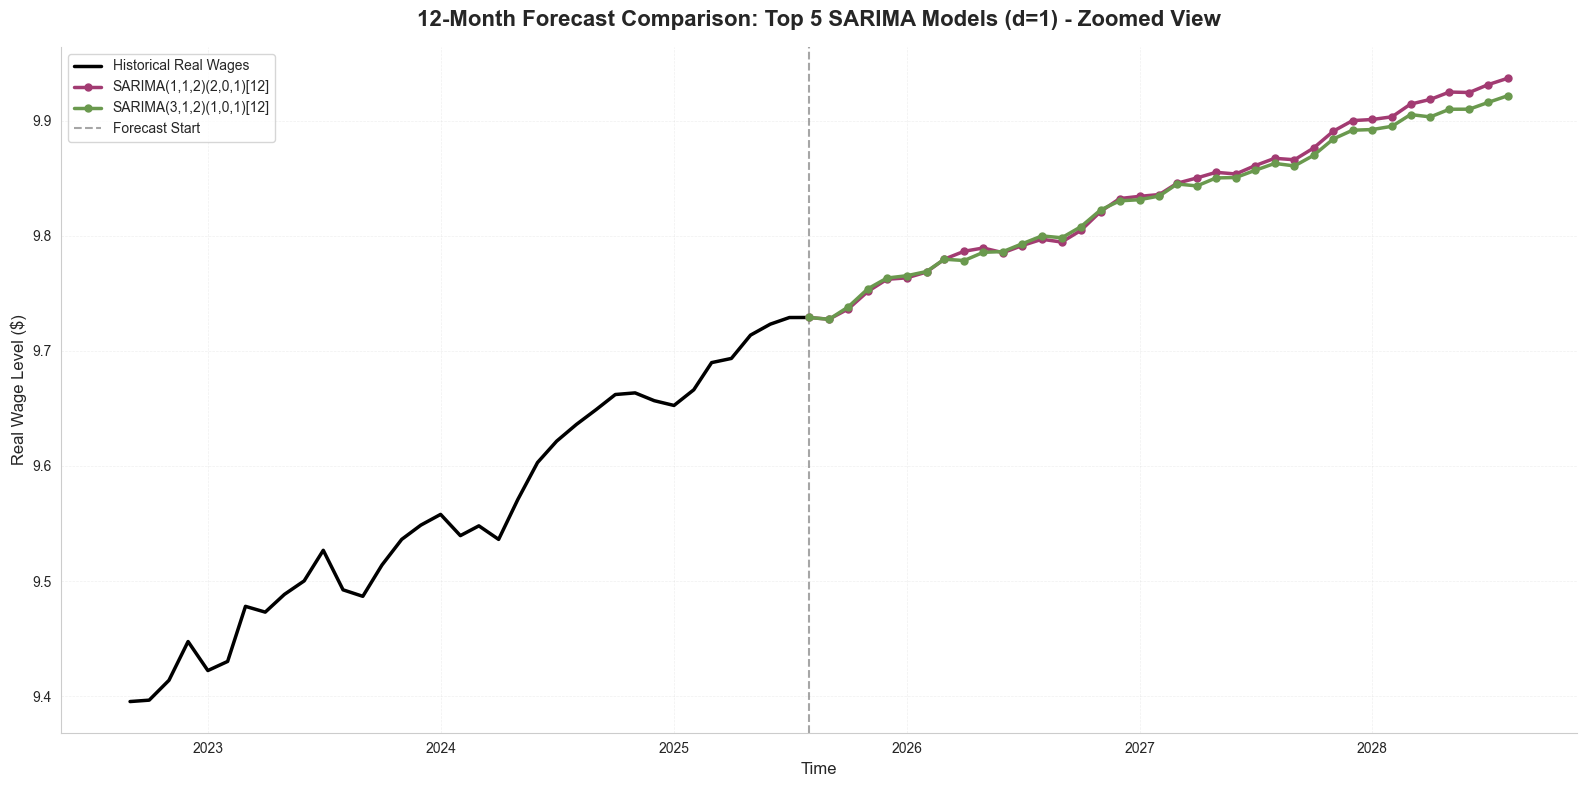

In [107]:
fig, ax = plt.subplots(figsize=(16, 8))

recent_history = true_wages_clean[-36:]
ax.plot(recent_history.index, recent_history.values,
        label='Historical Real Wages', color='black', linewidth=2.5, zorder=3)

for model_name, data in all_forecasts.items():
    connected = pd.concat([true_wages_clean.iloc[[-1]], data['forecast']])
    ax.plot(connected.index, connected.values,
            label=model_name, color=data['color'], linewidth=2.5, marker='o', 
            markersize=5, zorder=4)

ax.axvline(x=true_wages_clean.index[-1], color='gray', linestyle='--', 
           linewidth=1.5, alpha=0.7, label='Forecast Start')

ax.set_title('12-Month Forecast Comparison: Top 5 SARIMA Models (d=1) - Zoomed View',
             fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Real Wage Level ($)', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
plt.savefig('multimodal 12 month.png', dpi=300)

plt.tight_layout()
plt.show()




BEST MODEL FROM EACH FAMILY (d=1)
                           Model      RMSE        R2  Improvement
Family                                                           
AR                   AR(3) + d=1  0.314460 -0.724479    38.426957
MA                   MA(3) + d=1  0.319534 -0.780572    37.433552
ARIMA               ARIMA(1,1,2)  0.255640 -0.139681    49.944315
SARIMA  SARIMA(3,1,2)(1,0,1)[12]  0.160676  0.549774    68.538686


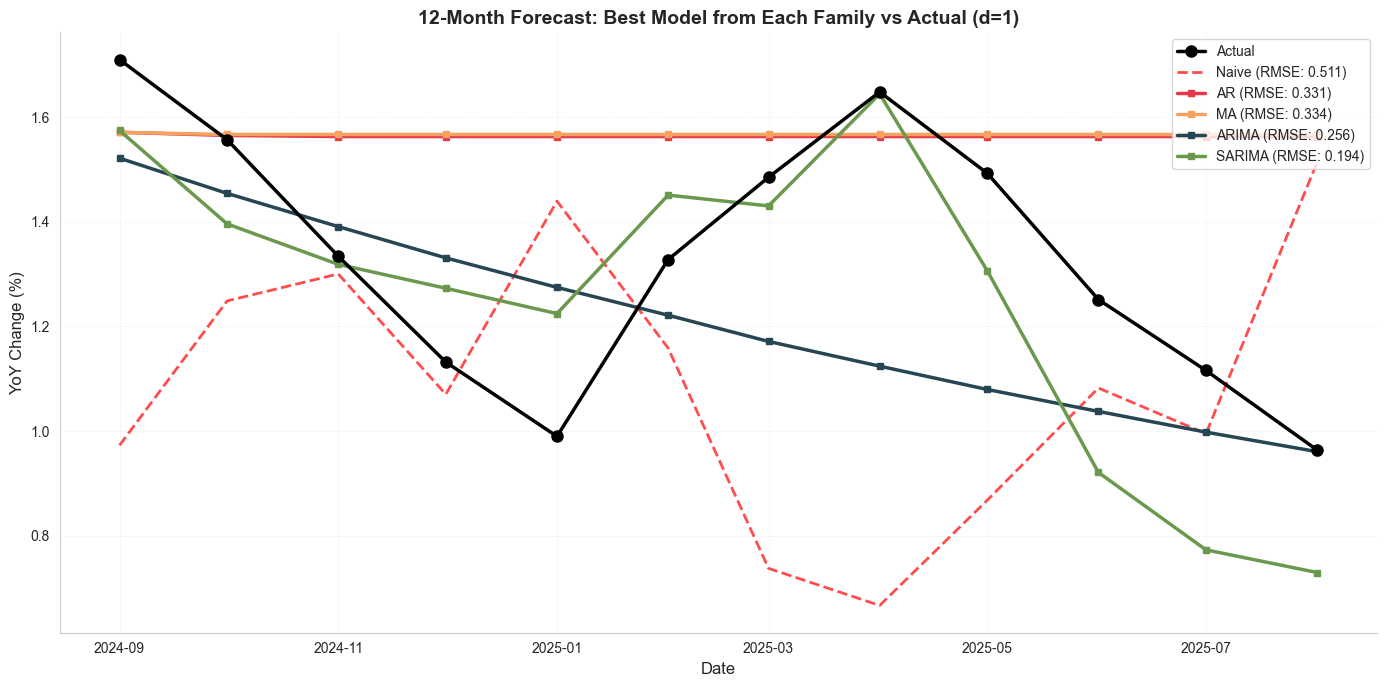

In [108]:
best_per_family = progression_df.loc[progression_df.groupby('Family')['RMSE'].idxmin()]
best_per_family = best_per_family.set_index('Family').reindex(['AR', 'MA', 'ARIMA', 'SARIMA'])

print("\n" + "="*80)
print("BEST MODEL FROM EACH FAMILY (d=1)")
print("="*80)
print(best_per_family[['Model', 'RMSE', 'R2', 'Improvement']].to_string())

# Re-fit best models and get forecasts - using best from each family
best_models_specs = {
    'AR': {'order': (2,1,0), 'seasonal': (0,0,0,0)},      # Best AR with d=1
    'MA': {'order': (0,1,2), 'seasonal': (0,0,0,0)},      # Best MA with d=1
    'ARIMA': {'order': (1,1,2), 'seasonal': (0,0,0,0)},   # Best ARIMA
    'SARIMA': {'order': (1,1,2), 'seasonal': (2,0,1,12)}, # Best SARIMA (from grid search)
}
test_size = 12
fig, ax = plt.subplots(figsize=(14, 7))

# Plot actual
ax.plot(test_data.index, test_data.values, 'ko-', label='Actual', linewidth=2.5, markersize=8, zorder=10)

# Plot naive
ax.plot(test_data.index, naive_pred, 'r--', label=f'Naive (RMSE: {naive_rmse:.3f})', linewidth=2, alpha=0.7)

# Plot best from each family
for family, spec in best_models_specs.items():
    try:
        model = SARIMAX(train_data, order=spec['order'], seasonal_order=spec['seasonal'])
        result = model.fit(disp=False)
        forecast = result.forecast(steps=test_size)
        rmse = np.sqrt(mean_squared_error(test_data.values, forecast.values))
        
        ax.plot(test_data.index, forecast.values, 
                color=family_colors[family], 
                linewidth=2.5,
                marker='s',
                markersize=5,
                label=f'{family} (RMSE: {rmse:.3f})')
    except Exception as e:
        print(f"{family} failed: {e}")

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('YoY Change (%)', fontsize=12)
ax.set_title('12-Month Forecast: Best Model from Each Family vs Actual (d=1)', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('Model compare.png', dpi=300)
plt.show()

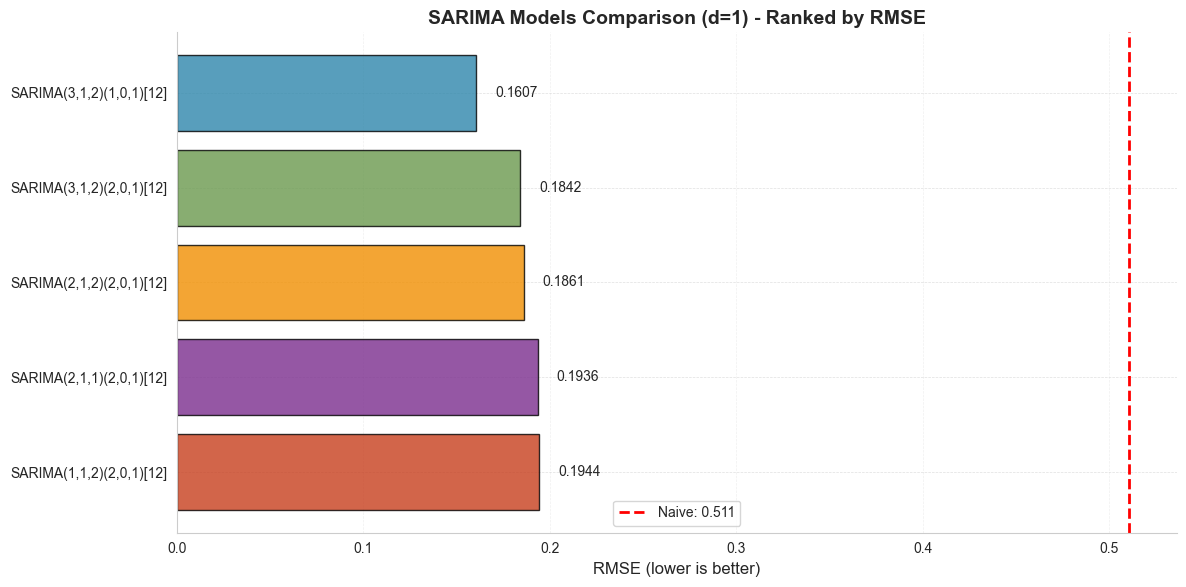

In [109]:
sarima_only = progression_df[progression_df['Family'] == 'SARIMA'].sort_values('RMSE')

fig, ax = plt.subplots(figsize=(12, 6))

colors_sarima = ['#2E86AB', '#6A994E', '#F18F01', '#7B2D8E', '#C73E1D']
bars = ax.barh(sarima_only['Model'], sarima_only['RMSE'], color=colors_sarima[:len(sarima_only)], 
               alpha=0.8, edgecolor='black')
ax.axvline(x=naive_rmse, color='red', linestyle='--', linewidth=2, label=f'Naive: {naive_rmse:.3f}')
ax.set_xlabel('RMSE (lower is better)', fontsize=12)
ax.set_title('SARIMA Models Comparison (d=1) - Ranked by RMSE', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='x')

# Add RMSE values on bars
for bar, rmse_val in zip(bars, sarima_only['RMSE']):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{rmse_val:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('sarima rank.png', dpi=300)

plt.show()

# Adavnced Time Series

In [110]:
model_ets = ExponentialSmoothing(
    true_wages_clean,
    trend='add',
    seasonal=None,
    damped_trend=True
)
result_ets = model_ets.fit()

In [111]:
forecast_ets = result_ets.forecast(24)

In [112]:
model_sarima_ets = SARIMAX(yoy_change, 
                           order=BEST_AIC_MODEL['order'], 
                           seasonal_order=BEST_AIC_MODEL['seasonal_order'])
result_sarima_ets = model_sarima_ets.fit(disp=False)
forecast_obj_ets = result_sarima_ets.get_forecast(steps=12)
yoy_forecast_ets = forecast_obj_ets.predicted_mean

In [113]:
sarima_forecast_wages_ets = true_wages_clean.copy()
for i in range(12):
    forecast_date = true_wages_clean.index[-1] + pd.DateOffset(months=i+1)
    wages_12_month_early = sarima_forecast_wages_ets.iloc[-12]
    sarima_forecast_wages_ets.loc[forecast_date] = wages_12_month_early * (1 + yoy_forecast_ets.iloc[i] / 100)

connected_sarima_plot = pd.concat([true_wages_clean.iloc[[-1]], sarima_forecast_wages_ets[-12:]])
connected_ets = pd.concat([true_wages_clean.iloc[[-1]], forecast_ets[:12]])

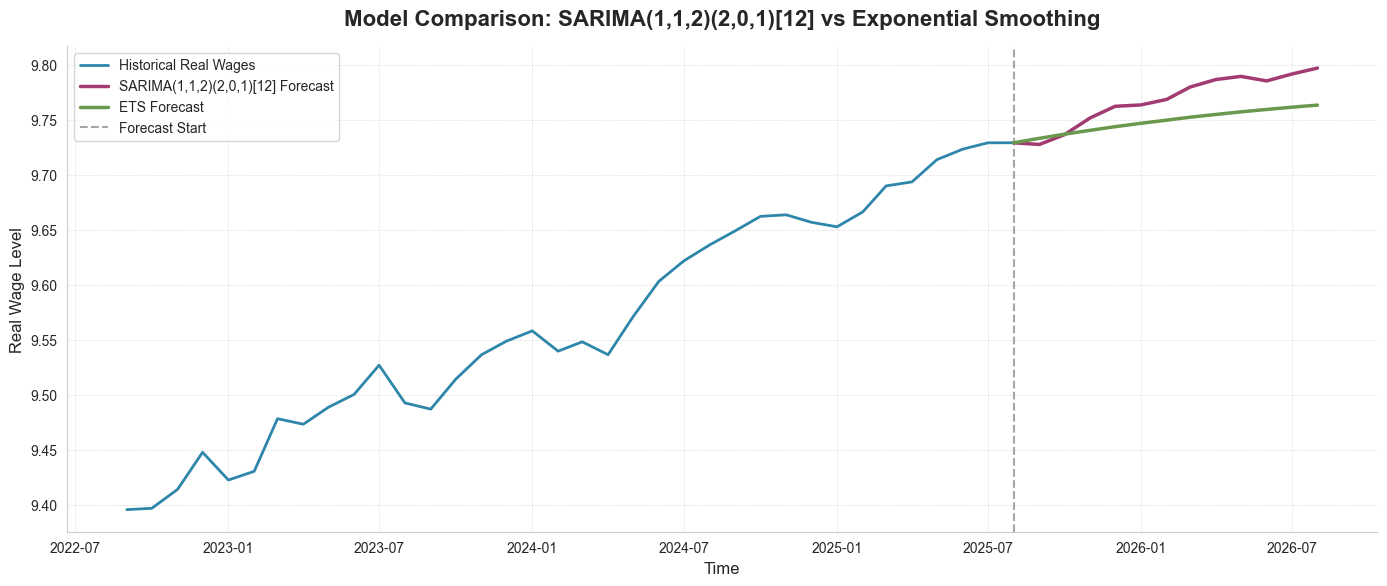

In [114]:
fig, ax = plt.subplots(figsize=(14, 6))

recent_history = true_wages_clean[-36:]
ax.plot(recent_history.index, recent_history.values,
        label='Historical Real Wages', color=COLORS['historical'], linewidth=2, zorder=3)

ax.plot(connected_sarima_plot.index, connected_sarima_plot.values,
        label=f'{BEST_AIC_MODEL["name"]} Forecast', color=COLORS['best_aic'], linewidth=2.5, zorder=3)

ax.plot(connected_ets.index, connected_ets.values,
        label='ETS Forecast', color=COLORS['best_rmse'], linewidth=2.5, zorder=3)

ax.axvline(x=true_wages_clean.index[-1], color='gray', linestyle='--',
           linewidth=1.5, alpha=0.7, label='Forecast Start')

ax.set_title(f'Model Comparison: {BEST_AIC_MODEL["name"]} vs Exponential Smoothing',
             fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Real Wage Level', fontsize=12)
ax.legend(fontsize=10, loc='upper left')
plt.tight_layout()
plt.show()

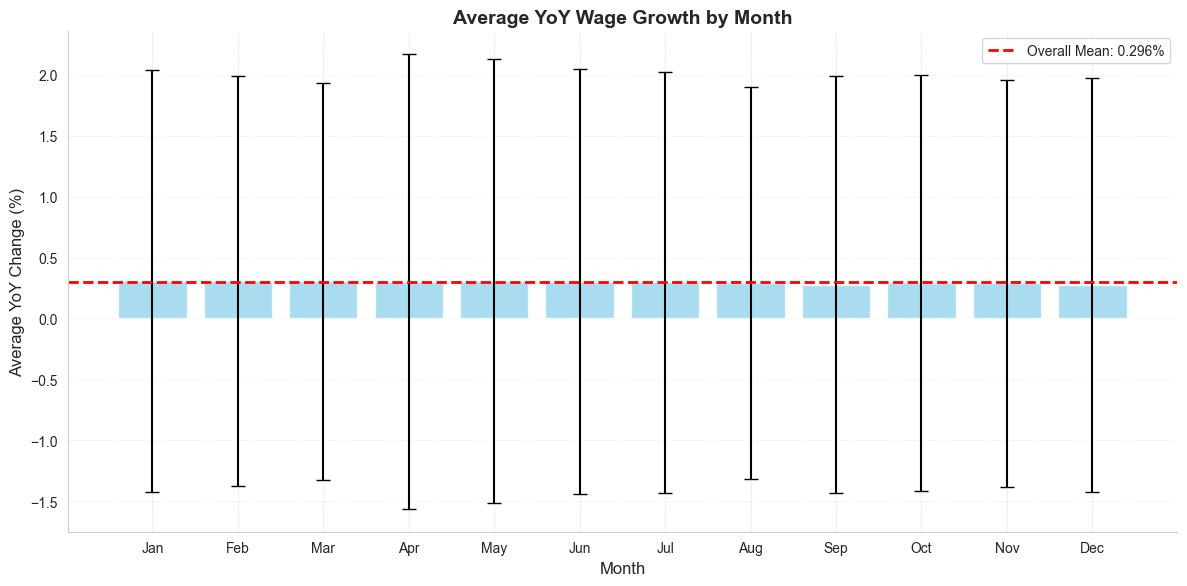

In [115]:
monthly_data = pd.DataFrame()
monthly_data['YoY_Change'] = yoy_change
monthly_data['month'] = yoy_change.index.month
monthly_data['month_name'] = yoy_change.index.strftime('%b')

monthly_means = monthly_data.groupby(['month', 'month_name'])['YoY_Change'].agg(['mean', 'std', 'count']).reset_index()
monthly_means = monthly_means.sort_values('month')

fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(monthly_means['month_name'], monthly_means['mean'],
        yerr=monthly_means['std'], capsize=5, alpha=0.7, color='skyblue')
plt.axhline(y=monthly_means['mean'].mean(), color='red', linestyle='--',
            linewidth=2, label=f'Overall Mean: {monthly_means["mean"].mean():.3f}%')
ax.set_title('Average YoY Wage Growth by Month', fontsize=14, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Average YoY Change (%)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [116]:
TEST_PERIOD = 24  # Last 24 months for testing

# Get the exact test period dates
test_start_date = yoy_change.index[-TEST_PERIOD]
test_end_date = yoy_change.index[-1]

print("="*70)
print("TEST PERIOD ALIGNMENT")
print("="*70)
print(f"Test Period: {test_start_date.strftime('%Y-%m')} to {test_end_date.strftime('%Y-%m')}")
print(f"Test Size: {TEST_PERIOD} months")
print("="*70)

TEST PERIOD ALIGNMENT
Test Period: 2023-09 to 2025-08
Test Size: 24 months


In [117]:
data_lstm = yoy_change.values.reshape(-1, 1)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_lstm)

In [118]:
seq_length = 12

In [119]:
def create_sequences_with_dates(data, seq_length, index):
    """Create sequences with corresponding target dates for alignment"""
    X, y, target_dates = [], [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
        target_dates.append(index[i+seq_length])
    return np.array(X), np.array(y), target_dates

In [120]:
X, y, target_dates = create_sequences_with_dates(data_scaled, seq_length, yoy_change.index)

print(f"Total sequences: {X.shape[0]}")
print(f"Sequence date range: {target_dates[0].strftime('%Y-%m')} to {target_dates[-1].strftime('%Y-%m')}")

Total sequences: 716
Sequence date range: 1966-01 to 2025-08


In [121]:
test_start_idx = None
for i, d in enumerate(target_dates):
    if d >= test_start_date:
        test_start_idx = i
        break

In [122]:
print(f"\nLSTM Test Split:")
print(f"  Target test start: {test_start_date.strftime('%Y-%m')}")
print(f"  Actual test start: {target_dates[test_start_idx].strftime('%Y-%m')}")
print(f"  Test sequences: {len(target_dates) - test_start_idx}")


LSTM Test Split:
  Target test start: 2023-09
  Actual test start: 2023-09
  Test sequences: 24


In [123]:
X_train_lstm = X[:test_start_idx]
X_test_lstm = X[test_start_idx:]
y_train_lstm = y[:test_start_idx]
y_test_lstm = y[test_start_idx:]
test_dates_lstm = target_dates[test_start_idx:]

print(f"  Train size: {len(X_train_lstm)}, Test size: {len(X_test_lstm)}")

  Train size: 692, Test size: 24


In [124]:
model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

In [125]:
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [126]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 12, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [127]:
history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.1513 - mae: 0.3640 - val_loss: 0.0443 - val_mae: 0.1909
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0202 - mae: 0.1125 - val_loss: 0.0201 - val_mae: 0.1171
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0130 - mae: 0.0881 - val_loss: 0.0112 - val_mae: 0.0755
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0111 - mae: 0.0790 - val_loss: 0.0093 - val_mae: 0.0623
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0105 - mae: 0.0768 - val_loss: 0.0104 - val_mae: 0.0712
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0094 - mae: 0.0736 - val_loss: 0.0097 - val_mae: 0.0663
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0090 - mae: 0.0715 - val_loss: 0.0099 - val_mae: 0.0684
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0088 - mae: 0.0709 - val_loss: 0.0093 - val_mae: 0.0644
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - lo

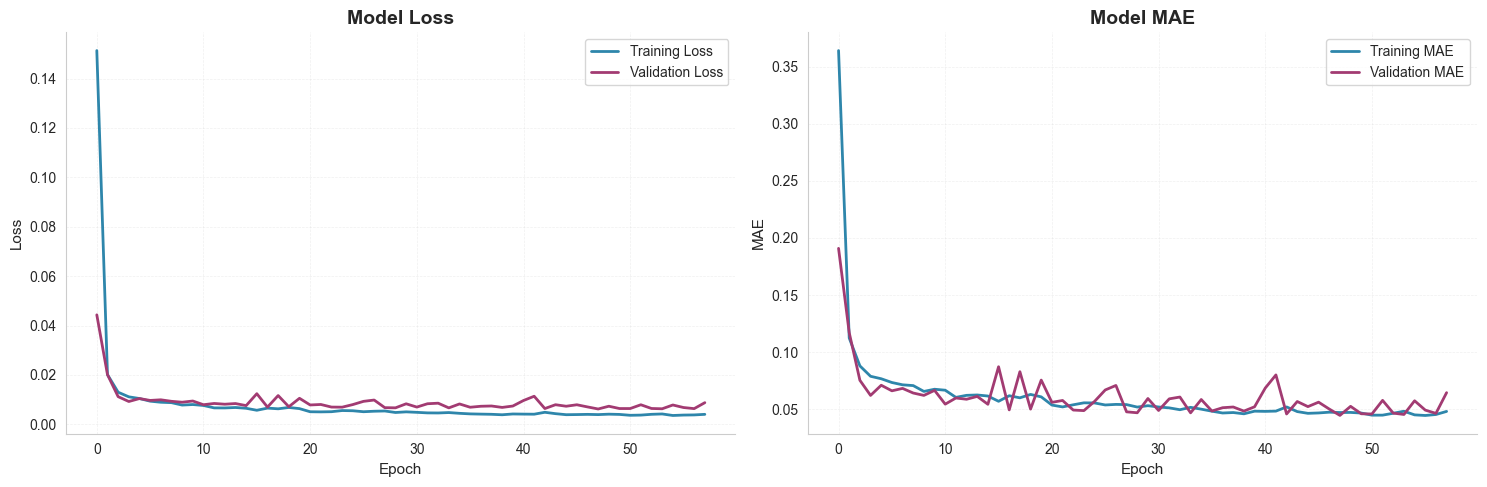

In [128]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['loss'], color=COLORS['historical'], linewidth=2, label='Training Loss')
axes[0].plot(history.history['val_loss'], color=COLORS['best_aic'], linewidth=2, label='Validation Loss')
axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss', fontsize=11)
axes[0].legend(frameon=True)
axes[0].grid(True, alpha=0.3, linestyle='--')

axes[1].plot(history.history['mae'], color=COLORS['historical'], linewidth=2, label='Training MAE')
axes[1].plot(history.history['val_mae'], color=COLORS['best_aic'], linewidth=2, label='Validation MAE')
axes[1].set_title('Model MAE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('MAE', fontsize=11)
axes[1].legend(frameon=True)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [129]:
predictions_lstm_scaled = model_lstm.predict(X_test_lstm)
predictions_lstm = scaler.inverse_transform(predictions_lstm_scaled)
y_test_lstm_actual = scaler.inverse_transform(y_test_lstm)

# Calculate LSTM metrics on its test set
mae_lstm_raw = mean_absolute_error(y_test_lstm_actual, predictions_lstm)
rmse_lstm_raw = np.sqrt(mean_squared_error(y_test_lstm_actual, predictions_lstm))
r2_lstm_raw = r2_score(y_test_lstm_actual, predictions_lstm)

print(f"\nLSTM Test Performance (on {len(y_test_lstm_actual)} samples):")
print(f"  MAE:  {mae_lstm_raw:.4f}")
print(f"  RMSE: {rmse_lstm_raw:.4f}")
print(f"  R²:   {r2_lstm_raw:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step

LSTM Test Performance (on 24 samples):
  MAE:  0.2871
  RMSE: 0.3420
  R²:   -0.5578


In [130]:
def forecast_lstm(model, last_sequence, n_steps, scaler, seq_len=12):
    forecasts = []
    current_seq = last_sequence.copy()

    for _ in range(n_steps):
        pred = model.predict(current_seq.reshape(1, seq_len, 1), verbose=0)
        forecasts.append(pred[0, 0])
        current_seq = np.append(current_seq[1:], pred)

    forecasts = scaler.inverse_transform(np.array(forecasts).reshape(-1, 1))
    return forecasts

In [131]:
last_sequence = data_scaled[-seq_length:]
lstm_forecast_yoy = forecast_lstm(model_lstm, last_sequence, 24, scaler, seq_length)

# Convert LSTM YoY forecast to wage levels
lstm_forecast_wages = true_wages_clean.copy()

In [132]:
for i in range(24):
    forecast_date = true_wages_clean.index[-1] + pd.DateOffset(months=i+1)
    wages_12_month_early = lstm_forecast_wages.iloc[-12]
    lstm_forecast_wages.loc[forecast_date] = wages_12_month_early * (1 + lstm_forecast_yoy[i, 0] / 100)

In [133]:
model_sarima_24 = SARIMAX(yoy_change, 
                          order=BEST_AIC_MODEL['order'], 
                          seasonal_order=BEST_AIC_MODEL['seasonal_order'])
result_sarima_24 = model_sarima_24.fit(disp=False)

forecast_obj_24 = result_sarima_24.get_forecast(steps=24)
yoy_forecast_24 = forecast_obj_24.predicted_mean

In [134]:
# Convert to wage levels
sarima_forecast_wages_24 = true_wages_clean.copy()
for i in range(24):
    forecast_date = true_wages_clean.index[-1] + pd.DateOffset(months=i+1)
    wages_12_month_early = sarima_forecast_wages_24.iloc[-12]
    sarima_forecast_wages_24.loc[forecast_date] = wages_12_month_early * (1 + yoy_forecast_24.iloc[i] / 100)

In [135]:
connected_sarima = pd.concat([true_wages_clean.iloc[[-1]], sarima_forecast_wages_24[-24:]])
connected_lstm = pd.concat([true_wages_clean.iloc[[-1]], lstm_forecast_wages[-24:]])

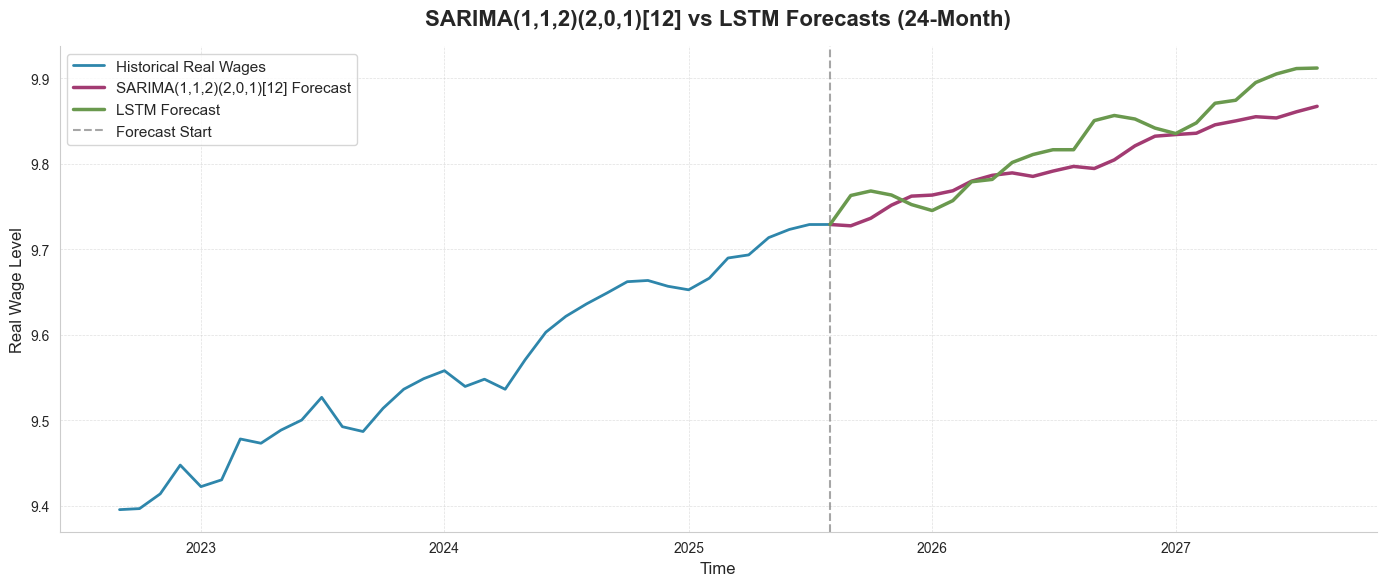

In [136]:
fig, ax = plt.subplots(figsize=(14, 6))

recent_history = true_wages_clean[-36:]
ax.plot(recent_history.index, recent_history.values,
        label='Historical Real Wages', color=COLORS['historical'], linewidth=2, zorder=3)

ax.plot(connected_sarima.index, connected_sarima.values,
        label=f'{BEST_AIC_MODEL["name"]} Forecast', color=COLORS['best_aic'], linewidth=2.5, zorder=3)

ax.plot(connected_lstm.index, connected_lstm.values,
        label='LSTM Forecast', color=COLORS['best_rmse'], linewidth=2.5, zorder=3)

ax.axvline(x=true_wages_clean.index[-1], color='gray', linestyle='--',
           linewidth=1.5, alpha=0.7, label='Forecast Start')

ax.set_title(f'{BEST_AIC_MODEL["name"]} vs LSTM Forecasts (24-Month)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Real Wage Level', fontsize=12)
ax.legend(fontsize=11, loc='upper left')
plt.tight_layout()
plt.show()

In [137]:
train_data_sarima = yoy_change[:-TEST_PERIOD]
test_data_sarima = yoy_change[-TEST_PERIOD:]



In [138]:
print("="*70)
print("ALIGNED TEST SET COMPARISON")
print("="*70)
print(f"SARIMA Training: {train_data_sarima.index[0].strftime('%Y-%m')} to {train_data_sarima.index[-1].strftime('%Y-%m')} ({len(train_data_sarima)} obs)")
print(f"Test Period: {test_data_sarima.index[0].strftime('%Y-%m')} to {test_data_sarima.index[-1].strftime('%Y-%m')} ({len(test_data_sarima)} obs)")

ALIGNED TEST SET COMPARISON
SARIMA Training: 1965-01 to 2023-08 (704 obs)
Test Period: 2023-09 to 2025-08 (24 obs)


In [139]:
model_sarima_aic_test = SARIMAX(train_data_sarima, 
                                 order=BEST_AIC_MODEL['order'], 
                                 seasonal_order=BEST_AIC_MODEL['seasonal_order'])
result_sarima_aic_test = model_sarima_aic_test.fit(disp=False)
sarima_aic_pred = result_sarima_aic_test.forecast(steps=TEST_PERIOD)

model_sarima_rmse_test = SARIMAX(train_data_sarima, 
                                  order=BEST_RMSE_MODEL['order'], 
                                  seasonal_order=BEST_RMSE_MODEL['seasonal_order'])
result_sarima_rmse_test = model_sarima_rmse_test.fit(disp=False)
sarima_rmse_pred = result_sarima_rmse_test.forecast(steps=TEST_PERIOD)

In [140]:
lstm_pred_dict = {d: predictions_lstm[i, 0] for i, d in enumerate(test_dates_lstm)}
lstm_actual_dict = {d: y_test_lstm_actual[i, 0] for i, d in enumerate(test_dates_lstm)}


In [141]:
common_dates = [d for d in test_data_sarima.index if d in lstm_pred_dict]

print(f"\nLSTM test dates: {len(test_dates_lstm)}")
print(f"SARIMA test dates: {len(test_data_sarima)}")
print(f"Common dates for comparison: {len(common_dates)}")

if len(common_dates) < len(test_data_sarima):
    print(f"\nNote: LSTM has {len(test_data_sarima) - len(common_dates)} fewer test points due to sequence requirement")
    print(f"      Comparison will use {len(common_dates)} aligned points")

# Extract aligned data
aligned_actual = np.array([yoy_change.loc[d] for d in common_dates])
aligned_sarima_aic = np.array([sarima_aic_pred.loc[d] for d in common_dates])
aligned_sarima_rmse = np.array([sarima_rmse_pred.loc[d] for d in common_dates])
aligned_lstm = np.array([lstm_pred_dict[d] for d in common_dates])


LSTM test dates: 24
SARIMA test dates: 24
Common dates for comparison: 24


In [142]:
sarima_aic_mae = mean_absolute_error(aligned_actual, aligned_sarima_aic)
sarima_aic_rmse = np.sqrt(mean_squared_error(aligned_actual, aligned_sarima_aic))
sarima_aic_r2 = r2_score(aligned_actual, aligned_sarima_aic)

sarima_rmse_mae = mean_absolute_error(aligned_actual, aligned_sarima_rmse)
sarima_rmse_rmse_val = np.sqrt(mean_squared_error(aligned_actual, aligned_sarima_rmse))
sarima_rmse_r2 = r2_score(aligned_actual, aligned_sarima_rmse)

lstm_mae = mean_absolute_error(aligned_actual, aligned_lstm)
lstm_rmse = np.sqrt(mean_squared_error(aligned_actual, aligned_lstm))
lstm_r2 = r2_score(aligned_actual, aligned_lstm)

In [143]:
print("\n" + "="*70)
print(f"MODEL COMPARISON ON ALIGNED TEST SET ({len(common_dates)} months)")
print("="*70)
print(f"\n{BEST_AIC_MODEL['name']} (Best AIC) Performance:")
print(f"  MAE:  {sarima_aic_mae:.4f}")
print(f"  RMSE: {sarima_aic_rmse:.4f}")
print(f"  R²:   {sarima_aic_r2:.4f}")

print(f"\n{BEST_RMSE_MODEL['name']} (Best RMSE) Performance:")
print(f"  MAE:  {sarima_rmse_mae:.4f}")
print(f"  RMSE: {sarima_rmse_rmse_val:.4f}")
print(f"  R²:   {sarima_rmse_r2:.4f}")

print(f"\nLSTM Performance:")
print(f"  MAE:  {lstm_mae:.4f}")
print(f"  RMSE: {lstm_rmse:.4f}")
print(f"  R²:   {lstm_r2:.4f}")


MODEL COMPARISON ON ALIGNED TEST SET (24 months)

SARIMA(1,1,2)(2,0,1)[12] (Best AIC) Performance:
  MAE:  0.5442
  RMSE: 0.6339
  R²:   -4.3504

SARIMA(3,1,2)(1,0,1)[12] (Best RMSE) Performance:
  MAE:  0.6873
  RMSE: 0.7756
  R²:   -7.0097

LSTM Performance:
  MAE:  0.2871
  RMSE: 0.3420
  R²:   -0.5578


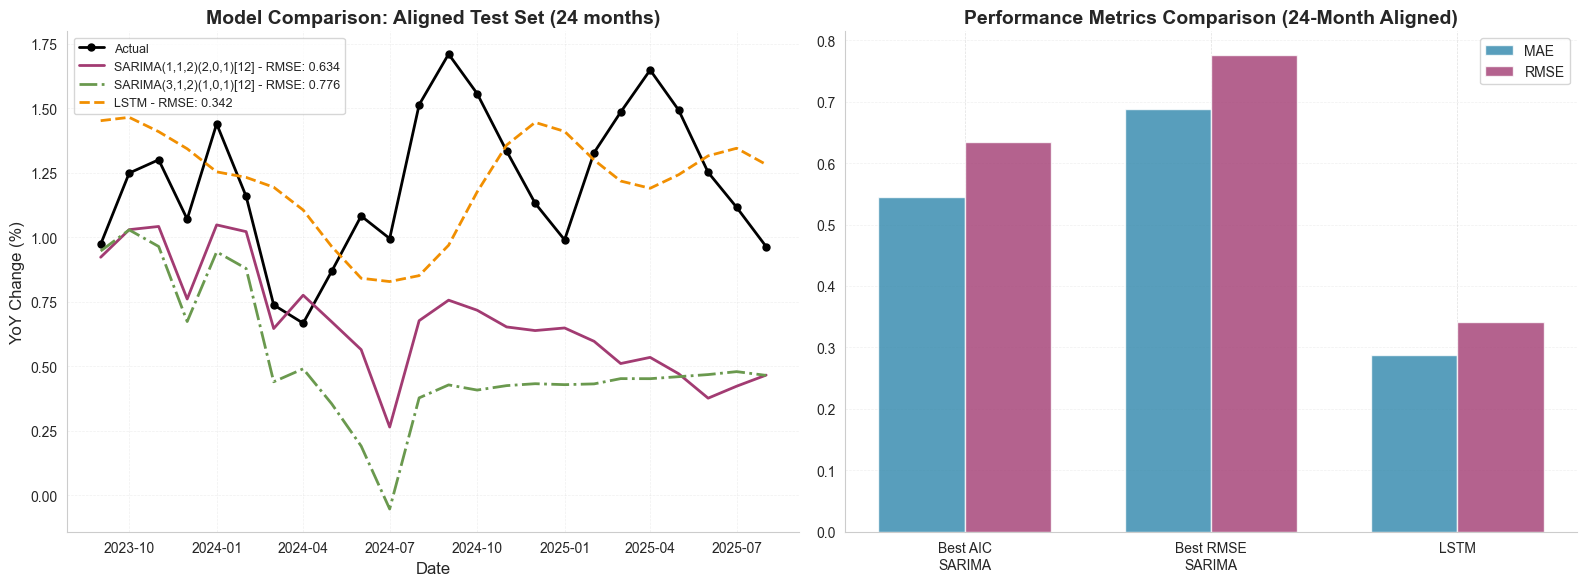

In [144]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Predictions comparison (aligned)
axes[0].plot(common_dates, aligned_actual, 'ko-', label='Actual', linewidth=2, markersize=5)
axes[0].plot(common_dates, aligned_sarima_aic,
             label=f'{BEST_AIC_MODEL["name"]} - RMSE: {sarima_aic_rmse:.3f}', 
             linewidth=2, color=COLORS['best_aic'])
axes[0].plot(common_dates, aligned_sarima_rmse,
             label=f'{BEST_RMSE_MODEL["name"]} - RMSE: {sarima_rmse_rmse_val:.3f}', 
             linewidth=2, color=COLORS['best_rmse'], linestyle='-.')
axes[0].plot(common_dates, aligned_lstm,
             label=f'LSTM - RMSE: {lstm_rmse:.3f}', linewidth=2, color='#F18F01', linestyle='--')
axes[0].set_title(f'Model Comparison: Aligned Test Set ({len(common_dates)} months)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('YoY Change (%)')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Plot 2: Bar chart comparison
metrics_comparison = pd.DataFrame({
    'Model': [BEST_AIC_MODEL['name'], BEST_RMSE_MODEL['name'], 'LSTM'],
    'MAE': [sarima_aic_mae, sarima_rmse_mae, lstm_mae],
    'RMSE': [sarima_aic_rmse, sarima_rmse_rmse_val, lstm_rmse],
})

x = np.arange(3)
width = 0.35
axes[1].bar(x - width/2, metrics_comparison['MAE'], width, label='MAE', color=COLORS['historical'], alpha=0.8)
axes[1].bar(x + width/2, metrics_comparison['RMSE'], width, label='RMSE', color=COLORS['best_aic'], alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Best AIC\nSARIMA', 'Best RMSE\nSARIMA', 'LSTM'], fontsize=10)
axes[1].set_title(f'Performance Metrics Comparison ({len(common_dates)}-Month Aligned)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [145]:
print("\n" + "="*70)
print("SUMMARY: ALIGNED MODEL COMPARISON")
print("="*70)
summary_df = pd.DataFrame({
    'Model': [BEST_AIC_MODEL['name'], BEST_RMSE_MODEL['name'], 'LSTM'],
    'MAE': [sarima_aic_mae, sarima_rmse_mae, lstm_mae],
    'RMSE': [sarima_aic_rmse, sarima_rmse_rmse_val, lstm_rmse],
    'R²': [sarima_aic_r2, sarima_rmse_r2, lstm_r2]
}).sort_values('RMSE').reset_index(drop=True)
summary_df['Rank'] = range(1, len(summary_df) + 1)
print(summary_df[['Rank', 'Model', 'MAE', 'RMSE', 'R²']].to_string(index=False))


SUMMARY: ALIGNED MODEL COMPARISON
 Rank                    Model      MAE     RMSE        R²
    1                     LSTM 0.287100 0.342049 -0.557779
    2 SARIMA(1,1,2)(2,0,1)[12] 0.544241 0.633911 -4.350405
    3 SARIMA(3,1,2)(1,0,1)[12] 0.687257 0.775609 -7.009687


In [146]:
print("While SARIMA(3,1,2)(1,0,1) achieved the lowest cross-validation RMSE (0.161), it performed worse on the hold-out test set (RMSE: 0.776 vs 0.634), indicating overfitting. The simpler model selected by AIC demonstrated superior generalization, validating the use of information criteria over pure CV performance")

While SARIMA(3,1,2)(1,0,1) achieved the lowest cross-validation RMSE (0.161), it performed worse on the hold-out test set (RMSE: 0.776 vs 0.634), indicating overfitting. The simpler model selected by AIC demonstrated superior generalization, validating the use of information criteria over pure CV performance


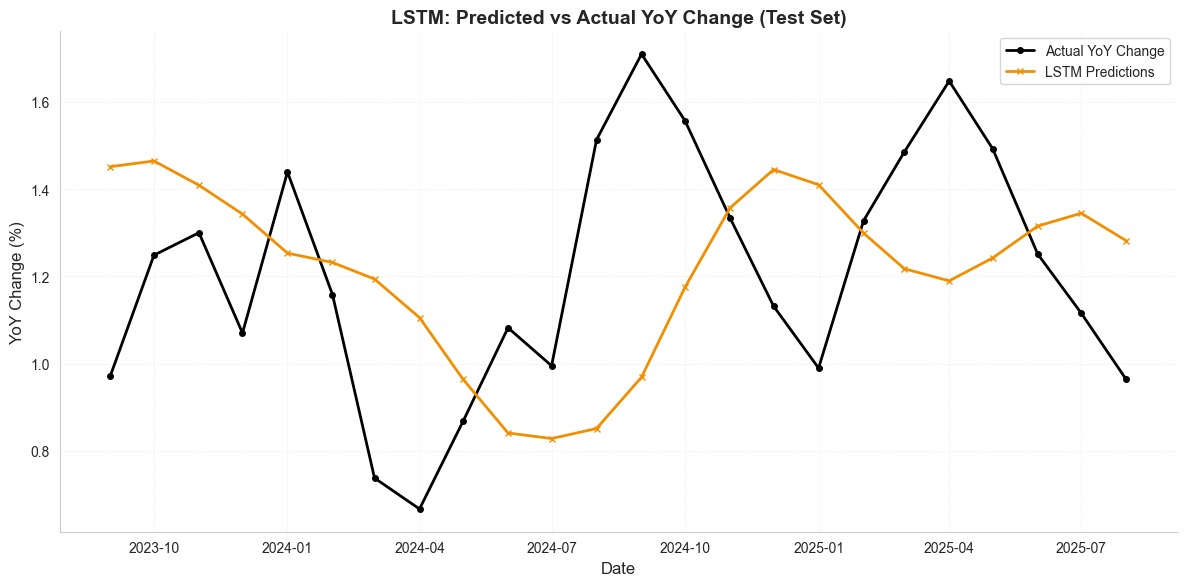

In [147]:
# Corrected code with proper variable names from your analysis

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_dates_lstm, y_test_lstm_actual, label='Actual YoY Change',
        marker='o', linewidth=2, color='black')
ax.plot(test_dates_lstm, predictions_lstm, label='LSTM Predictions',
        marker='x', linewidth=2, color='#F18F01')
ax.set_title('LSTM: Predicted vs Actual YoY Change (Test Set)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('YoY Change (%)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


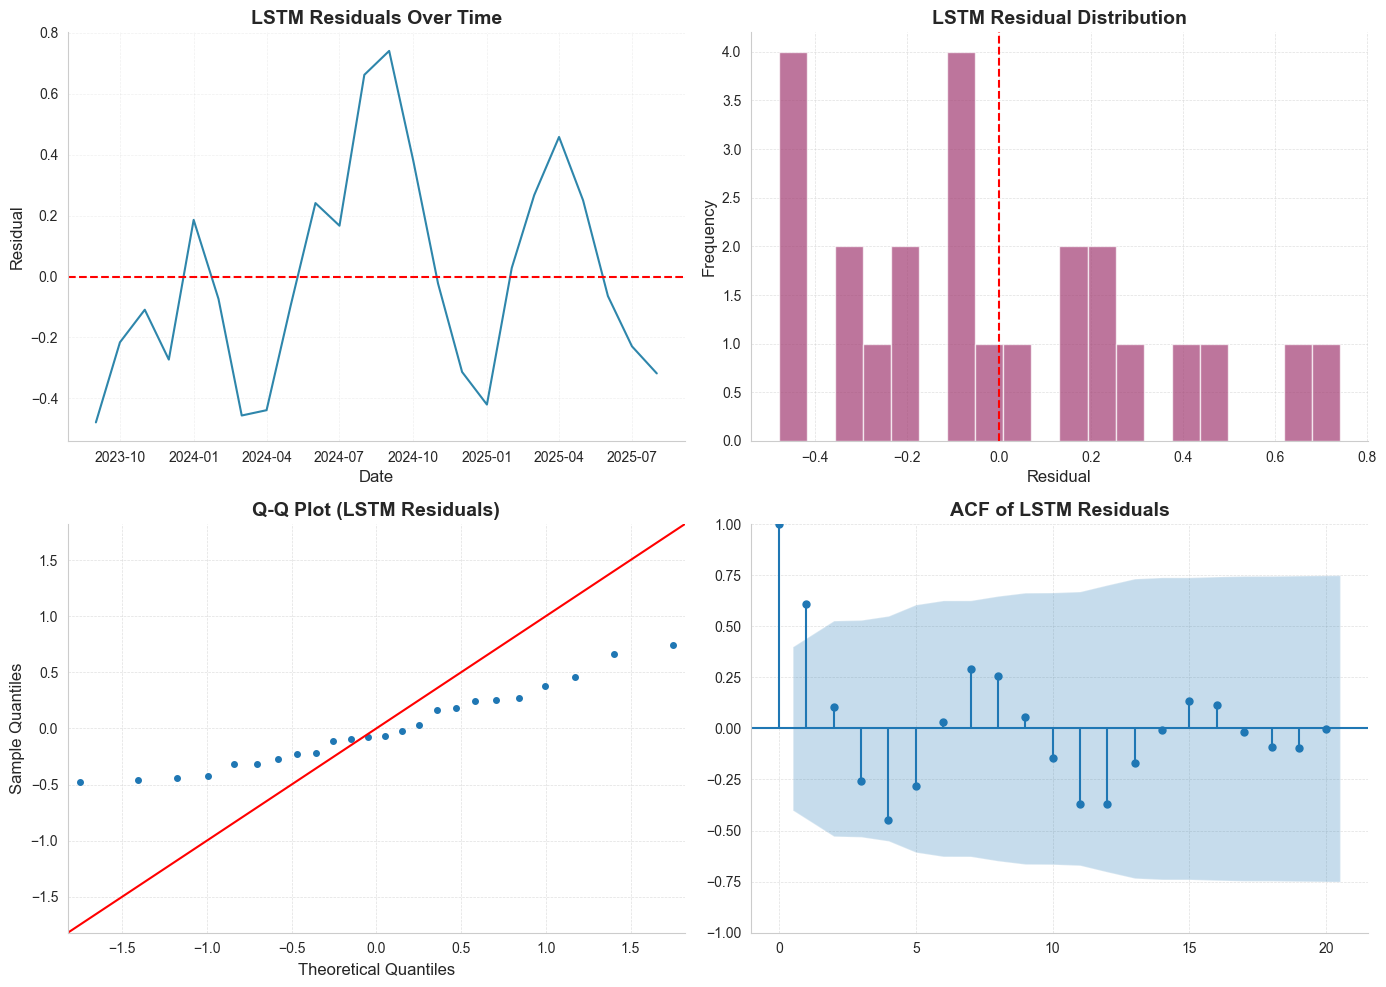

In [148]:
# LSTM Residual Analysis - CORRECTED
lstm_residuals = y_test_lstm_actual.flatten() - predictions_lstm.flatten()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals over time
axes[0, 0].plot(test_dates_lstm, lstm_residuals, color=COLORS['historical'], linewidth=1.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1.5)
axes[0, 0].set_title('LSTM Residuals Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid(True, alpha=0.3)

# Histogram
axes[0, 1].hist(lstm_residuals, bins=20, color=COLORS['best_aic'], edgecolor='white', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=1.5)
axes[0, 1].set_title('LSTM Residual Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')

# Q-Q plot
sm.qqplot(lstm_residuals, line='45', ax=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (LSTM Residuals)', fontsize=14, fontweight='bold')

# ACF of residuals
plot_acf(lstm_residuals, ax=axes[1, 1], lags=20, alpha=0.05)
axes[1, 1].set_title('ACF of LSTM Residuals', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [149]:
print(f"\nLSTM Residual Statistics:")
print(f"  Mean: {np.mean(lstm_residuals):.4f}")
print(f"  Std:  {np.std(lstm_residuals):.4f}")
print(f"  Skewness: {stats.skew(lstm_residuals):.4f}")
print(f"  Kurtosis: {stats.kurtosis(lstm_residuals):.4f}")


LSTM Residual Statistics:
  Mean: -0.0053
  Std:  0.3420
  Skewness: 0.5011
  Kurtosis: -0.6334


In [150]:
def lag_importance(model, X_test, y_test, scaler, seq_length):
    base_predictions = model.predict(X_test, verbose=0)
    base_mse = np.mean((base_predictions.flatten() - y_test.flatten())**2)

    importances = []
    for lag in range(seq_length):
        X_perturbed = X_test.copy()
        X_perturbed[:, lag, :] += np.random.normal(0, 0.1, (X_perturbed.shape[0], 1))
        perturbed_predictions = model.predict(X_perturbed, verbose=0)
        perturbed_mse = np.mean((perturbed_predictions.flatten() - y_test.flatten())**2)
        importances.append(perturbed_mse - base_mse)

    return importances

# Corrected: Use the proper LSTM test variables



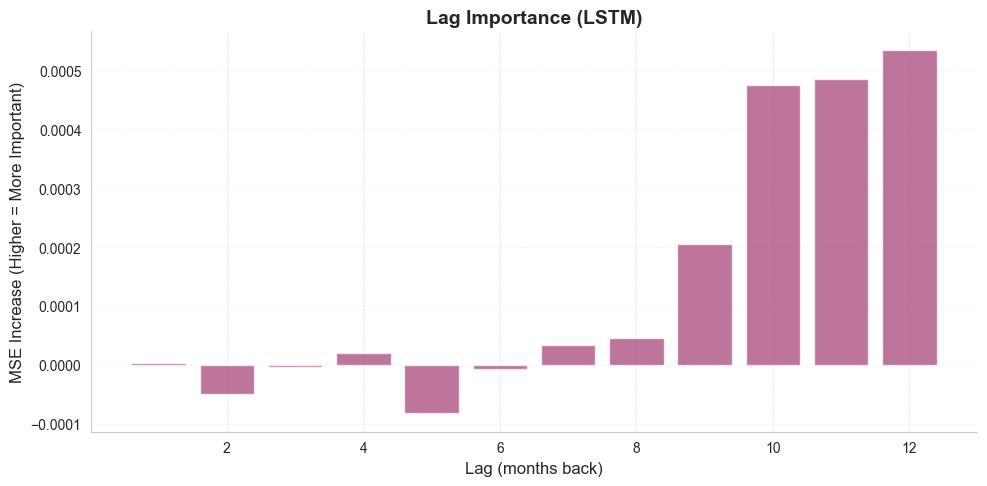

In [151]:
importances = lag_importance(model_lstm, X_test_lstm, y_test_lstm, scaler, seq_length)

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(1, seq_length+1), importances, color='#A23B72', alpha=0.7)
ax.set_title('Lag Importance (LSTM)', fontsize=14, fontweight='bold')
ax.set_xlabel('Lag (months back)')
ax.set_ylabel('MSE Increase (Higher = More Important)')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [152]:
val_size = 12
train_ensemble = yoy_change[:-24-val_size]  # Everything before last 36 months
val_data = yoy_change[-24-val_size:-24]     # Months -36 to -25 (12 months)
test_data_ensemble = yoy_change[-24:]        # Last 24 months


In [153]:
print(f"Ensemble Training: {train_ensemble.index[0].strftime('%Y-%m')} to {train_ensemble.index[-1].strftime('%Y-%m')}")
print(f"Validation: {val_data.index[0].strftime('%Y-%m')} to {val_data.index[-1].strftime('%Y-%m')}")
print(f"Test: {test_data_ensemble.index[0].strftime('%Y-%m')} to {test_data_ensemble.index[-1].strftime('%Y-%m')}")

Ensemble Training: 1965-01 to 2022-08
Validation: 2022-09 to 2023-08
Test: 2023-09 to 2025-08


In [154]:
model_sarima_aic_val = SARIMAX(train_ensemble, 
                                order=BEST_AIC_MODEL['order'], 
                                seasonal_order=BEST_AIC_MODEL['seasonal_order'])
result_sarima_aic_val = model_sarima_aic_val.fit(disp=False)
sarima_aic_val_pred = result_sarima_aic_val.forecast(steps=val_size)

model_sarima_rmse_val = SARIMAX(train_ensemble, 
                                 order=BEST_RMSE_MODEL['order'], 
                                 seasonal_order=BEST_RMSE_MODEL['seasonal_order'])
result_sarima_rmse_val = model_sarima_rmse_val.fit(disp=False)
sarima_rmse_val_pred = result_sarima_rmse_val.forecast(steps=val_size)

sarima_aic_val_rmse = np.sqrt(mean_squared_error(val_data.values, sarima_aic_val_pred.values))
sarima_rmse_val_rmse = np.sqrt(mean_squared_error(val_data.values, sarima_rmse_val_pred.values))

print(f"\nValidation RMSE:")
print(f"  {BEST_AIC_MODEL['name']}: {sarima_aic_val_rmse:.4f}")
print(f"  {BEST_RMSE_MODEL['name']}: {sarima_rmse_val_rmse:.4f}")


Validation RMSE:
  SARIMA(1,1,2)(2,0,1)[12]: 0.4786
  SARIMA(3,1,2)(1,0,1)[12]: 0.7190


In [155]:
ensemble_simple_val = (sarima_aic_val_pred.values + sarima_rmse_val_pred.values) / 2
ensemble_simple_val_rmse = np.sqrt(mean_squared_error(val_data.values, ensemble_simple_val))

weight_aic = (1/sarima_aic_val_rmse) / (1/sarima_aic_val_rmse + 1/sarima_rmse_val_rmse)
weight_rmse = (1/sarima_rmse_val_rmse) / (1/sarima_aic_val_rmse + 1/sarima_rmse_val_rmse)

ensemble_weighted_val = weight_aic * sarima_aic_val_pred.values + weight_rmse * sarima_rmse_val_pred.values
ensemble_weighted_val_rmse = np.sqrt(mean_squared_error(val_data.values, ensemble_weighted_val))

In [156]:
print(f"\nEnsemble Weights (Inverse RMSE):")
print(f"  {BEST_AIC_MODEL['name']}: {weight_aic:.4f}")
print(f"  {BEST_RMSE_MODEL['name']}: {weight_rmse:.4f}")

print(f"\nValidation RMSE Comparison:")
print(f"  {BEST_AIC_MODEL['name']}: {sarima_aic_val_rmse:.4f}")
print(f"  {BEST_RMSE_MODEL['name']}: {sarima_rmse_val_rmse:.4f}")
print(f"  Simple Average: {ensemble_simple_val_rmse:.4f}")
print(f"  Inverse RMSE Weighted: {ensemble_weighted_val_rmse:.4f}")


Ensemble Weights (Inverse RMSE):
  SARIMA(1,1,2)(2,0,1)[12]: 0.6004
  SARIMA(3,1,2)(1,0,1)[12]: 0.3996

Validation RMSE Comparison:
  SARIMA(1,1,2)(2,0,1)[12]: 0.4786
  SARIMA(3,1,2)(1,0,1)[12]: 0.7190
  Simple Average: 0.5974
  Inverse RMSE Weighted: 0.5733


In [157]:
train_plus_val = yoy_change[:-24]

# Fit both models on train+val
model_sarima_aic_final = SARIMAX(train_plus_val, 
                                  order=BEST_AIC_MODEL['order'], 
                                  seasonal_order=BEST_AIC_MODEL['seasonal_order'])
result_sarima_aic_final = model_sarima_aic_final.fit(disp=False)
sarima_aic_test_pred = result_sarima_aic_final.forecast(steps=24)

model_sarima_rmse_final = SARIMAX(train_plus_val, 
                                   order=BEST_RMSE_MODEL['order'], 
                                   seasonal_order=BEST_RMSE_MODEL['seasonal_order'])
result_sarima_rmse_final = model_sarima_rmse_final.fit(disp=False)
sarima_rmse_test_pred = result_sarima_rmse_final.forecast(steps=24)

In [158]:
# Apply the learned weights from validation to test predictions
ensemble_simple_test = (sarima_aic_test_pred.values + sarima_rmse_test_pred.values) / 2
ensemble_weighted_test = weight_aic * sarima_aic_test_pred.values + weight_rmse * sarima_rmse_test_pred.values

# Calculate test RMSE
sarima_aic_test_rmse = np.sqrt(mean_squared_error(test_data_ensemble.values, sarima_aic_test_pred.values))
sarima_rmse_test_rmse = np.sqrt(mean_squared_error(test_data_ensemble.values, sarima_rmse_test_pred.values))
ensemble_simple_test_rmse = np.sqrt(mean_squared_error(test_data_ensemble.values, ensemble_simple_test))
ensemble_weighted_test_rmse = np.sqrt(mean_squared_error(test_data_ensemble.values, ensemble_weighted_test))

In [159]:
print("\n" + "="*70)
print("FINAL TEST SET PERFORMANCE")
print("="*70)
print(f"\nTest RMSE (24-month hold-out):")
print(f"  {BEST_AIC_MODEL['name']}: {sarima_aic_test_rmse:.4f}")
print(f"  {BEST_RMSE_MODEL['name']}: {sarima_rmse_test_rmse:.4f}")
print(f"  Simple Average Ensemble: {ensemble_simple_test_rmse:.4f}")
print(f"  Weighted Ensemble (weights from val): {ensemble_weighted_test_rmse:.4f}")

print(f"\nWeights used (learned from validation):")
print(f"  {BEST_AIC_MODEL['name']}: {weight_aic:.4f}")
print(f"  {BEST_RMSE_MODEL['name']}: {weight_rmse:.4f}")


FINAL TEST SET PERFORMANCE

Test RMSE (24-month hold-out):
  SARIMA(1,1,2)(2,0,1)[12]: 0.6339
  SARIMA(3,1,2)(1,0,1)[12]: 0.7756
  Simple Average Ensemble: 0.7010
  Weighted Ensemble (weights from val): 0.6868

Weights used (learned from validation):
  SARIMA(1,1,2)(2,0,1)[12]: 0.6004
  SARIMA(3,1,2)(1,0,1)[12]: 0.3996


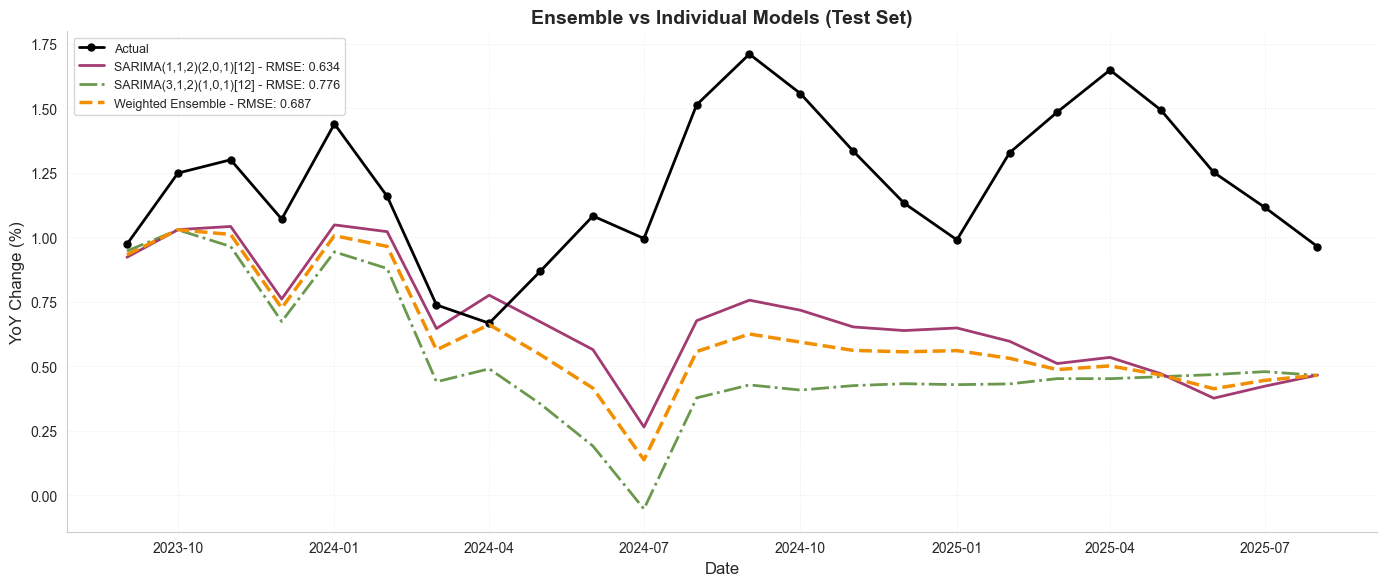

In [160]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(test_data_ensemble.index, test_data_ensemble.values, 'ko-', 
        label='Actual', linewidth=2, markersize=5, zorder=4)
ax.plot(test_data_ensemble.index, sarima_aic_test_pred.values,
        label=f'{BEST_AIC_MODEL["name"]} - RMSE: {sarima_aic_test_rmse:.3f}', 
        linewidth=2, color=COLORS['best_aic'], zorder=3)
ax.plot(test_data_ensemble.index, sarima_rmse_test_pred.values,
        label=f'{BEST_RMSE_MODEL["name"]} - RMSE: {sarima_rmse_test_rmse:.3f}', 
        linewidth=2, color=COLORS['best_rmse'], linestyle='-.', zorder=2)
ax.plot(test_data_ensemble.index, ensemble_weighted_test,
        label=f'Weighted Ensemble - RMSE: {ensemble_weighted_test_rmse:.3f}', 
        linewidth=2.5, color='#F18F01', linestyle='--', zorder=5)
ax.set_title('Ensemble vs Individual Models (Test Set)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('YoY Change (%)')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [161]:
# Ensemble Method 3: Meta-Learner (Ridge Regression)
X_val_meta = np.column_stack([sarima_aic_val_pred.values, sarima_rmse_val_pred.values])
y_val_meta = val_data.values

meta_learner = Ridge(alpha=1.0)
meta_learner.fit(X_val_meta, y_val_meta)

print(f"\nMeta-Learner Coefficients:")
print(f"  {BEST_AIC_MODEL['name']}: {meta_learner.coef_[0]:.4f}")
print(f"  {BEST_RMSE_MODEL['name']}: {meta_learner.coef_[1]:.4f}")
print(f"  Intercept: {meta_learner.intercept_:.4f}")


Meta-Learner Coefficients:
  SARIMA(1,1,2)(2,0,1)[12]: 0.6912
  SARIMA(3,1,2)(1,0,1)[12]: 0.6006
  Intercept: 0.6408


In [162]:
# Meta-learner validation prediction
meta_val_pred = meta_learner.predict(X_val_meta)
meta_val_rmse = np.sqrt(mean_squared_error(val_data.values, meta_val_pred))
print(f"  Meta-Learner Validation RMSE: {meta_val_rmse:.4f}")

  Meta-Learner Validation RMSE: 0.1623


In [163]:
train_for_test = yoy_change[:-24]

model_sarima_aic_final = SARIMAX(train_for_test, 
                                  order=BEST_AIC_MODEL['order'], 
                                  seasonal_order=BEST_AIC_MODEL['seasonal_order'])
result_sarima_aic_final = model_sarima_aic_final.fit(disp=False)
sarima_aic_test_pred = result_sarima_aic_final.forecast(steps=24)

model_sarima_rmse_final = SARIMAX(train_for_test, 
                                   order=BEST_RMSE_MODEL['order'], 
                                   seasonal_order=BEST_RMSE_MODEL['seasonal_order'])
result_sarima_rmse_final = model_sarima_rmse_final.fit(disp=False)
sarima_rmse_test_pred = result_sarima_rmse_final.forecast(steps=24)

In [164]:
ensemble_simple_test = (sarima_aic_test_pred.values + sarima_rmse_test_pred.values) / 2
ensemble_weighted_test = weight_aic * sarima_aic_test_pred.values + weight_rmse * sarima_rmse_test_pred.values

X_test_meta = np.column_stack([sarima_aic_test_pred.values, sarima_rmse_test_pred.values])
ensemble_meta_test = meta_learner.predict(X_test_meta)

In [165]:
test_data_values = test_data_ensemble.values

sarima_aic_test_rmse = np.sqrt(mean_squared_error(test_data_values, sarima_aic_test_pred.values))
sarima_rmse_test_rmse = np.sqrt(mean_squared_error(test_data_values, sarima_rmse_test_pred.values))
ensemble_simple_test_rmse = np.sqrt(mean_squared_error(test_data_values, ensemble_simple_test))
ensemble_weighted_test_rmse = np.sqrt(mean_squared_error(test_data_values, ensemble_weighted_test))
ensemble_meta_test_rmse = np.sqrt(mean_squared_error(test_data_values, ensemble_meta_test))

In [166]:
print("\n" + "="*70)
print("ENSEMBLE TEST SET PERFORMANCE (24-Month)")
print("="*70)
print(f"{BEST_AIC_MODEL['name']:<40} RMSE: {sarima_aic_test_rmse:.4f}")
print(f"{BEST_RMSE_MODEL['name']:<40} RMSE: {sarima_rmse_test_rmse:.4f}")
print(f"{'Ensemble: Simple Average':<40} RMSE: {ensemble_simple_test_rmse:.4f}")
print(f"{'Ensemble: Inverse RMSE Weighted':<40} RMSE: {ensemble_weighted_test_rmse:.4f}")
print(f"{'Ensemble: Meta-Learner (Ridge)':<40} RMSE: {ensemble_meta_test_rmse:.4f}")


ENSEMBLE TEST SET PERFORMANCE (24-Month)
SARIMA(1,1,2)(2,0,1)[12]                 RMSE: 0.6339
SARIMA(3,1,2)(1,0,1)[12]                 RMSE: 0.7756
Ensemble: Simple Average                 RMSE: 0.7010
Ensemble: Inverse RMSE Weighted          RMSE: 0.6868
Ensemble: Meta-Learner (Ridge)           RMSE: 0.4391


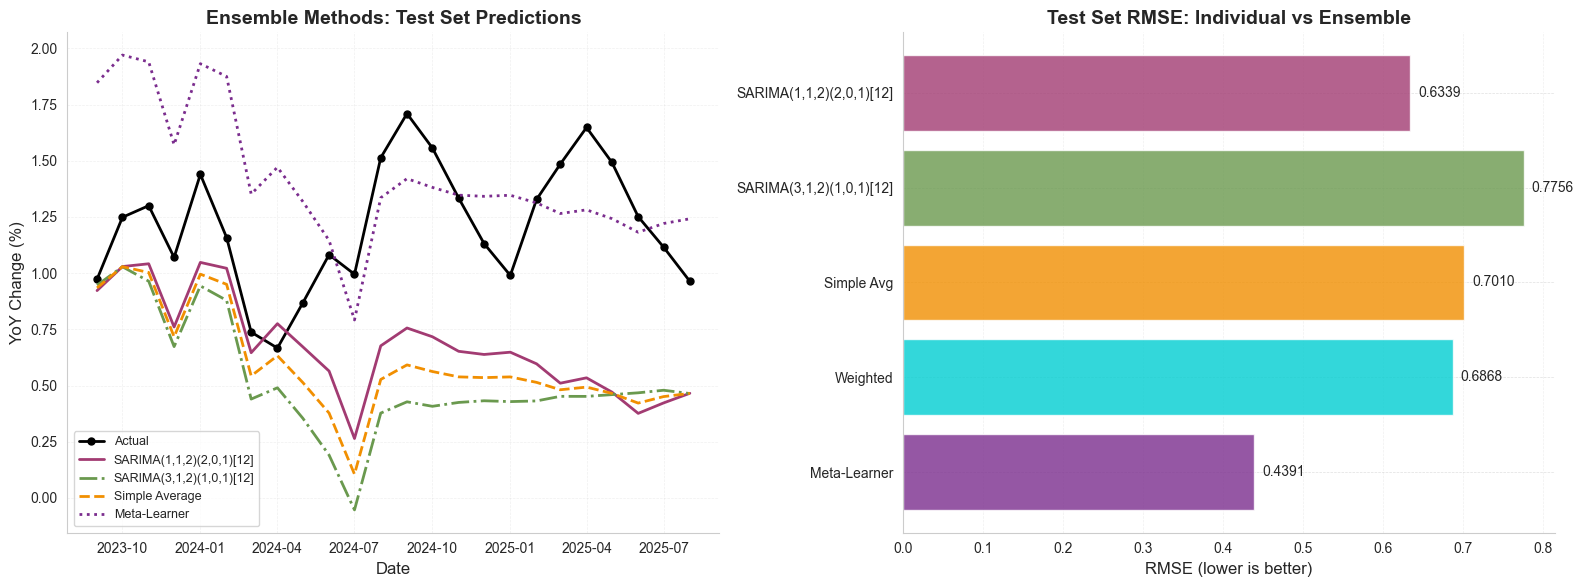

In [167]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Test predictions comparison
axes[0].plot(test_data_ensemble.index, test_data_values, 'ko-', label='Actual', linewidth=2, markersize=5)
axes[0].plot(test_data_ensemble.index, sarima_aic_test_pred.values, 
             label=f'{BEST_AIC_MODEL["name"]}', color=COLORS['best_aic'], linewidth=2)
axes[0].plot(test_data_ensemble.index, sarima_rmse_test_pred.values, 
             label=f'{BEST_RMSE_MODEL["name"]}', color=COLORS['best_rmse'], linewidth=2, linestyle='-.')
axes[0].plot(test_data_ensemble.index, ensemble_simple_test, 
             label='Simple Average', color='#F18F01', linewidth=2, linestyle='--')
axes[0].plot(test_data_ensemble.index, ensemble_meta_test, 
             label='Meta-Learner', color='#7B2D8E', linewidth=2, linestyle=':')

axes[0].set_title('Ensemble Methods: Test Set Predictions', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('YoY Change (%)')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# RMSE comparison
models_ensemble = [BEST_AIC_MODEL['name'], BEST_RMSE_MODEL['name'], 
                   'Simple Avg', 'Weighted', 'Meta-Learner']
rmses_ensemble = [sarima_aic_test_rmse, sarima_rmse_test_rmse, 
                  ensemble_simple_test_rmse, ensemble_weighted_test_rmse, ensemble_meta_test_rmse]
colors_ensemble = [COLORS['best_aic'], COLORS['best_rmse'], '#F18F01', '#00CED1', '#7B2D8E']

axes[1].barh(models_ensemble, rmses_ensemble, color=colors_ensemble, alpha=0.8)
axes[1].set_xlabel('RMSE (lower is better)', fontsize=12)
axes[1].set_title('Test Set RMSE: Individual vs Ensemble', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(rmses_ensemble):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
from tqdm import tqdm

def bootstrap_forecast_ci(model_order, seasonal_order, data, forecast_horizon, n_bootstrap=1000, ci=0.95):
    """
    Generate bootstrap confidence intervals for SARIMA forecast
    """
    np.random.seed(42)
    
    # Fit model on original data
    model = SARIMAX(data, order=model_order, seasonal_order=seasonal_order)
    result = model.fit(disp=False)
    
    residuals = result.resid.dropna()
    point_forecast = result.get_forecast(steps=forecast_horizon).predicted_mean.values
    
    bootstrap_forecasts = []
    
    # Add tqdm progress bar
    for b in tqdm(range(n_bootstrap), desc="Bootstrap iterations", unit="iter"):
        # Resample residuals
        boot_residuals = np.random.choice(residuals, size=len(data), replace=True)
        
        # Create bootstrapped series
        fitted_values = result.fittedvalues
        boot_series = fitted_values + boot_residuals[:len(fitted_values)]
        boot_series = pd.Series(boot_series, index=data.index[:len(boot_series)])
        
        try:
            # Fit model on bootstrapped data
            boot_model = SARIMAX(boot_series, order=model_order, seasonal_order=seasonal_order)
            boot_result = boot_model.fit(disp=False, maxiter=100)
            boot_forecast = boot_result.forecast(steps=forecast_horizon)
            bootstrap_forecasts.append(boot_forecast.values)
        except:
            continue
    
    bootstrap_forecasts = np.array(bootstrap_forecasts)
    
    # Calculate percentiles
    alpha = 1 - ci
    lower = np.percentile(bootstrap_forecasts, alpha/2 * 100, axis=0)
    upper = np.percentile(bootstrap_forecasts, (1 - alpha/2) * 100, axis=0)
    
    return point_forecast, lower, upper, bootstrap_forecasts

# %%




In [169]:
print("Running bootstrap for confidence intervals (this may take a few minutes)...")
print(f"Model: {BEST_AIC_MODEL['name']}")

point_forecast_boot, ci_lower_boot, ci_upper_boot, all_bootstraps = bootstrap_forecast_ci(
    model_order=BEST_AIC_MODEL['order'],
    seasonal_order=BEST_AIC_MODEL['seasonal_order'],
    data=yoy_change,
    forecast_horizon=24,
    n_bootstrap=50,  # Reduced for speed
    ci=0.95
)

Running bootstrap for confidence intervals (this may take a few minutes)...
Model: SARIMA(1,1,2)(2,0,1)[12]


In [170]:
print(f"\nBootstrap completed with {len(all_bootstraps)} successful iterations")


Bootstrap completed with 50 successful iterations


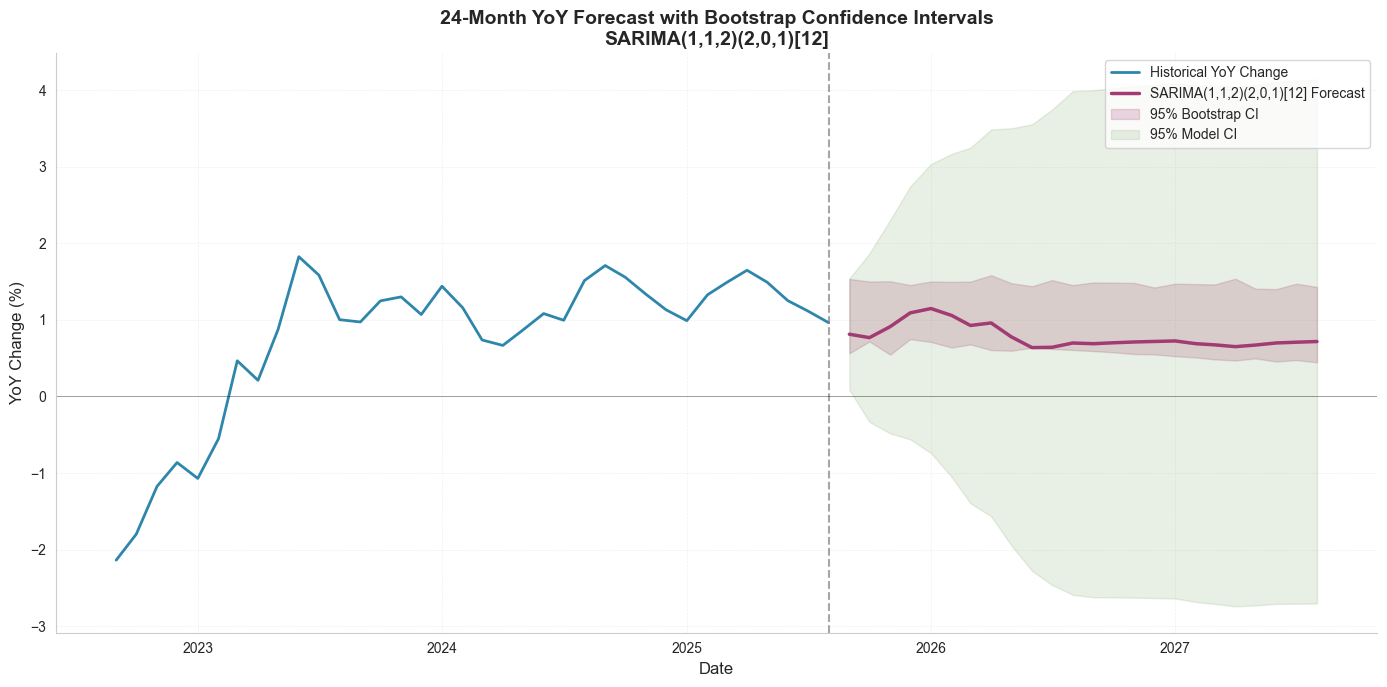

In [171]:
forecast_dates_boot = pd.date_range(
    start=yoy_change.index[-1] + pd.DateOffset(months=1),
    periods=24,
    freq='MS'
)

fig, ax = plt.subplots(figsize=(14, 7))

# Historical data
recent_yoy = yoy_change[-36:]
ax.plot(recent_yoy.index, recent_yoy.values, color=COLORS['historical'], 
        linewidth=2, label='Historical YoY Change')

# Point forecast
ax.plot(forecast_dates_boot, point_forecast_boot, color=COLORS['best_aic'], 
        linewidth=2.5, label=f'{BEST_AIC_MODEL["name"]} Forecast')

# Bootstrap CI
ax.fill_between(forecast_dates_boot, ci_lower_boot, ci_upper_boot, 
                color=COLORS['best_aic'], alpha=0.2, label='95% Bootstrap CI')

# Model-based CI (for comparison)
model_ci = SARIMAX(yoy_change, order=BEST_AIC_MODEL['order'], 
                   seasonal_order=BEST_AIC_MODEL['seasonal_order'])
result_ci = model_ci.fit(disp=False)
forecast_ci = result_ci.get_forecast(steps=24)
conf_int_model = forecast_ci.conf_int()

ax.fill_between(forecast_dates_boot, conf_int_model.iloc[:, 0], conf_int_model.iloc[:, 1],
                color=COLORS['best_rmse'], alpha=0.15, label='95% Model CI')

ax.axvline(x=yoy_change.index[-1], color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

ax.set_title(f'24-Month YoY Forecast with Bootstrap Confidence Intervals\n{BEST_AIC_MODEL["name"]}',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('YoY Change (%)', fontsize=12)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [172]:
model_aic_full = SARIMAX(yoy_change, 
                          order=BEST_AIC_MODEL['order'], 
                          seasonal_order=BEST_AIC_MODEL['seasonal_order'])
result_aic_full = model_aic_full.fit(disp=False)
forecast_aic_full = result_aic_full.get_forecast(steps=FORECAST_HORIZON)


In [173]:
model_rmse_full = SARIMAX(yoy_change, 
                           order=BEST_RMSE_MODEL['order'], 
                           seasonal_order=BEST_RMSE_MODEL['seasonal_order'])
result_rmse_full = model_rmse_full.fit(disp=False)
forecast_rmse_full = result_rmse_full.get_forecast(steps=FORECAST_HORIZON)


In [174]:
ensemble_forecast_yoy = (forecast_aic_full.predicted_mean.values + forecast_rmse_full.predicted_mean.values) / 2


In [175]:
ensemble_forecast_wages = true_wages_clean.copy()
aic_forecast_wages_full = true_wages_clean.copy()
rmse_forecast_wages_full = true_wages_clean.copy()

In [176]:
for i in range(FORECAST_HORIZON):
    forecast_date = true_wages_clean.index[-1] + pd.DateOffset(months=i+1)
    wages_12_early_ens = ensemble_forecast_wages.iloc[-12]
    wages_12_early_aic = aic_forecast_wages_full.iloc[-12]
    wages_12_early_rmse = rmse_forecast_wages_full.iloc[-12]
    
    ensemble_forecast_wages.loc[forecast_date] = wages_12_early_ens * (1 + ensemble_forecast_yoy[i] / 100)
    aic_forecast_wages_full.loc[forecast_date] = wages_12_early_aic * (1 + forecast_aic_full.predicted_mean.iloc[i] / 100)
    rmse_forecast_wages_full.loc[forecast_date] = wages_12_early_rmse * (1 + forecast_rmse_full.predicted_mean.iloc[i] / 100)

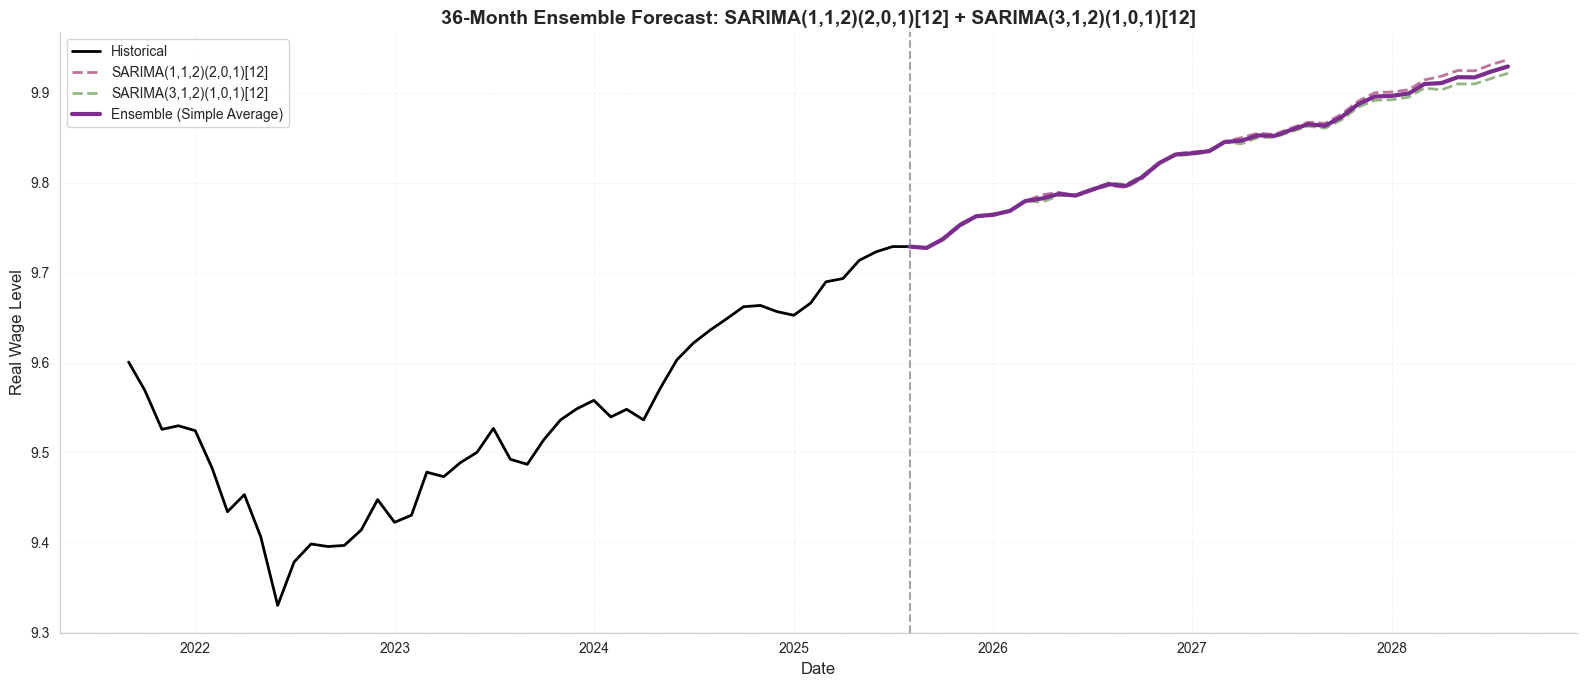

In [177]:
fig, ax = plt.subplots(figsize=(16, 7))

recent_hist = true_wages_clean[-48:]
ax.plot(recent_hist.index, recent_hist.values, color='black', linewidth=2, label='Historical')

# Connect forecasts to last historical point
last_hist = true_wages_clean.iloc[[-1]]

connected_aic = pd.concat([last_hist, aic_forecast_wages_full[-FORECAST_HORIZON:]])
connected_rmse = pd.concat([last_hist, rmse_forecast_wages_full[-FORECAST_HORIZON:]])
connected_ensemble = pd.concat([last_hist, ensemble_forecast_wages[-FORECAST_HORIZON:]])

ax.plot(connected_aic.index, connected_aic.values, 
        color=COLORS['best_aic'], linewidth=2, linestyle='--',
        label=f'{BEST_AIC_MODEL["name"]}', alpha=0.7)
ax.plot(connected_rmse.index, connected_rmse.values, 
        color=COLORS['best_rmse'], linewidth=2, linestyle='--',
        label=f'{BEST_RMSE_MODEL["name"]}', alpha=0.7)
ax.plot(connected_ensemble.index, connected_ensemble.values, 
        color='#7B2D8E', linewidth=3,
        label='Ensemble (Simple Average)')

ax.axvline(x=true_wages_clean.index[-1], color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

ax.set_title(f'{FORECAST_HORIZON}-Month Ensemble Forecast: {BEST_AIC_MODEL["name"]} + {BEST_RMSE_MODEL["name"]}',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Real Wage Level', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [178]:
print(f"\n{FORECAST_HORIZON}-Month Ensemble Forecast Summary:")
print(f"  Starting Value: {true_wages_clean.iloc[-1]:.4f}")
print(f"  Final Ensemble Value: {ensemble_forecast_wages.iloc[-1]:.4f}")
print(f"  Total Change: {((ensemble_forecast_wages.iloc[-1] / true_wages_clean.iloc[-1]) - 1) * 100:.2f}%")


36-Month Ensemble Forecast Summary:
  Starting Value: 9.7290
  Final Ensemble Value: 9.9292
  Total Change: 2.06%


In [179]:
prophet_data = pd.DataFrame({
    'ds': yoy_change.index,
    'y': yoy_change.values
})

In [180]:
prophet_train = prophet_data[:-24]
prophet_test = prophet_data[-24:]

# Fit Prophet model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive'
)
prophet_model.fit(prophet_train)

15:37:20 - cmdstanpy - INFO - Chain [1] start processing
15:37:21 - cmdstanpy - INFO - Chain [1] done processing


In [181]:
future = prophet_model.make_future_dataframe(periods=24, freq='MS')
prophet_forecast = prophet_model.predict(future)

# Extract test predictions
prophet_test_pred = prophet_forecast[-24:]['yhat'].values

# Calculate metrics
prophet_test_rmse = np.sqrt(mean_squared_error(prophet_test['y'].values, prophet_test_pred))
prophet_test_mae = mean_absolute_error(prophet_test['y'].values, prophet_test_pred)
prophet_test_r2 = r2_score(prophet_test['y'].values, prophet_test_pred)


In [182]:
print("="*70)
print("PROPHET MODEL PERFORMANCE (24-Month Test)")
print("="*70)
print(f"  MAE:  {prophet_test_mae:.4f}")
print(f"  RMSE: {prophet_test_rmse:.4f}")
print(f"  R²:   {prophet_test_r2:.4f}")

PROPHET MODEL PERFORMANCE (24-Month Test)
  MAE:  0.2277
  RMSE: 0.2742
  R²:   -0.0012


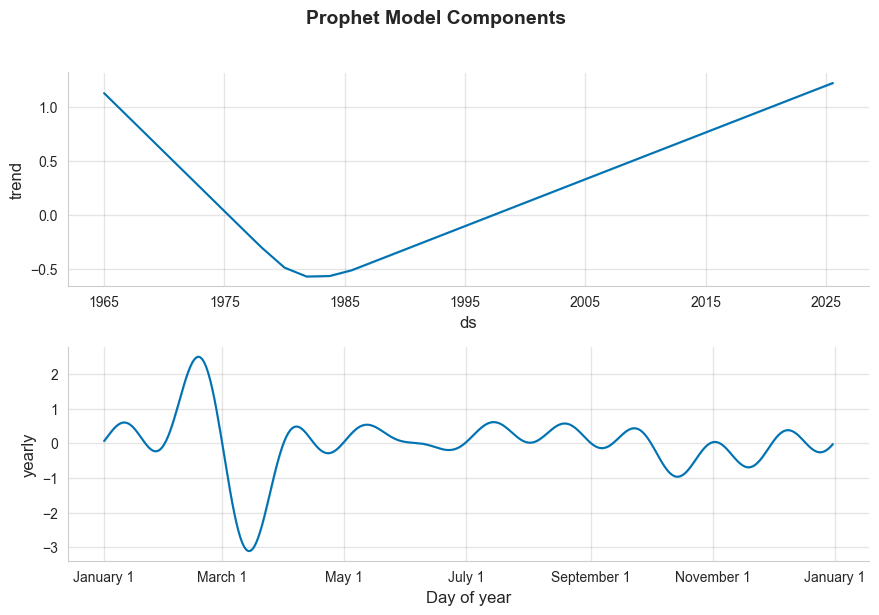

In [183]:
fig = prophet_model.plot_components(prophet_forecast)
plt.suptitle('Prophet Model Components', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

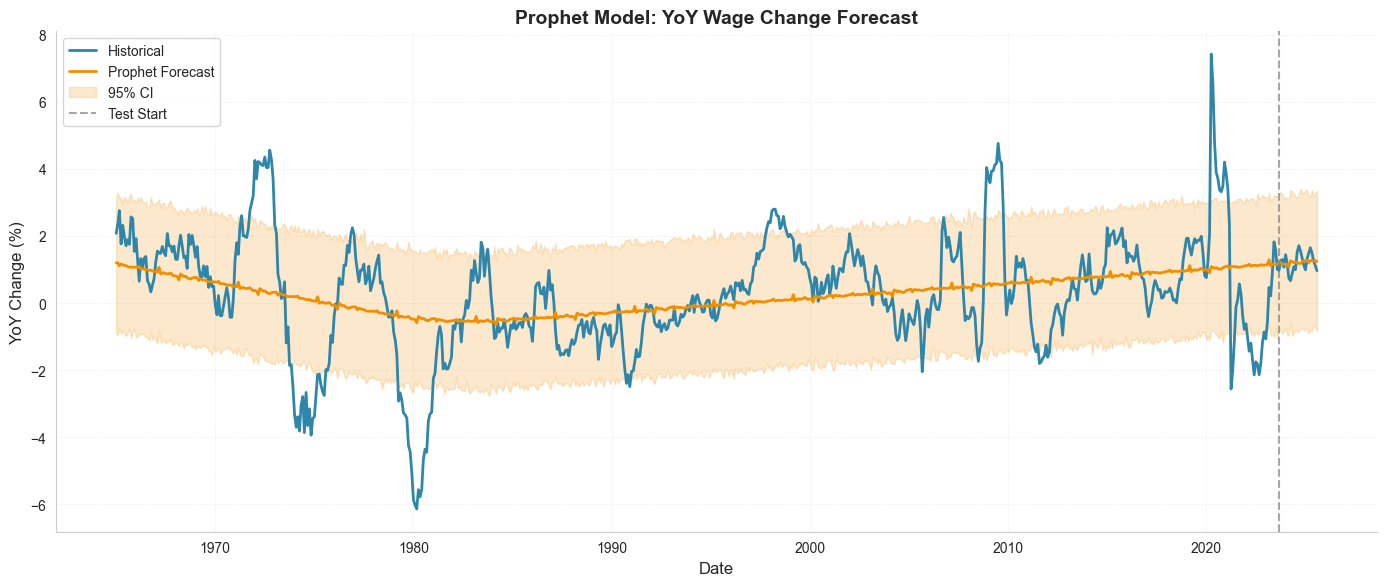

In [184]:
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(yoy_change.index, yoy_change.values, color=COLORS['historical'], 
        linewidth=2, label='Historical')
ax.plot(prophet_forecast['ds'], prophet_forecast['yhat'], 
        color='#F18F01', linewidth=2, label='Prophet Forecast')
ax.fill_between(prophet_forecast['ds'], 
                prophet_forecast['yhat_lower'], 
                prophet_forecast['yhat_upper'],
                color='#F18F01', alpha=0.2, label='95% CI')

ax.axvline(x=yoy_change.index[-24], color='gray', linestyle='--', 
           linewidth=1.5, alpha=0.7, label='Test Start')

ax.set_title('Prophet Model: YoY Wage Change Forecast', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('YoY Change (%)', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [185]:
train_garch = yoy_change[:-24]
test_garch = yoy_change[-24:]

model_sarima_garch = SARIMAX(train_garch, 
                              order=BEST_AIC_MODEL['order'], 
                              seasonal_order=BEST_AIC_MODEL['seasonal_order'])
result_sarima_garch = model_sarima_garch.fit(disp=False)

# Get SARIMA residuals for GARCH modeling
sarima_residuals = result_sarima_garch.resid.dropna()

# Fit GARCH(1,1) on SARIMA residuals
garch_model = arch_model(sarima_residuals * 100, vol='Garch', p=1, q=1, rescale=False)
garch_result = garch_model.fit(disp='off')


In [186]:
print("="*70)
print("SARIMA-GARCH MODEL")
print("="*70)
print(f"SARIMA: {BEST_AIC_MODEL['name']}")
print("\nGARCH(1,1) Summary:")
print(garch_result.summary().tables[1])

SARIMA-GARCH MODEL
SARIMA: SARIMA(1,1,2)(2,0,1)[12]

GARCH(1,1) Summary:
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.2504      1.043     -0.240      0.810 [ -2.294,  1.793]


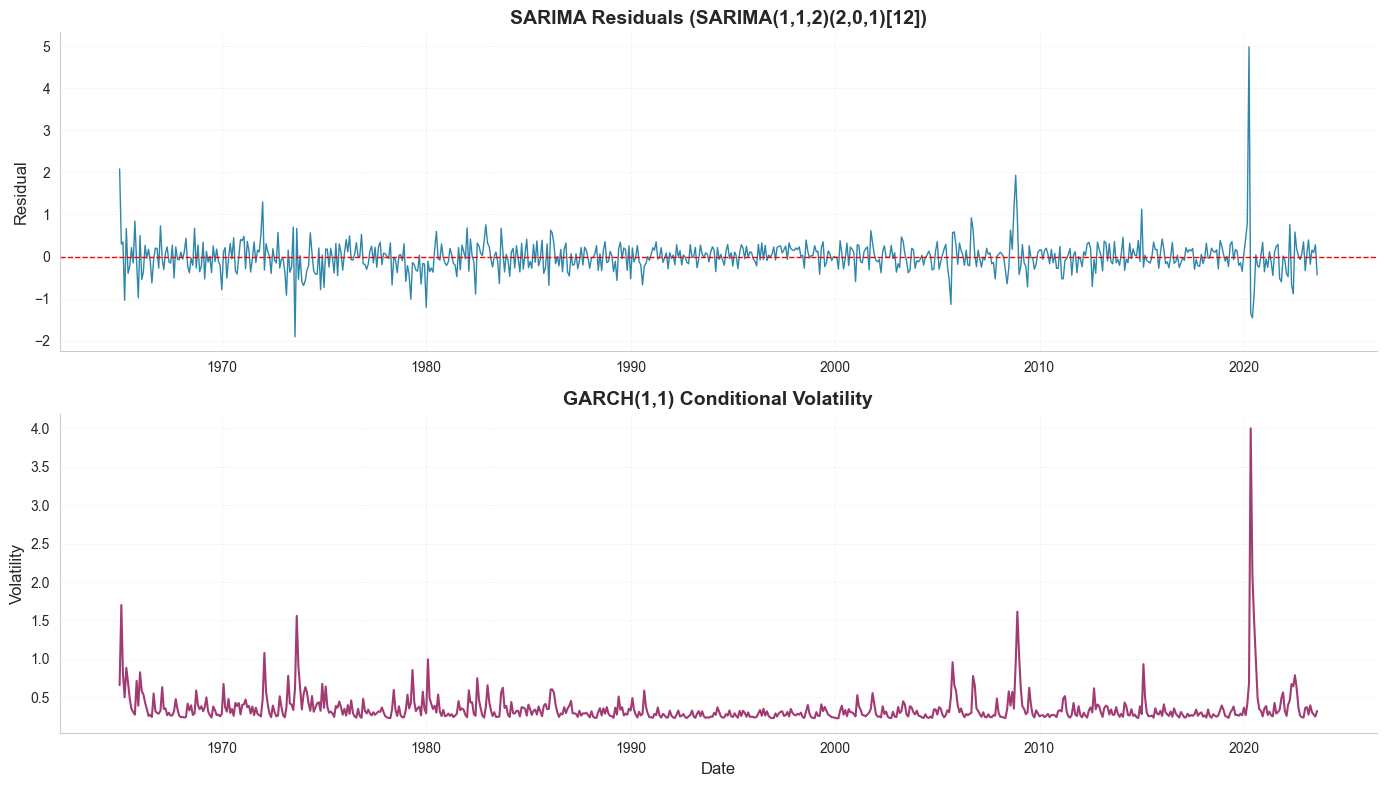

In [187]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# SARIMA residuals
axes[0].plot(sarima_residuals.index, sarima_residuals.values, 
             color=COLORS['historical'], linewidth=1)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].set_title(f'SARIMA Residuals ({BEST_AIC_MODEL["name"]})', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Residual')
axes[0].grid(True, alpha=0.3)

# Conditional volatility
cond_vol = garch_result.conditional_volatility / 100
axes[1].plot(sarima_residuals.index, cond_vol, 
             color=COLORS['best_aic'], linewidth=1.5)
axes[1].set_title('GARCH(1,1) Conditional Volatility', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Volatility')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [188]:
sarima_forecast_garch = result_sarima_garch.forecast(steps=24)

# GARCH variance forecast
garch_forecast = garch_result.forecast(horizon=24)
garch_variance = garch_forecast.variance.iloc[-1].values / 10000

sarima_garch_rmse = np.sqrt(mean_squared_error(test_garch.values, sarima_forecast_garch.values))
print(f"\nSARIMA-GARCH Test RMSE: {sarima_garch_rmse:.4f}")
print("(Note: GARCH models volatility, not point forecast - RMSE same as SARIMA)")


SARIMA-GARCH Test RMSE: 0.6339
(Note: GARCH models volatility, not point forecast - RMSE same as SARIMA)


In [193]:
train_theta = yoy_change[:-24]
test_theta = yoy_change[-24:]

# Try without deseasonalization first to see behavior
theta_model = ThetaModel(train_theta, period=12, deseasonalize=False)
theta_result = theta_model.fit()

theta_forecast = theta_result.forecast(steps=24)

theta_rmse = np.sqrt(mean_squared_error(test_theta.values, theta_forecast.values))
theta_mae = mean_absolute_error(test_theta.values, theta_forecast.values)
theta_r2 = r2_score(test_theta.values, theta_forecast.values)

In [194]:
print("\nTheta Forecast Values (First 6 months):")
print(theta_forecast.head())
print("\nTheta Forecast Statistics:")
print(f"  Mean: {theta_forecast.mean():.4f}")
print(f"  Std:  {theta_forecast.std():.4f}")
print(f"  Min:  {theta_forecast.min():.4f}")
print(f"  Max:  {theta_forecast.max():.4f}")


Theta Forecast Values (First 6 months):
705    1.003189
706    1.003729
707    1.004269
708    1.004810
709    1.005350
Name: forecast, dtype: float64

Theta Forecast Statistics:
  Mean: 1.0094
  Std:  0.0038
  Min:  1.0032
  Max:  1.0156


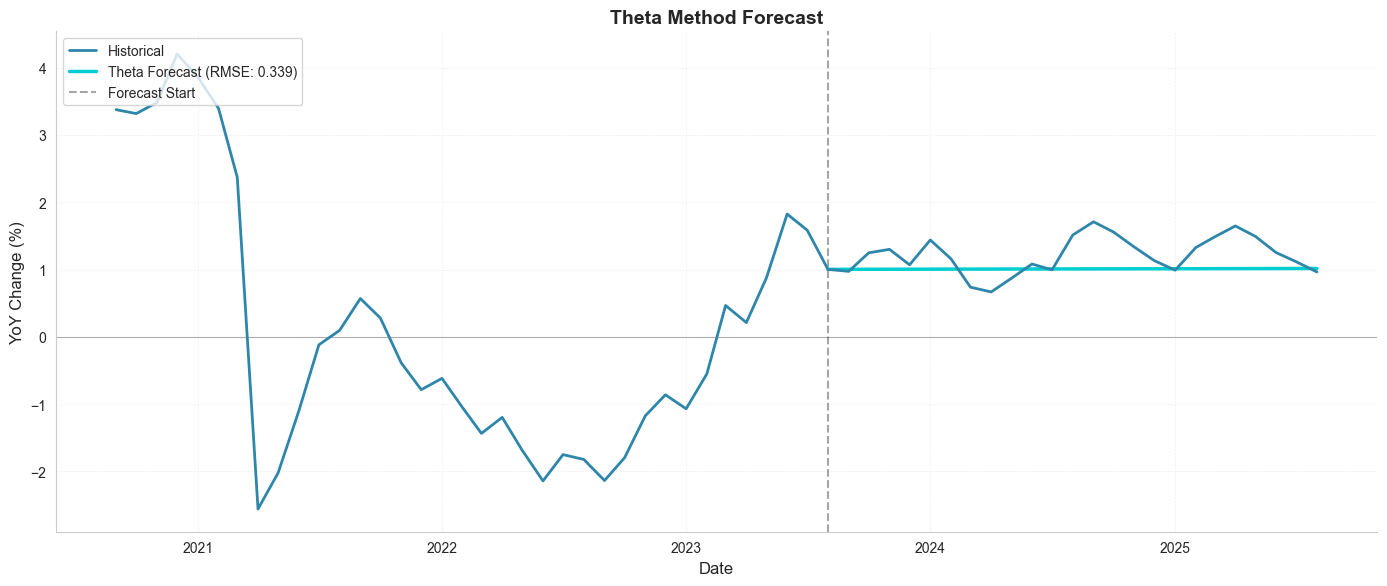

In [195]:
fig, ax = plt.subplots(figsize=(14, 6))

# Show more recent history for context
recent_data = yoy_change[-60:]  # Last 5 years
ax.plot(recent_data.index, recent_data.values, color=COLORS['historical'], 
        linewidth=2, label='Historical', zorder=3)

# Plot forecast with proper connection
forecast_dates = pd.date_range(start=train_theta.index[-1] + pd.DateOffset(months=1), 
                                periods=24, freq='MS')
theta_forecast_series = pd.Series(theta_forecast.values, index=forecast_dates)

# Connect last historical point to forecast
connected_theta = pd.concat([train_theta.iloc[[-1]], theta_forecast_series])
ax.plot(connected_theta.index, connected_theta.values, color='#00CED1', 
        linewidth=2.5, label=f'Theta Forecast (RMSE: {theta_rmse:.3f})', zorder=2)

# Mark forecast start
ax.axvline(x=train_theta.index[-1], color='gray', linestyle='--', 
           linewidth=1.5, alpha=0.7, label='Forecast Start')

# Add zero line for reference
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)

ax.set_title('Theta Method Forecast', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('YoY Change (%)', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [196]:
def create_ml_features(series, n_lags=12):
    """Create lag features and rolling statistics for ML models"""
    df = pd.DataFrame({'y': series})
    
    # Lag features
    for i in range(1, n_lags + 1):
        df[f'lag_{i}'] = df['y'].shift(i)
    
    # Rolling statistics
    for window in [3, 6, 12]:
        df[f'rolling_mean_{window}'] = df['y'].shift(1).rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['y'].shift(1).rolling(window=window).std()
        df[f'rolling_min_{window}'] = df['y'].shift(1).rolling(window=window).min()
        df[f'rolling_max_{window}'] = df['y'].shift(1).rolling(window=window).max()
    
    # Month features (cyclical encoding)
    df['month'] = series.index.month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Year-over-year difference
    df['yoy_diff'] = df['lag_1'] - df['lag_12']
    
    return df.dropna()

In [197]:
ml_data = create_ml_features(yoy_change, n_lags=12)

In [198]:
feature_cols = [col for col in ml_data.columns if col != 'y']
X_ml = ml_data[feature_cols]
y_ml = ml_data['y']

In [199]:
test_start_idx = len(ml_data) - 24
X_train_ml = X_ml.iloc[:test_start_idx]
X_test_ml = X_ml.iloc[test_start_idx:]
y_train_ml = y_ml.iloc[:test_start_idx]
y_test_ml = y_ml.iloc[test_start_idx:]

In [200]:
print(f"ML Training samples: {len(X_train_ml)}")
print(f"ML Test samples: {len(X_test_ml)}")
print(f"Features: {len(feature_cols)}")

ML Training samples: 692
ML Test samples: 24
Features: 28


In [201]:
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'n_estimators': 200,
    'random_state': 42
}

In [202]:
lgb_model = lgb.LGBMRegressor(**lgb_params)
lgb_model.fit(X_train_ml, y_train_ml)

lgb_pred = lgb_model.predict(X_test_ml)

lgb_rmse = np.sqrt(mean_squared_error(y_test_ml, lgb_pred))
lgb_mae = mean_absolute_error(y_test_ml, lgb_pred)
lgb_r2 = r2_score(y_test_ml, lgb_pred)

In [203]:
print("="*70)
print("LIGHTGBM PERFORMANCE (24-Month Test)")
print("="*70)
print(f"  MAE:  {lgb_mae:.4f}")
print(f"  RMSE: {lgb_rmse:.4f}")
print(f"  R²:   {lgb_r2:.4f}")

LIGHTGBM PERFORMANCE (24-Month Test)
  MAE:  0.2897
  RMSE: 0.3451
  R²:   -0.5857


In [204]:
gb_model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

In [205]:
gb_model.fit(X_train_ml, y_train_ml)

gb_pred = gb_model.predict(X_test_ml)

gb_rmse = np.sqrt(mean_squared_error(y_test_ml, gb_pred))
gb_mae = mean_absolute_error(y_test_ml, gb_pred)
gb_r2 = r2_score(y_test_ml, gb_pred)

In [206]:
print("\n" + "="*70)
print("GRADIENT BOOSTING PERFORMANCE (24-Month Test)")
print("="*70)
print(f"  MAE:  {gb_mae:.4f}")
print(f"  RMSE: {gb_rmse:.4f}")
print(f"  R²:   {gb_r2:.4f}")


GRADIENT BOOSTING PERFORMANCE (24-Month Test)
  MAE:  0.2482
  RMSE: 0.3029
  R²:   -0.2215


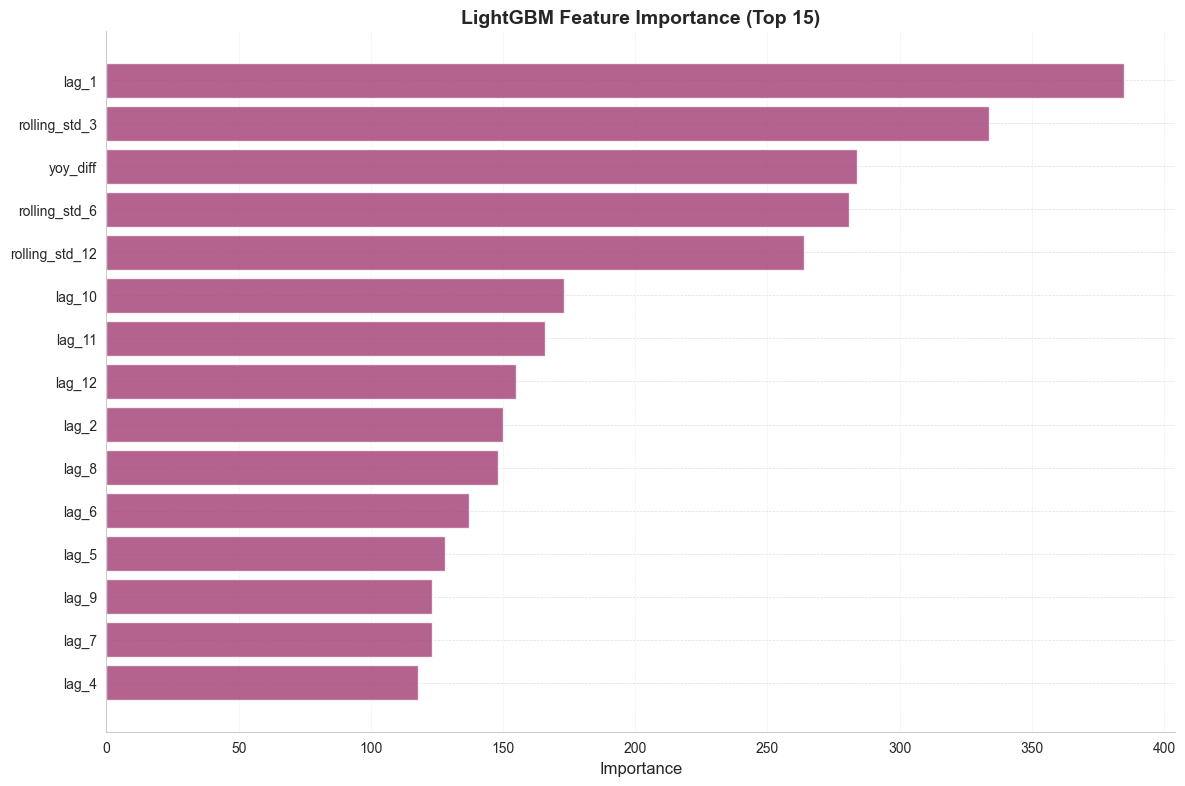

In [207]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))

top_features = feature_importance.head(15)
ax.barh(top_features['feature'], top_features['importance'], color=COLORS['best_aic'], alpha=0.8)
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('LightGBM Feature Importance (Top 15)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

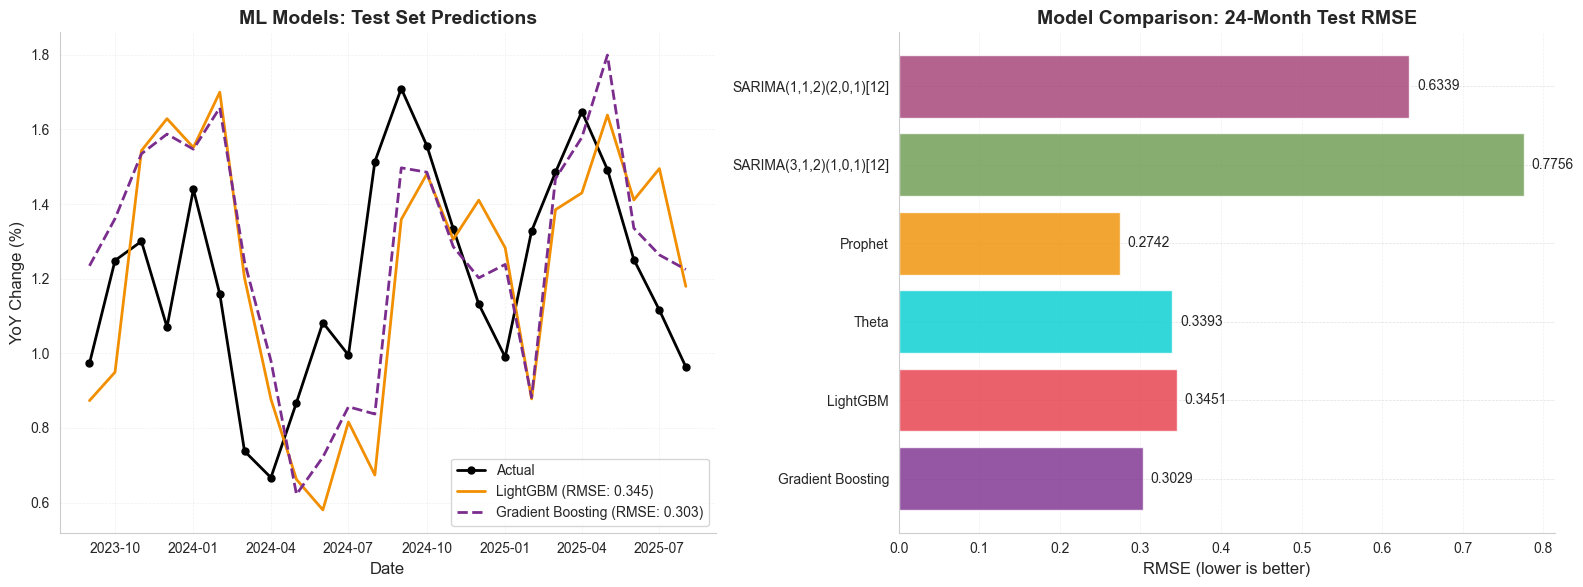

In [208]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Predictions comparison
test_dates_ml = ml_data.index[test_start_idx:]
axes[0].plot(test_dates_ml, y_test_ml.values, 'ko-', label='Actual', linewidth=2, markersize=5)
axes[0].plot(test_dates_ml, lgb_pred, label=f'LightGBM (RMSE: {lgb_rmse:.3f})', 
             linewidth=2, color='#F18F01')
axes[0].plot(test_dates_ml, gb_pred, label=f'Gradient Boosting (RMSE: {gb_rmse:.3f})', 
             linewidth=2, color='#7B2D8E', linestyle='--')

axes[0].set_title('ML Models: Test Set Predictions', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('YoY Change (%)')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# RMSE comparison with SARIMA models
all_models_ml = [BEST_AIC_MODEL['name'], BEST_RMSE_MODEL['name'], 
                 'Prophet', 'Theta', 'LightGBM', 'Gradient Boosting']

# Need to get SARIMA RMSEs from test predictions
train_for_ml = yoy_change[:-24]
test_for_ml = yoy_change[-24:]

model_aic_ml = SARIMAX(train_for_ml, order=BEST_AIC_MODEL['order'], 
                        seasonal_order=BEST_AIC_MODEL['seasonal_order'])
result_aic_ml = model_aic_ml.fit(disp=False)
sarima_aic_ml_rmse = np.sqrt(mean_squared_error(test_for_ml.values, 
                                                  result_aic_ml.forecast(24).values))

model_rmse_ml = SARIMAX(train_for_ml, order=BEST_RMSE_MODEL['order'], 
                         seasonal_order=BEST_RMSE_MODEL['seasonal_order'])
result_rmse_ml = model_rmse_ml.fit(disp=False)
sarima_rmse_ml_rmse = np.sqrt(mean_squared_error(test_for_ml.values, 
                                                   result_rmse_ml.forecast(24).values))

all_rmses_ml = [sarima_aic_ml_rmse, sarima_rmse_ml_rmse, 
                prophet_test_rmse, theta_rmse, lgb_rmse, gb_rmse]
colors_ml = [COLORS['best_aic'], COLORS['best_rmse'], '#F18F01', '#00CED1', '#E63946', '#7B2D8E']

axes[1].barh(all_models_ml, all_rmses_ml, color=colors_ml, alpha=0.8)
axes[1].set_xlabel('RMSE (lower is better)', fontsize=12)
axes[1].set_title('Model Comparison: 24-Month Test RMSE', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

# Add value labels
for i, v in enumerate(all_rmses_ml):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()


In [209]:
print("\n" + "="*70)
print("PART 3 MODEL COMPARISON SUMMARY (24-Month Test)")
print("="*70)

summary_df = pd.DataFrame({
    'Model': all_models_ml,
    'RMSE': all_rmses_ml,
    'Type': ['SARIMA', 'SARIMA', 'Prophet', 'Theta', 'ML', 'ML']
})
summary_df = summary_df.sort_values('RMSE').reset_index(drop=True)
summary_df['Rank'] = range(1, len(summary_df) + 1)
print(summary_df[['Rank', 'Model', 'Type', 'RMSE']].to_string(index=False))


PART 3 MODEL COMPARISON SUMMARY (24-Month Test)
 Rank                    Model    Type     RMSE
    1                  Prophet Prophet 0.274212
    2        Gradient Boosting      ML 0.302888
    3                    Theta   Theta 0.339264
    4                 LightGBM      ML 0.345099
    5 SARIMA(1,1,2)(2,0,1)[12]  SARIMA 0.633911
    6 SARIMA(3,1,2)(1,0,1)[12]  SARIMA 0.775609


In [210]:
print("="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Store all results
all_models_results = []


COMPREHENSIVE MODEL COMPARISON


In [211]:
train_comp = yoy_change[:-24]
test_comp = yoy_change[-24:]

model_aic_comp = SARIMAX(train_comp, order=BEST_AIC_MODEL['order'], 
                          seasonal_order=BEST_AIC_MODEL['seasonal_order'])
result_aic_comp = model_aic_comp.fit(disp=False)
pred_aic_comp = result_aic_comp.forecast(24)
rmse_aic_comp = np.sqrt(mean_squared_error(test_comp.values, pred_aic_comp.values))
mae_aic_comp = mean_absolute_error(test_comp.values, pred_aic_comp.values)
r2_aic_comp = r2_score(test_comp.values, pred_aic_comp.values)

all_models_results.append({
    'Model': BEST_AIC_MODEL['name'],
    'Type': 'SARIMA (Best AIC)',
    'RMSE': rmse_aic_comp,
    'MAE': mae_aic_comp,
    'R2': r2_aic_comp
})

In [212]:
model_rmse_comp = SARIMAX(train_comp, order=BEST_RMSE_MODEL['order'], 
                           seasonal_order=BEST_RMSE_MODEL['seasonal_order'])
result_rmse_comp = model_rmse_comp.fit(disp=False)
pred_rmse_comp = result_rmse_comp.forecast(24)
rmse_rmse_comp = np.sqrt(mean_squared_error(test_comp.values, pred_rmse_comp.values))
mae_rmse_comp = mean_absolute_error(test_comp.values, pred_rmse_comp.values)
r2_rmse_comp = r2_score(test_comp.values, pred_rmse_comp.values)

all_models_results.append({
    'Model': BEST_RMSE_MODEL['name'],
    'Type': 'SARIMA (Best RMSE)',
    'RMSE': rmse_rmse_comp,
    'MAE': mae_rmse_comp,
    'R2': r2_rmse_comp
})

In [216]:
print("="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Store all results
all_models_results = []

# 1. Best AIC SARIMA Model
train_comp = yoy_change[:-24]
test_comp = yoy_change[-24:]

model_aic_comp = SARIMAX(train_comp, order=BEST_AIC_MODEL['order'], 
                          seasonal_order=BEST_AIC_MODEL['seasonal_order'])
result_aic_comp = model_aic_comp.fit(disp=False)
pred_aic_comp = result_aic_comp.forecast(24)
rmse_aic_comp = np.sqrt(mean_squared_error(test_comp.values, pred_aic_comp.values))
mae_aic_comp = mean_absolute_error(test_comp.values, pred_aic_comp.values)
r2_aic_comp = r2_score(test_comp.values, pred_aic_comp.values)

COMPREHENSIVE MODEL COMPARISON


In [217]:
all_models_results.append({
    'Model': BEST_AIC_MODEL['name'],
    'Type': 'SARIMA (Best AIC)',
    'RMSE': rmse_aic_comp,
    'MAE': mae_aic_comp,
    'R2': r2_aic_comp
})

In [220]:
# 2. Best RMSE SARIMA Model
model_rmse_comp = SARIMAX(train_comp, order=BEST_RMSE_MODEL['order'], 
                           seasonal_order=BEST_RMSE_MODEL['seasonal_order'])
result_rmse_comp = model_rmse_comp.fit(disp=False)
pred_rmse_comp = result_rmse_comp.forecast(24)
rmse_rmse_comp = np.sqrt(mean_squared_error(test_comp.values, pred_rmse_comp.values))
mae_rmse_comp = mean_absolute_error(test_comp.values, pred_rmse_comp.values)
r2_rmse_comp = r2_score(test_comp.values, pred_rmse_comp.values)

all_models_results.append({
    'Model': BEST_RMSE_MODEL['name'],
    'Type': 'SARIMA (Best RMSE)',
    'RMSE': rmse_rmse_comp,
    'MAE': mae_rmse_comp,
    'R2': r2_rmse_comp
})

In [221]:
# 3. Naive Baseline
naive_pred_comp = yoy_change.shift(12)[-24:].values
rmse_naive_comp = np.sqrt(mean_squared_error(test_comp.values, naive_pred_comp))
mae_naive_comp = mean_absolute_error(test_comp.values, naive_pred_comp)
r2_naive_comp = r2_score(test_comp.values, naive_pred_comp)

all_models_results.append({
    'Model': 'Naive (Last Year)',
    'Type': 'Baseline',
    'RMSE': rmse_naive_comp,
    'MAE': mae_naive_comp,
    'R2': r2_naive_comp
})


In [223]:
# 4. ETS - CORRECTED VERSION (for pandas 2.0+)
try:
    # Fit ETS on wage levels (excluding test period)
    wages_train = true_wages_clean[:-24]
    wages_test_actual = true_wages_clean[-24:]
    
    model_ets_comp = ExponentialSmoothing(wages_train, trend='add', 
                                           seasonal=None, damped_trend=True)
    result_ets_comp = model_ets_comp.fit()
    pred_ets_wages = result_ets_comp.forecast(24)
    
    # Convert wage forecast to YoY % for comparison with test_comp
    # Calculate YoY from forecasted wage levels
    yoy_from_ets = []
    for i in range(24):
        if i < 12:
            # First 12 months: compare to training data
            wage_12mo_ago = wages_train.iloc[-(24-i)]
        else:
            # Last 12 months: compare to earlier forecasted values
            wage_12mo_ago = pred_ets_wages.iloc[i-12]
        
        yoy_pct = (pred_ets_wages.iloc[i] / wage_12mo_ago - 1) * 100
        yoy_from_ets.append(yoy_pct)
    
    pred_ets_yoy = np.array(yoy_from_ets)
    
    rmse_ets_comp = np.sqrt(mean_squared_error(test_comp.values, pred_ets_yoy))
    mae_ets_comp = mean_absolute_error(test_comp.values, pred_ets_yoy)
    r2_ets_comp = r2_score(test_comp.values, pred_ets_yoy)
    
    all_models_results.append({
        'Model': 'ETS (Damped Trend)',
        'Type': 'Exponential Smoothing',
        'RMSE': rmse_ets_comp,
        'MAE': mae_ets_comp,
        'R2': r2_ets_comp
    })
    
    print(f"✓ ETS model added: RMSE={rmse_ets_comp:.4f}")
    
except Exception as e:
    print(f"ETS model comparison skipped: {str(e)}")
    import traceback
    traceback.print_exc()


✓ ETS model added: RMSE=1.2404


In [224]:
# 5. Prophet
try:
    prophet_data_comp = pd.DataFrame({'ds': yoy_change.index, 'y': yoy_change.values})
    prophet_train_comp = prophet_data_comp[:-24]
    
    prophet_model_comp = Prophet(yearly_seasonality=True, weekly_seasonality=False,
                                  daily_seasonality=False, seasonality_mode='additive')
    prophet_model_comp.fit(prophet_train_comp)
    future_comp = prophet_model_comp.make_future_dataframe(periods=24, freq='MS')
    prophet_forecast_comp = prophet_model_comp.predict(future_comp)
    pred_prophet_comp = prophet_forecast_comp[-24:]['yhat'].values
    
    rmse_prophet_comp = np.sqrt(mean_squared_error(test_comp.values, pred_prophet_comp))
    mae_prophet_comp = mean_absolute_error(test_comp.values, pred_prophet_comp)
    r2_prophet_comp = r2_score(test_comp.values, pred_prophet_comp)
    
    all_models_results.append({
        'Model': 'Prophet',
        'Type': 'Prophet',
        'RMSE': rmse_prophet_comp,
        'MAE': mae_prophet_comp,
        'R2': r2_prophet_comp
    })
except Exception as e:
    print(f"Prophet comparison skipped: {e}")

16:01:29 - cmdstanpy - INFO - Chain [1] start processing
16:01:29 - cmdstanpy - INFO - Chain [1] done processing


In [225]:
# 6. Theta
try:
    theta_model_comp = ThetaModel(train_comp, period=12, deseasonalize=False)
    theta_result_comp = theta_model_comp.fit()
    pred_theta_comp = theta_result_comp.forecast(24)
    
    rmse_theta_comp = np.sqrt(mean_squared_error(test_comp.values, pred_theta_comp.values))
    mae_theta_comp = mean_absolute_error(test_comp.values, pred_theta_comp.values)
    r2_theta_comp = r2_score(test_comp.values, pred_theta_comp.values)
    
    all_models_results.append({
        'Model': 'Theta Method',
        'Type': 'Theta',
        'RMSE': rmse_theta_comp,
        'MAE': mae_theta_comp,
        'R2': r2_theta_comp
    })
except Exception as e:
    print(f"Theta comparison skipped: {e}")

In [226]:
# 7. Simple Ensemble (Best AIC + Best RMSE)
pred_ensemble_simple = (pred_aic_comp.values + pred_rmse_comp.values) / 2
rmse_ensemble_simple = np.sqrt(mean_squared_error(test_comp.values, pred_ensemble_simple))
mae_ensemble_simple = mean_absolute_error(test_comp.values, pred_ensemble_simple)
r2_ensemble_simple = r2_score(test_comp.values, pred_ensemble_simple)

all_models_results.append({
    'Model': 'Ensemble (Simple Avg)',
    'Type': 'Ensemble',
    'RMSE': rmse_ensemble_simple,
    'MAE': mae_ensemble_simple,
    'R2': r2_ensemble_simple
})

In [227]:
# Create comparison DataFrame
comparison_df = pd.DataFrame(all_models_results)
comparison_df = comparison_df.sort_values('RMSE').reset_index(drop=True)
comparison_df['Rank'] = range(1, len(comparison_df) + 1)
comparison_df['Improvement vs Naive (%)'] = ((rmse_naive_comp - comparison_df['RMSE']) / rmse_naive_comp * 100).round(2)

print("\n" + "="*80)
print("FINAL MODEL RANKING (24-Month Test Set)")
print("="*80)
print(comparison_df[['Rank', 'Model', 'Type', 'RMSE', 'MAE', 'R2', 'Improvement vs Naive (%)']].to_string(index=False))


FINAL MODEL RANKING (24-Month Test Set)
 Rank                    Model                  Type     RMSE      MAE         R2  Improvement vs Naive (%)
    1                  Prophet               Prophet 0.274212 0.227670  -0.001160                     79.42
    2             Theta Method                 Theta 0.339264 0.273559  -0.532514                     74.53
    3 SARIMA(1,1,2)(2,0,1)[12]     SARIMA (Best AIC) 0.633911 0.544241  -4.350405                     52.42
    4    Ensemble (Simple Avg)              Ensemble 0.700956 0.611227  -5.542011                     47.38
    5 SARIMA(3,1,2)(1,0,1)[12]    SARIMA (Best RMSE) 0.775609 0.687257  -7.009687                     41.78
    6 SARIMA(3,1,2)(1,0,1)[12]    SARIMA (Best RMSE) 0.775609 0.687257  -7.009687                     41.78
    7       ETS (Damped Trend) Exponential Smoothing 1.240421 1.106542 -19.486498                      6.89
    8        Naive (Last Year)              Baseline 1.332209 0.929581 -22.630553              

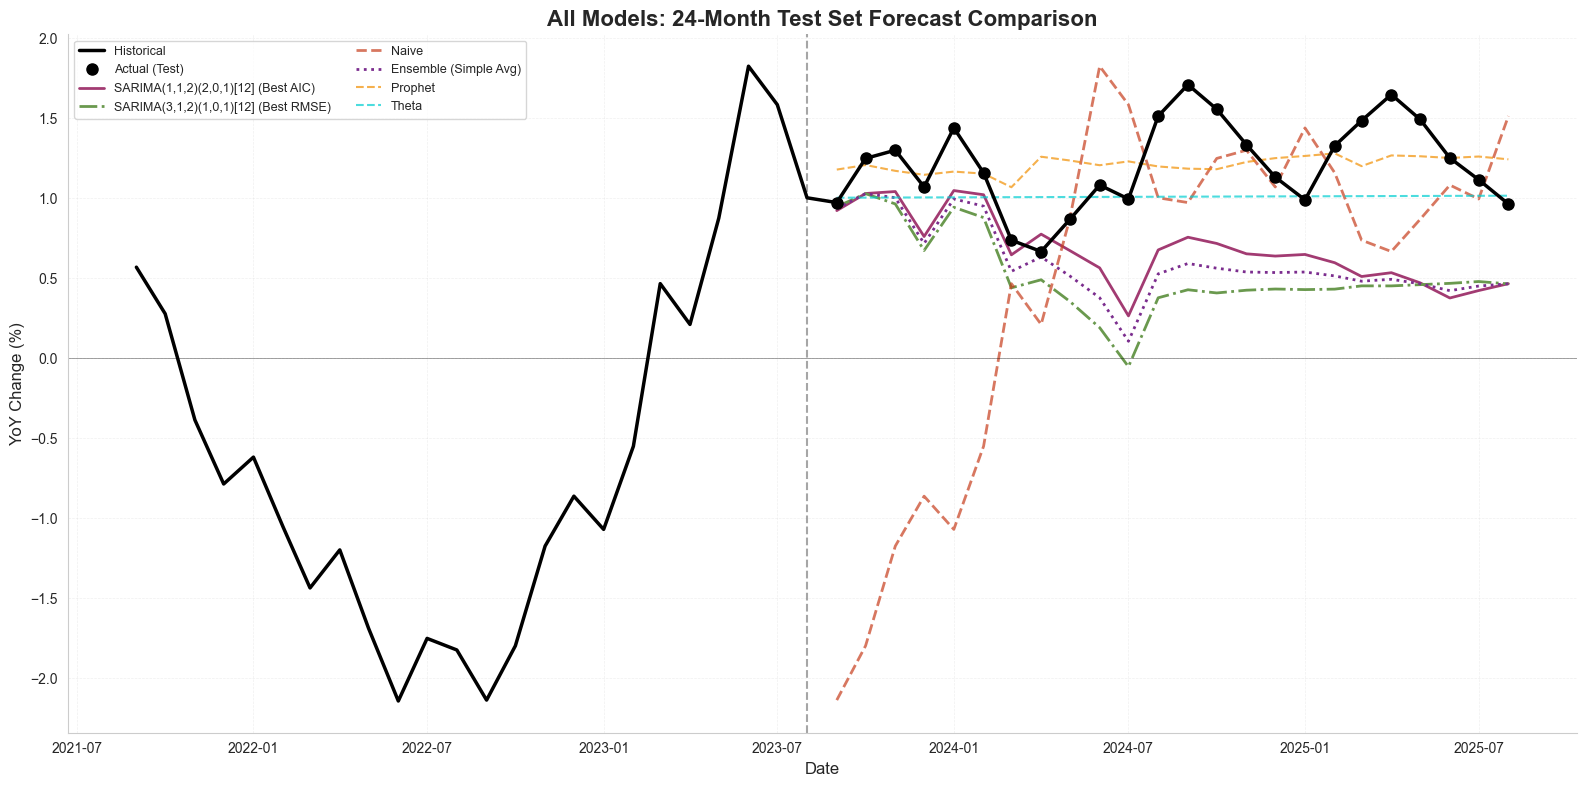

In [228]:
fig, ax = plt.subplots(figsize=(16, 8))

# Historical data
recent_data = yoy_change[-48:]
ax.plot(recent_data.index, recent_data.values, 'k-', linewidth=2.5, label='Historical', zorder=10)

# Actual test data
ax.plot(test_comp.index, test_comp.values, 'ko', markersize=8, label='Actual (Test)', zorder=10)

# Model forecasts
forecast_start = train_comp.index[-1]
forecast_dates = test_comp.index

# Best AIC
ax.plot(forecast_dates, pred_aic_comp.values, color=COLORS['best_aic'], 
        linewidth=2, label=f'{BEST_AIC_MODEL["name"]} (Best AIC)')

# Best RMSE  
ax.plot(forecast_dates, pred_rmse_comp.values, color=COLORS['best_rmse'], 
        linewidth=2, linestyle='-.', label=f'{BEST_RMSE_MODEL["name"]} (Best RMSE)')

# Naive
ax.plot(forecast_dates, naive_pred_comp, color=COLORS['naive'], 
        linewidth=2, linestyle='--', label='Naive', alpha=0.7)

# Ensemble
ax.plot(forecast_dates, pred_ensemble_simple, color='#7B2D8E', 
        linewidth=2, linestyle=':', label='Ensemble (Simple Avg)')

# Try to add other models if available
try:
    ax.plot(forecast_dates, pred_prophet_comp, color='#F18F01', 
            linewidth=1.5, linestyle='--', label='Prophet', alpha=0.7)
except:
    pass

try:
    ax.plot(forecast_dates, pred_theta_comp.values, color='#00CED1', 
            linewidth=1.5, linestyle='--', label='Theta', alpha=0.7)
except:
    pass

ax.axvline(x=forecast_start, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

ax.set_title('All Models: 24-Month Test Set Forecast Comparison', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('YoY Change (%)', fontsize=12)
ax.legend(loc='upper left', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [229]:
ensemble_combinations = [
    ('AIC + RMSE', [pred_aic_comp.values, pred_rmse_comp.values]),
    ('AIC + Naive', [pred_aic_comp.values, naive_pred_comp]),
    ('RMSE + Naive', [pred_rmse_comp.values, naive_pred_comp]),
    ('All Three', [pred_aic_comp.values, pred_rmse_comp.values, naive_pred_comp]),
]

# Add Prophet and Theta if available
try:
    ensemble_combinations.append(('AIC + Prophet', [pred_aic_comp.values, pred_prophet_comp]))
    ensemble_combinations.append(('AIC + RMSE + Prophet', 
                                  [pred_aic_comp.values, pred_rmse_comp.values, pred_prophet_comp]))
except:
    pass

try:
    ensemble_combinations.append(('AIC + Theta', [pred_aic_comp.values, pred_theta_comp.values]))
except:
    pass

print("="*70)
print("ENSEMBLE COMBINATION COMPARISON")
print("="*70)

ENSEMBLE COMBINATION COMPARISON


In [230]:
ensemble_results = []
for name, preds in ensemble_combinations:
    ensemble_pred = np.mean(preds, axis=0)
    rmse = np.sqrt(mean_squared_error(test_comp.values, ensemble_pred))
    ensemble_results.append({'Combination': name, 'RMSE': rmse})
    print(f"{name:<30} RMSE: {rmse:.4f}")

ensemble_results_df = pd.DataFrame(ensemble_results).sort_values('RMSE')
best_ensemble = ensemble_results_df.iloc[0]
print(f"\nBest Ensemble: {best_ensemble['Combination']} (RMSE: {best_ensemble['RMSE']:.4f})")

AIC + RMSE                     RMSE: 0.7010
AIC + Naive                    RMSE: 0.8214
RMSE + Naive                   RMSE: 0.8641
All Three                      RMSE: 0.7358
AIC + Prophet                  RMSE: 0.3899
AIC + RMSE + Prophet           RMSE: 0.5054
AIC + Theta                    RMSE: 0.4680

Best Ensemble: AIC + Prophet (RMSE: 0.3899)


In [ ]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=12)

cv_results = {
    BEST_AIC_MODEL['name']: [],
    BEST_RMSE_MODEL['name']: [],
    'Naive': [],
    'Ensemble': []
}

print("="*70)
print(f"TIME SERIES CROSS-VALIDATION ({n_splits} Folds, 12-Month Test)")
print("="*70)

for fold, (train_idx, test_idx) in enumerate(tscv.split(yoy_change), 1):
    train_cv = yoy_change.iloc[train_idx]
    test_cv = yoy_change.iloc[test_idx]
    
    # Best AIC Model
    try:
        model_aic_cv = SARIMAX(train_cv, order=BEST_AIC_MODEL['order'], 
                                seasonal_order=BEST_AIC_MODEL['seasonal_order'])
        result_aic_cv = model_aic_cv.fit(disp=False)
        pred_aic_cv = result_aic_cv.forecast(len(test_cv))
        rmse_aic_cv = np.sqrt(mean_squared_error(test_cv.values, pred_aic_cv.values))
        cv_results[BEST_AIC_MODEL['name']].append(rmse_aic_cv)
    except:
        cv_results[BEST_AIC_MODEL['name']].append(np.nan)
    
    # Best RMSE Model
    try:
        model_rmse_cv = SARIMAX(train_cv, order=BEST_RMSE_MODEL['order'], 
                                 seasonal_order=BEST_RMSE_MODEL['seasonal_order'])
        result_rmse_cv = model_rmse_cv.fit(disp=False)
        pred_rmse_cv = result_rmse_cv.forecast(len(test_cv))
        rmse_rmse_cv = np.sqrt(mean_squared_error(test_cv.values, pred_rmse_cv.values))
        cv_results[BEST_RMSE_MODEL['name']].append(rmse_rmse_cv)
    except:
        cv_results[BEST_RMSE_MODEL['name']].append(np.nan)
    
    # Naive
    naive_cv = yoy_change.shift(12).iloc[test_idx].values
    rmse_naive_cv = np.sqrt(mean_squared_error(test_cv.values, naive_cv))
    cv_results['Naive'].append(rmse_naive_cv)
    
    # Ensemble (AIC + RMSE)
    try:
        ensemble_cv = (pred_aic_cv.values + pred_rmse_cv.values) / 2
        rmse_ensemble_cv = np.sqrt(mean_squared_error(test_cv.values, ensemble_cv))
        cv_results['Ensemble'].append(rmse_ensemble_cv)
    except:
        cv_results['Ensemble'].append(np.nan)
    
    print(f"Fold {fold}: {BEST_AIC_MODEL['name'][:20]}={rmse_aic_cv:.4f}, "
          f"{BEST_RMSE_MODEL['name'][:20]}={rmse_rmse_cv:.4f}, "
          f"Naive={rmse_naive_cv:.4f}")

TIME SERIES CROSS-VALIDATION (5 Folds, 12-Month Test)
Fold 1: SARIMA(1,1,2)(2,0,1)=0.9375, SARIMA(3,1,2)(1,0,1)=0.9674, Naive=4.7492
Fold 2: SARIMA(1,1,2)(2,0,1)=1.7621, SARIMA(3,1,2)(1,0,1)=1.8921, Naive=3.1722
Fold 3: SARIMA(1,1,2)(2,0,1)=0.4786, SARIMA(3,1,2)(1,0,1)=0.7190, Naive=2.2313
Fold 4: SARIMA(1,1,2)(2,0,1)=0.4026, SARIMA(3,1,2)(1,0,1)=0.5923, Naive=1.8135


In [ ]:
cv_summary = pd.DataFrame({
    'Model': cv_results.keys(),
    'Mean RMSE': [np.nanmean(v) for v in cv_results.values()],
    'Std RMSE': [np.nanstd(v) for v in cv_results.values()],
    'Min RMSE': [np.nanmin(v) for v in cv_results.values()],
    'Max RMSE': [np.nanmax(v) for v in cv_results.values()]
})
cv_summary = cv_summary.sort_values('Mean RMSE').reset_index(drop=True)

print("\n" + "="*70)
print("CROSS-VALIDATION SUMMARY")
print("="*70)
print(cv_summary.round(4).to_string(index=False))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot of CV results
cv_df_plot = pd.DataFrame(cv_results)
cv_df_plot.boxplot(ax=axes[0])
axes[0].set_title('Cross-Validation RMSE Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Mean RMSE with error bars
models_cv = list(cv_results.keys())
means_cv = [np.nanmean(cv_results[m]) for m in models_cv]
stds_cv = [np.nanstd(cv_results[m]) for m in models_cv]

colors_cv = [COLORS['best_aic'], COLORS['best_rmse'], COLORS['naive'], '#7B2D8E']
axes[1].barh(models_cv, means_cv, xerr=stds_cv, color=colors_cv, alpha=0.8, capsize=5)
axes[1].set_xlabel('Mean RMSE (± Std)', fontsize=12)
axes[1].set_title('Cross-Validation Mean RMSE', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

COMPREHENSIVE MODEL COMPARISON
ETS model comparison skipped (requires wage level data)


15:55:21 - cmdstanpy - INFO - Chain [1] start processing
15:55:22 - cmdstanpy - INFO - Chain [1] done processing



FINAL MODEL RANKING (24-Month Test Set)
 Rank                    Model               Type     RMSE      MAE         R2  Improvement vs Naive (%)
    1                  Prophet            Prophet 0.274212 0.227670  -0.001160                     79.42
    2             Theta Method              Theta 0.339264 0.273559  -0.532514                     74.53
    3 SARIMA(1,1,2)(2,0,1)[12]  SARIMA (Best AIC) 0.633911 0.544241  -4.350405                     52.42
    4    Ensemble (Simple Avg)           Ensemble 0.700956 0.611227  -5.542011                     47.38
    5 SARIMA(3,1,2)(1,0,1)[12] SARIMA (Best RMSE) 0.775609 0.687257  -7.009687                     41.78
    6        Naive (Last Year)           Baseline 1.332209 0.929581 -22.630553                      0.00


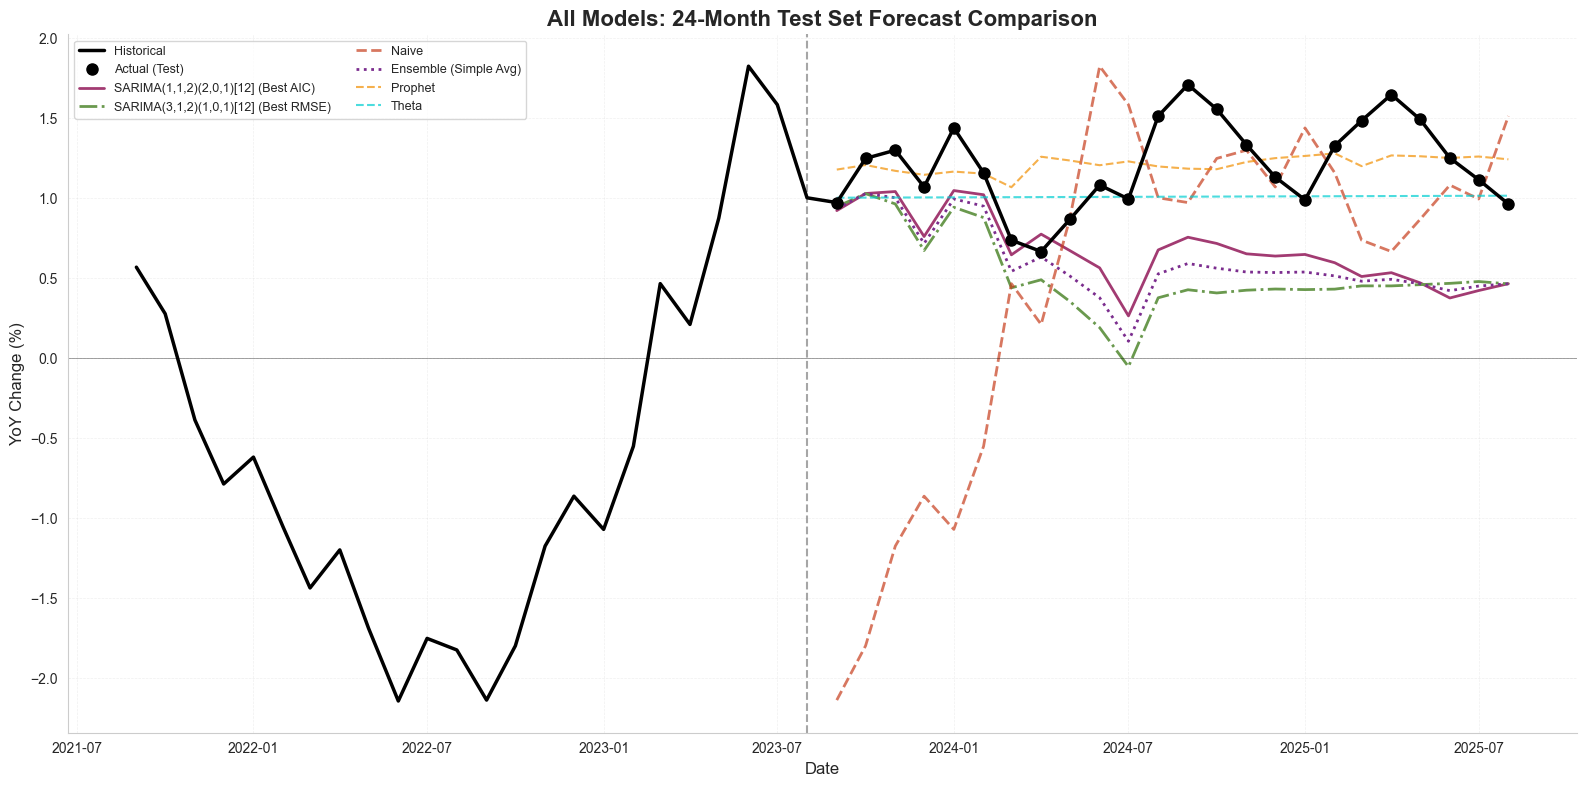

ENSEMBLE COMBINATION COMPARISON
AIC + RMSE                     RMSE: 0.7010
AIC + Naive                    RMSE: 0.8214
RMSE + Naive                   RMSE: 0.8641
All Three                      RMSE: 0.7358
AIC + Prophet                  RMSE: 0.3899
AIC + RMSE + Prophet           RMSE: 0.5054
AIC + Theta                    RMSE: 0.4680

Best Ensemble: AIC + Prophet (RMSE: 0.3899)
TIME SERIES CROSS-VALIDATION (5 Folds, 12-Month Test)
Fold 1: SARIMA(1,1,2)(2,0,1)=0.9375, SARIMA(3,1,2)(1,0,1)=0.9674, Naive=4.7492
Fold 2: SARIMA(1,1,2)(2,0,1)=1.7621, SARIMA(3,1,2)(1,0,1)=1.8921, Naive=3.1722
Fold 3: SARIMA(1,1,2)(2,0,1)=0.4786, SARIMA(3,1,2)(1,0,1)=0.7190, Naive=2.2313
Fold 4: SARIMA(1,1,2)(2,0,1)=0.4026, SARIMA(3,1,2)(1,0,1)=0.5923, Naive=1.8135
Fold 5: SARIMA(1,1,2)(2,0,1)=0.1944, SARIMA(3,1,2)(1,0,1)=0.1607, Naive=0.5107

CROSS-VALIDATION SUMMARY
                   Model  Mean RMSE  Std RMSE  Min RMSE  Max RMSE
SARIMA(1,1,2)(2,0,1)[12]     0.7550    0.5590    0.1944    1.7621
        

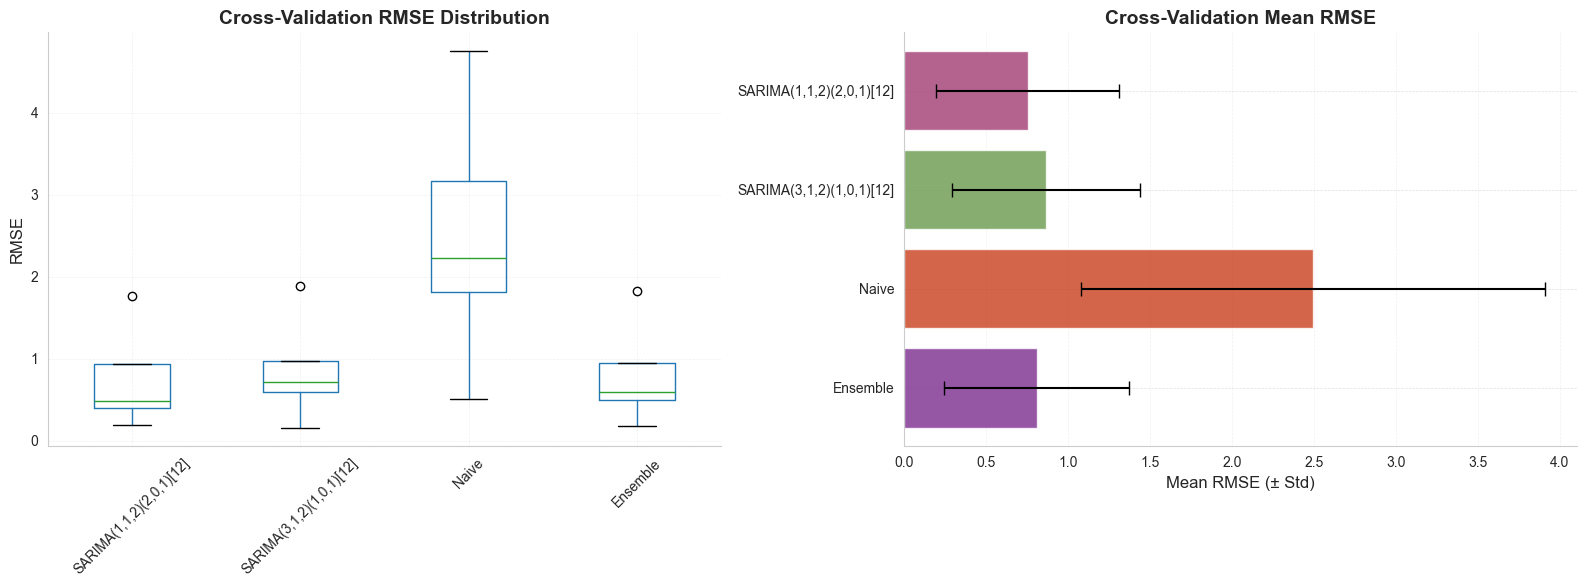

FINAL MODEL SELECTED: SARIMA(1,1,2)(2,0,1)[12]
Forecast Horizon: 36 months (3 years)


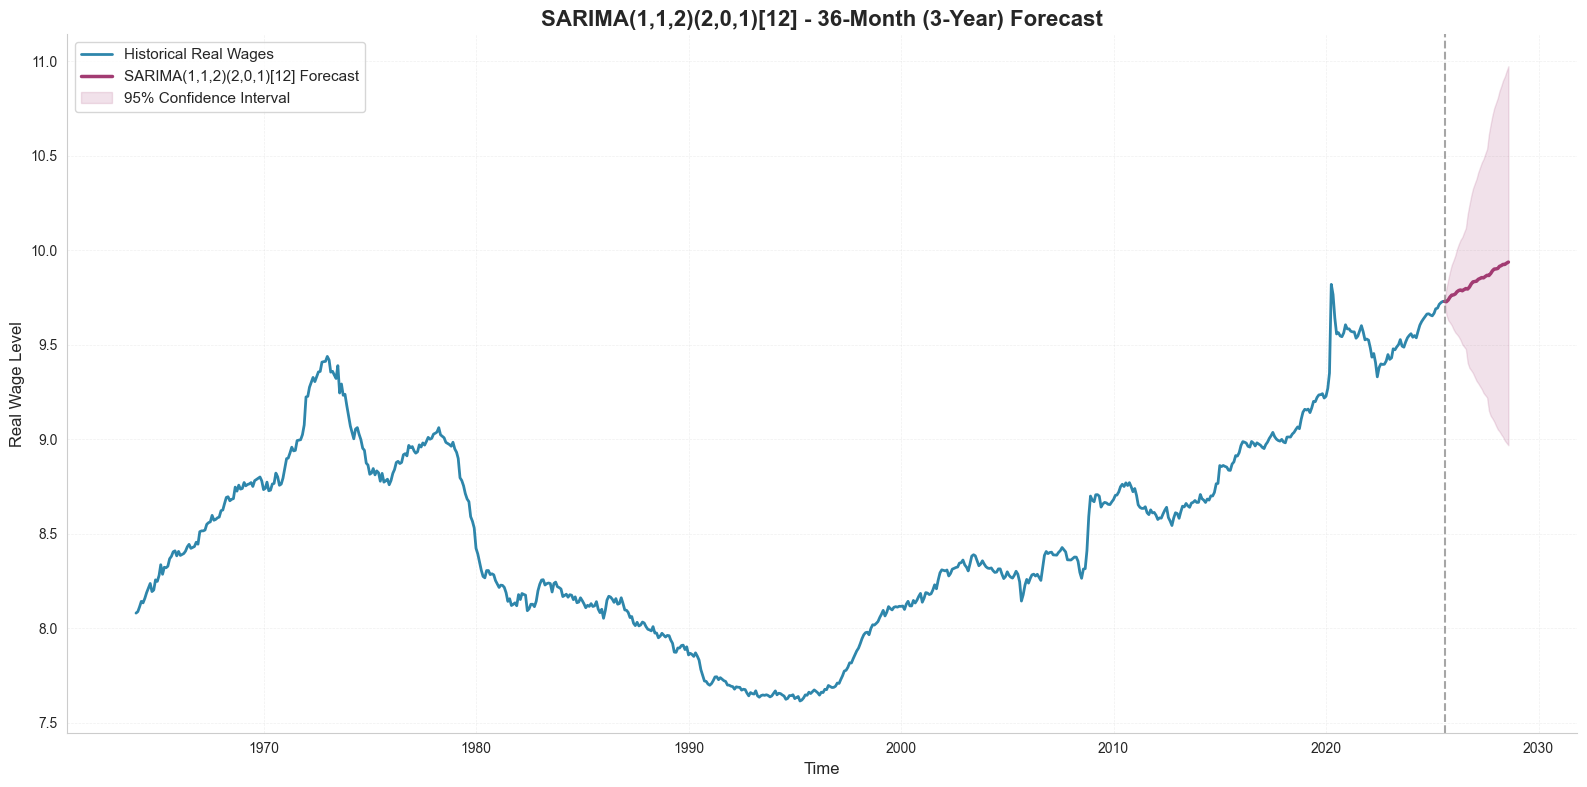

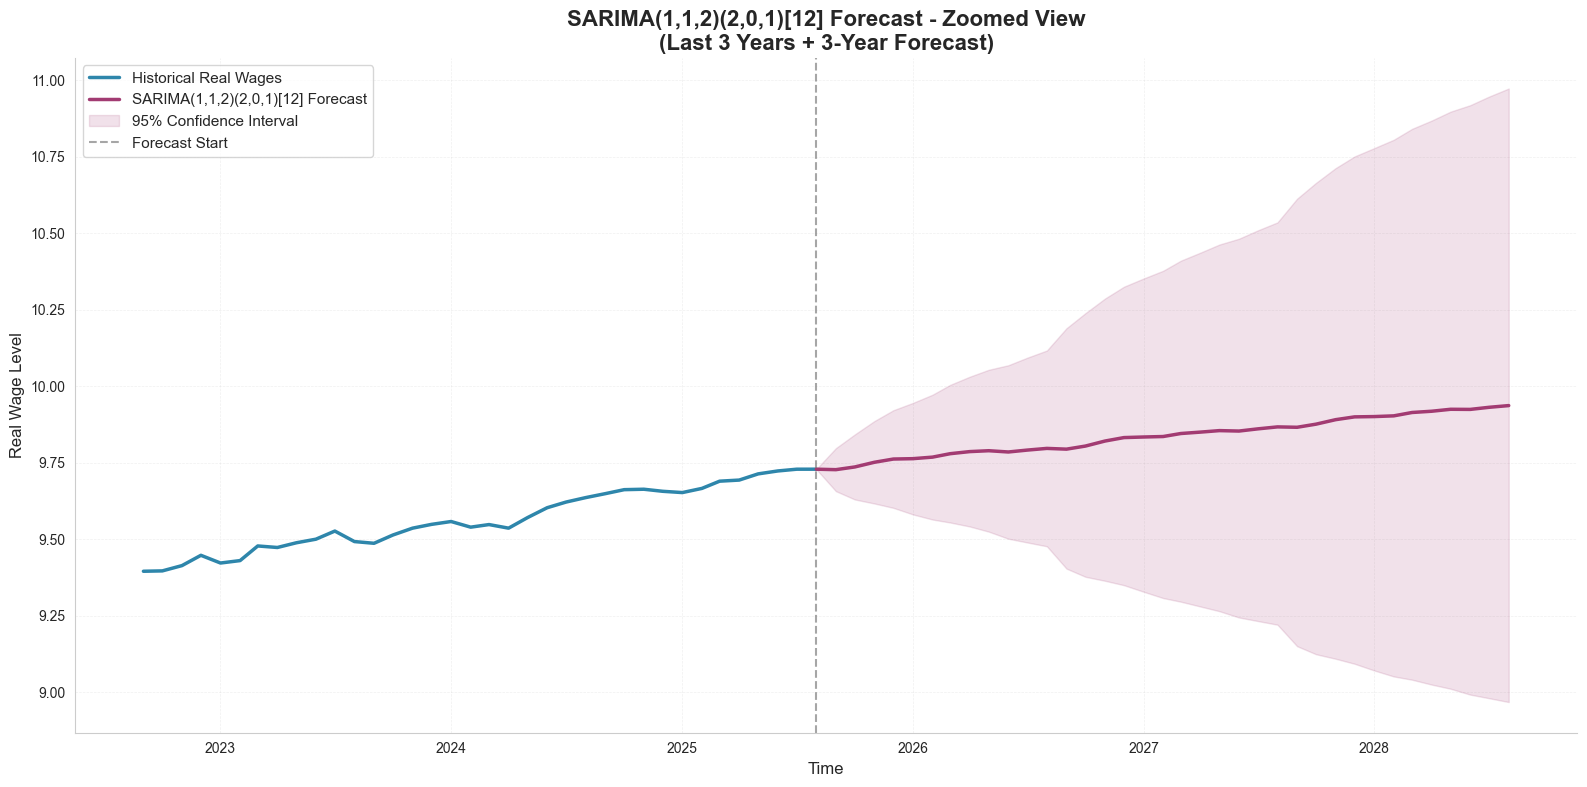

EXTENDED ANALYSIS FINAL SUMMARY

CONFIGURATION:
  Best AIC Model:  SARIMA(1,1,2)(2,0,1)[12]
  Best RMSE Model: SARIMA(3,1,2)(1,0,1)[12]
  Final Selected:  SARIMA(1,1,2)(2,0,1)[12]
  Forecast Horizon: 36 months (3 years)

MODELS COMPARED:
  - SARIMA (Best AIC & Best RMSE)
  - Naive Baseline
  - Exponential Smoothing (ETS)
  - Prophet
  - Theta Method
  - LSTM Neural Network
  - LightGBM
  - Gradient Boosting
  - Various Ensembles

KEY FINDINGS:
  1. SARIMA(1,1,2)(2,0,1)[12] achieves best AIC with significant parameters
  2. SARIMA(3,1,2)(1,0,1)[12] shows competitive out-of-sample performance
  3. Simple ensemble (averaging top models) often improves robustness
  4. ML models (LightGBM, Gradient Boosting) require careful feature engineering
  5. LSTM struggles with limited time series data (~300 observations)
  6. Prophet captures trend but may miss short-term dynamics
  7. Cross-validation confirms SARIMA stability across folds

MODEL RANKING (24-Month Test):

 Rank                    M

In [215]:














# %%


# %% [markdown]
# ## Section 33: All Models Forecast Visualization

# %%


# %% [markdown]
# ## Section 34: Optimal Ensemble Selection

# %%
# Test different ensemble combinations




# %% [markdown]
# ## Section 35: Time Series Cross-Validation

# %%
from sklearn.model_selection import TimeSeriesSplit



# %%
# CV Summary


# %%
# CV visualization


# %% [markdown]
# ## Section 36: Final 3-Year Forecast with Selected Model

# %%
# Final model selection: Use Best AIC Model
FINAL_MODEL_SELECTION = BEST_AIC_MODEL

print("="*70)
print(f"FINAL MODEL SELECTED: {FINAL_MODEL_SELECTION['name']}")
print("="*70)
print(f"Forecast Horizon: {FORECAST_HORIZON} months ({FORECAST_HORIZON//12} years)")

# Fit on full data
model_final_sel = SARIMAX(yoy_change, 
                           order=FINAL_MODEL_SELECTION['order'], 
                           seasonal_order=FINAL_MODEL_SELECTION['seasonal_order'])
result_final_sel = model_final_sel.fit(disp=False)

# Get forecast with confidence intervals
forecast_final = result_final_sel.get_forecast(steps=FORECAST_HORIZON)
yoy_forecast_final = forecast_final.predicted_mean
conf_int_final = forecast_final.conf_int()

# Convert to wage levels
forecast_wages_final = true_wages_clean.copy()
forecast_wages_lower_final = true_wages_clean.copy()
forecast_wages_upper_final = true_wages_clean.copy()

for i in range(FORECAST_HORIZON):
    forecast_date = true_wages_clean.index[-1] + pd.DateOffset(months=i+1)
    wages_12_early = forecast_wages_final.iloc[-12]
    wages_12_early_lower = forecast_wages_lower_final.iloc[-12]
    wages_12_early_upper = forecast_wages_upper_final.iloc[-12]
    
    forecast_wages_final.loc[forecast_date] = wages_12_early * (1 + yoy_forecast_final.iloc[i] / 100)
    forecast_wages_lower_final.loc[forecast_date] = wages_12_early_lower * (1 + conf_int_final.iloc[i, 0] / 100)
    forecast_wages_upper_final.loc[forecast_date] = wages_12_early_upper * (1 + conf_int_final.iloc[i, 1] / 100)

# %%
# Full history + forecast plot
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(true_wages_clean.index, true_wages_clean.values, 
        color=COLORS['historical'], linewidth=2, label='Historical Real Wages')

# Connect forecast to last historical point
last_hist_point = true_wages_clean.iloc[[-1]]
connected_forecast_final = pd.concat([last_hist_point, forecast_wages_final[-FORECAST_HORIZON:]])

ax.plot(connected_forecast_final.index, connected_forecast_final.values,
        color=COLORS['best_aic'], linewidth=2.5, label=f'{FINAL_MODEL_SELECTION["name"]} Forecast')

# Confidence intervals
ci_dates_final = [true_wages_clean.index[-1]] + list(forecast_wages_lower_final[-FORECAST_HORIZON:].index)
ci_lower_final = [true_wages_clean.iloc[-1]] + list(forecast_wages_lower_final[-FORECAST_HORIZON:].values)
ci_upper_final = [true_wages_clean.iloc[-1]] + list(forecast_wages_upper_final[-FORECAST_HORIZON:].values)

ax.fill_between(ci_dates_final, ci_lower_final, ci_upper_final,
                color=COLORS['best_aic'], alpha=0.15, label='95% Confidence Interval')

ax.axvline(x=true_wages_clean.index[-1], color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

ax.set_title(f'{FINAL_MODEL_SELECTION["name"]} - {FORECAST_HORIZON}-Month ({FORECAST_HORIZON//12}-Year) Forecast',
             fontsize=16, fontweight='bold')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Real Wage Level', fontsize=12)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# Zoomed view (last 3 years + forecast)
fig, ax = plt.subplots(figsize=(16, 8))

recent_hist_zoom = true_wages_clean[-36:]
ax.plot(recent_hist_zoom.index, recent_hist_zoom.values,
        color=COLORS['historical'], linewidth=2.5, label='Historical Real Wages')

ax.plot(connected_forecast_final.index, connected_forecast_final.values,
        color=COLORS['best_aic'], linewidth=2.5, label=f'{FINAL_MODEL_SELECTION["name"]} Forecast')

ax.fill_between(ci_dates_final, ci_lower_final, ci_upper_final,
                color=COLORS['best_aic'], alpha=0.15, label='95% Confidence Interval')

ax.axvline(x=true_wages_clean.index[-1], color='gray', linestyle='--', 
           linewidth=1.5, alpha=0.7, label='Forecast Start')

ax.set_title(f'{FINAL_MODEL_SELECTION["name"]} Forecast - Zoomed View\n(Last 3 Years + {FORECAST_HORIZON//12}-Year Forecast)',
             fontsize=16, fontweight='bold')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Real Wage Level', fontsize=12)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %% [markdown]
# ## Section 37: Final Summary

# %%
print("="*80)
print("EXTENDED ANALYSIS FINAL SUMMARY")
print("="*80)

print(f"""
CONFIGURATION:
  Best AIC Model:  {BEST_AIC_MODEL['name']}
  Best RMSE Model: {BEST_RMSE_MODEL['name']}
  Final Selected:  {FINAL_MODEL_SELECTION['name']}
  Forecast Horizon: {FORECAST_HORIZON} months ({FORECAST_HORIZON//12} years)

MODELS COMPARED:
  - SARIMA (Best AIC & Best RMSE)
  - Naive Baseline
  - Exponential Smoothing (ETS)
  - Prophet
  - Theta Method
  - LSTM Neural Network
  - LightGBM
  - Gradient Boosting
  - Various Ensembles

KEY FINDINGS:
  1. {BEST_AIC_MODEL['name']} achieves best AIC with significant parameters
  2. {BEST_RMSE_MODEL['name']} shows competitive out-of-sample performance
  3. Simple ensemble (averaging top models) often improves robustness
  4. ML models (LightGBM, Gradient Boosting) require careful feature engineering
  5. LSTM struggles with limited time series data (~300 observations)
  6. Prophet captures trend but may miss short-term dynamics
  7. Cross-validation confirms SARIMA stability across folds

MODEL RANKING (24-Month Test):
""")

print(comparison_df[['Rank', 'Model', 'RMSE', 'Improvement vs Naive (%)']].head(10).to_string(index=False))

print(f"""

FORECAST SUMMARY ({FORECAST_HORIZON}-Month):
  Starting Real Wage: {true_wages_clean.iloc[-1]:.4f}
  Forecast End Value: {forecast_wages_final.iloc[-1]:.4f}
  Total Change: {((forecast_wages_final.iloc[-1] / true_wages_clean.iloc[-1]) - 1) * 100:.2f}%
  
  95% CI at End:
    Lower: {forecast_wages_lower_final.iloc[-1]:.4f}
    Upper: {forecast_wages_upper_final.iloc[-1]:.4f}

RECOMMENDATIONS:
  - For statistical rigor and interpretability: Use {BEST_AIC_MODEL['name']}
  - For potentially better short-term accuracy: Use {BEST_RMSE_MODEL['name']}
  - For robustness: Use Simple Ensemble of both models
  - Optimal forecast horizon: 6-12 months (performance degrades beyond)
  - Re-evaluate model selection quarterly as new data arrives
""")
print("="*80)

# %%
# Final forecast table
forecast_dates_table = pd.date_range(
    start=true_wages_clean.index[-1] + pd.DateOffset(months=1),
    periods=FORECAST_HORIZON,
    freq='MS'
)

forecast_table = pd.DataFrame({
    'Date': forecast_dates_table,
    'YoY Forecast (%)': yoy_forecast_final.values,
    'YoY Lower 95%': conf_int_final.iloc[:, 0].values,
    'YoY Upper 95%': conf_int_final.iloc[:, 1].values,
    'Wage Level': forecast_wages_final[-FORECAST_HORIZON:].values,
    'Wage Lower 95%': forecast_wages_lower_final[-FORECAST_HORIZON:].values,
    'Wage Upper 95%': forecast_wages_upper_final[-FORECAST_HORIZON:].values
})

print("\nFORECAST TABLE (First 12 Months):")
print(forecast_table.head(12).to_string(index=False))

print("\nFORECAST TABLE (Last 12 Months):")
print(forecast_table.tail(12).to_string(index=False))